<a href="https://colab.research.google.com/github/Gagan-K-Shetty/Da_project/blob/master/Hospital_readmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction




Hospital readmission measures have been touted not only as a quality measure, but also as a means to bend the healthcare cost curve. In the United States, hospital readmissions within a span of 30 days turn out to be an immense burden on the healthcare system and the patient's lifestyle.<br><br>
A USFC study in the US shows that 27% of readmissions are potentially avoidable through better diagnosis at discharge or having a predictive mechanism to evaluate the chance of a patient being readmitted based on various factors. The cost per readmission in the US varies from 10 to 14 thousand dollars, subject to the insurance plan, medical facilities utilized etc.<br><br>
For this purpose, we intend to perform data analytics on the electronic health records of patients and determine the main indicators of hospital readmission and predict the chances of readmission in the future for the current patients.

### The rest of the notebook contains the project ordered as follows :-
<ol>
    <li><a href='#Research_goal'> Setting the research goal </a></li>
    <li><a href='#Retrieving_data'> Retrieving data </a></li>
    <li><a href='#Data_preparation'> Data preparation </a></li>
    <li><a href='#Data_exploration'> Data exploration </a></li>
    <li><a href='#Data_modeling'> Data modeling </a></li> 
    <li><a href='#Presentation'> Presentation and automation </a></li>
</ol>

<a id='Research_goal'></a>
# Setting the research goal


The main aim of this project to **predict the chances of readmission of a patient**. Using the electronic health records, we can identify the main indicators of hospital readmissions and flag the patients at high risk of readmission to the hospital. The scope of this project is limited to identifying readmission scenarios in to cases :-
<ol>
    <li> Readmission within 1 months </li>
    <li> Readmission within 6 months</li>
</ol>
The main advantages of this project:-
  * **Patient comfort** - By reducing the number of readmissions, we can improve the lives of patients and reduce the repeated time they spend in hospital by targeting the problems at an earlier stage.
  * **Hospital burden** - By reducing the number of readmissions, we can reduce the burden on the healthcare system by potentially treating the diseases at an earlier stage and reduce the number of patients overburdening the hospital(atleast the one which could be avoided)
  * **Cost factor** - By reducing the number of readmissions, we can reduce the cost associated with healthcare, which is a burden on both the patients and the insurance companies.

<a id='Retrieving_data'></a>
# Retrieving the data


Since the aim of the project is to reduce the readmission of patients, we need data of the patients while they are admitted in the hospital. Many hospitals maintain records of patients. These records are called Electronic Health Records(EHR).<br> For the purpose of the project, we looked for publicly available EHR datasets to work on. After researching on the data sets available, we found the MIMIC-III dataset to be the best choice for our project.<br><br>
<a href='https://www.nature.com/articles/sdata201635'>MIMIC-III</a> is an openly available dataset developed by the MIT Lab for Computational Physiology, comprising deidentified health data associated with ~40,000 critical care patients. It includes demographics, vital signs, laboratory tests, medications, and more.
<a href='https://mit-lcp.github.io/mimic-schema-spy'>Click here</a> for a detailed schema of the database.<br>
After some research, we decided to use the following tables from the database:-
   * **patients** : Contains patients associated with an admission to the ICU
   * **admissions** : Contains the hospital admissions associated with an ICU stay.
   * **diagnoses** : Contains diagnoses relating to a hospital admission coded using the ICD9 system.
   * **drgCodes** : Hospital stays classified using the Diagnosis-Related Group system.
   * **icuStays** : List of ICU admissions.
   * **procedures** : Procedures relating to a hospital admission coded using the ICD9 system.
   * **prescriptions** : Contains a list of the medicines prescribed 
   * **dIcdDiagnoses** : Dictionary of the International Classification of Diseases, 9th Revision (Diagnoses).
   * **dIcdProcedures** : Dictionary of the International Classification of Diseases, 9th Revision (Procedures).
   
For this project we pulled records from each of these tables. The contents of the tables are described in the next step.

Since we are using google colab, we need some boiler plate code to load the data stored in the google drive:-

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
import dill

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
folder_id = '19W1TgqRQqPxTxCCb1hGR1QhGajSjSs01'
listed = drive.ListFile({'q': "title contains '.csv' and '"+folder_id+"' in parents"}).GetList()
files = []
for file in listed:
  #print('title {}, id {}'.format(file['title'], file['id']))
  files.append({'title' : file['title'], 'id' : file['id']})
download_path = os.path.expanduser('~/data')
try:
  os.makedirs(download_path)
except :
  pass
dataset = {}
for x in files:
  output_file = os.path.join(download_path, x['title'])
  temp_file = drive.CreateFile({'id': x['id']})
  temp_file.GetContentFile(output_file)
  data = pd.read_csv(output_file)
  #print(data)
  dataset[x['title']] = data
print("Table names are",", ".join(dataset.keys()))
print()

Table names are admissions.csv, procedures.csv, icuStays.csv, drgCodes.csv, diagnoses.csv, patients.csv, prescriptions.csv, dIcdDiagnoses.csv, dIcdProcedures.csv



<a id='Data_preparation'></a>
# Data Preparation

In this step, we perform the standard data cleaning and transformation steps. Let’s take a look at each table one by one. First lets load the requied libraries

In [0]:
import numpy as np

## Admissions


Admissions table contains the following columns: -
   * **row_id** : Unique row identifier.
   * **subject_id** : Foreign key. Identifies the patient.
   * **hadm_id**	: Primary key. Identifies the hospital stay.
   * **admittime**	:	Time of admission to the hospital.
   * **dischtime** :	Time of discharge from the hospital.
   * **deathtime** : Time of death.
   * **admission_type** : Type of admission, for example emergency or elective.
   * **admission_location** : Admission location.
   * **discharge_location** : Discharge location
   * **insurance**	:	Insurance type.
   * **language** :	Language.
   * **religion** :	Religon.
   * **marital_status** : Marital status.
   * **ethnicity** : Ethnicity.
   * **edregtime** : Metadata was un available for this variable
   * **edouttime** : Metadata was un available for this variable
   * **diagnosis** : Diagnosis.
   * **hospital_expire_flag** : Metadata was un available for this variable
   * **has_chartevents_data** : Hospital admission has at least one observation in the CHARTEVENTS table.<br>
Let's take a look at the actual contents of the table admissions.

In [0]:
admissions = dataset["admissions.csv"]
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
admissions

,admission_location,admission_type,admittime,deathtime,diagnosis,discharge_location,dischtime,edouttime,edregtime,ethnicity,hadm_id,has_chartevents_data,hospital_expire_flag,insurance,language,marital_status,religion,row_id,subject_id
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09T12:26:00.000Z,NaN,BENZODIAZEPINE OVERDOSE,DISC-TRAN CANCER/CHLDRN H,2196-04-10T15:54:00.000Z,2196-04-09T13:24:00.000Z,2196-04-09T10:06:00.000Z,WHITE,165315,1,0,Private,NaN,MARRIED,UNOBTAINABLE,21,22
1,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03T07:15:00.000Z,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,2153-09-08T19:10:00.000Z,NaN,NaN,WHITE,152223,1,0,Medicare,NaN,MARRIED,CATHOLIC,22,23
2,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2157-10-18T19:34:00.000Z,NaN,BRAIN MASS,HOME HEALTH CARE,2157-10-25T14:00:00.000Z,NaN,NaN,WHITE,124321,1,0,Medicare,ENGL,MARRIED,CATHOLIC,23,23
3,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2139-06-06T16:14:00.000Z,NaN,INTERIOR MYOCARDIAL INFARCTION,HOME,2139-06-09T12:48:00.000Z,NaN,NaN,WHITE,161859,1,0,Private,NaN,SINGLE,PROTESTANT QUAKER,24,24
4,EMERGENCY ROOM ADMIT,EMERGENCY,2160-11-02T02:06:00.000Z,NaN,ACUTE CORONARY SYNDROME,HOME,2160-11-05T14:55:00.000Z,2160-11-02T04:27:00.000Z,2160-11-02T01:01:00.000Z,WHITE,129635,1,0,Private,NaN,MARRIED,UNOBTAINABLE,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,CLINIC REFERRAL/PREMATURE,EMERGENCY,2131-03-30T21:13:00.000Z,NaN,TRAUMA,HOME,2131-04-02T15:02:00.000Z,2131-03-30T22:41:00.000Z,2131-03-30T19:44:00.000Z,WHITE,191113,1,0,Private,ENGL,SINGLE,NOT SPECIFIED,58594,98800
58972,CLINIC REFERRAL/PREMATURE,EMERGENCY,2151-03-05T20:00:00.000Z,2151-03-06T09:10:00.000Z,SAH,DEAD/EXPIRED,2151-03-06T09:10:00.000Z,2151-03-05T21:06:00.000Z,2151-03-05T17:23:00.000Z,WHITE,101071,1,1,Medicare,ENGL,WIDOWED,CATHOLIC,58595,98802
58973,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2200-09-12T07:15:00.000Z,NaN,RENAL CANCER/SDA,HOME HEALTH CARE,2200-09-20T12:08:00.000Z,NaN,NaN,WHITE,122631,1,0,Private,ENGL,MARRIED,NOT SPECIFIED,58596,98805
58974,EMERGENCY ROOM ADMIT,EMERGENCY,2128-11-11T02:29:00.000Z,NaN,S/P FALL,SNF,2128-12-22T13:11:00.000Z,2128-11-11T03:16:00.000Z,2128-11-10T23:48:00.000Z,WHITE,170407,0,0,Private,ENGL,MARRIED,CATHOLIC,58597,98813


Now that we have an idea of the contents of the table, lets take a look at the summary statistics

In [0]:
admissions.describe(include = [np.number])

,hadm_id,has_chartevents_data,hospital_expire_flag,row_id,subject_id
count,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000
mean,149970.809584,0.973006,0.099261,29488.500000,33755.583288
std,28883.095213,0.162067,0.299014,17025.049075,28092.726225
min,100001.000000,0.000000,0.000000,1.000000,2.000000
25%,124952.750000,1.000000,0.000000,14744.750000,11993.750000
50%,149989.500000,1.000000,0.000000,29488.500000,24133.500000
75%,174966.500000,1.000000,0.000000,44232.250000,53851.500000
max,199999.000000,1.000000,1.000000,58976.000000,99999.000000


The above output show the descriptive stastics of the numerical data. However, most of the numeric columns are primary keys and foreign keys. Let's take a look at the categorical data.

In [0]:
admissions.describe(include = ['O'])

,admission_location,admission_type,admittime,deathtime,diagnosis,discharge_location,dischtime,edouttime,edregtime,ethnicity,insurance,language,marital_status,religion
count,58976,58976,58976,5854,58951,58976,58976,30877,30877,58976,58976,33644,48848,58518
unique,9,4,58651,5834,15691,17,58657,30864,30874,41,5,75,7,20
top,EMERGENCY ROOM ADMIT,EMERGENCY,2191-08-23T07:15:00.000Z,2109-10-29T15:42:00.000Z,NEWBORN,HOME,2101-09-22T13:00:00.000Z,2115-10-17T19:34:00.000Z,2130-05-30T16:53:00.000Z,WHITE,Medicare,ENGL,MARRIED,CATHOLIC
freq,22754,42071,4,2,7823,18962,3,2,2,40996,28215,29086,24239,20606


The above cell describes the categorical data

One thing we might notice is that the time variables are in a different format. So lets go ahead and fix that:-

In [0]:
admissions.admittime = pd.to_datetime(admissions.admittime)
admissions.admittime.head()

0   2196-04-09 12:26:00
1   2153-09-03 07:15:00
2   2157-10-18 19:34:00
3   2139-06-06 16:14:00
4   2160-11-02 02:06:00
Name: admittime, dtype: datetime64[ns]

You might have noticed that according to the admission date, admission events occured between 2100 to 2200 even though the events actually occured between 2001 and 2012. The reason for this is that before data was incorporated into the MIMIC-III database, it was first deidentified in accordance with Health Insurance Portability and Accountability Act (HIPAA) standards using structured data cleansing and date shifting. The deidentification process for structured data required the removal of all eighteen of the identifying data elements listed in HIPAA, including fields such as patient name, telephone number, address, and dates. In particular, dates were shifted into the future by a random offset for each individual patient in a consistent manner to preserve intervals, resulting in stays which occur sometime between the years 2100 and 2200. Time of day, day of the week, and approximate seasonality were conserved during date shifting. Dates of birth for patients aged over 89 were shifted to obscure their true age and comply with HIPAA regulations: these patients appear in the database with ages of over 300 years. Since the intervals are preserved, this won’t create any issues as we are interested in the differences in the times(lenght of stay, age, readmission, etc) Lets go ahead and convert the remaining dates as well.

In [0]:
admissions.dischtime = pd.to_datetime(admissions.dischtime)
admissions.edouttime = pd.to_datetime(admissions.edouttime)
admissions.edregtime = pd.to_datetime(admissions.edregtime)
admissions.deathtime = pd.to_datetime(admissions.deathtime)

Now that we have all the data in the expected format, lets look at the categorical data. Consider religion

In [0]:
pd.set_option('display.max_rows', 30)
admissions.religion.value_counts(dropna=False)

CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
NaN                         458
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: religion, dtype: int64

Based on the statistics above, we can notice that several religions such as LUTHERAN, METHODIST, etc are a part of very few number of records (when compared to 50k records). We can merge these into the "OTHER" category as we cannot extract any meaningful information considering the paucity of records. Furthermore, "NOT SPECIFIED" and "UNOBTAINABLE" basically mean the same. NaN can be merged into the NOT SPECIFIED category as NaN indicates a problem in recording the data and we can treat it as an unobtainable value. Another thing to consider is that religions such as CATHOLIC, EPISCOPALIAN, etc are all various forms of Christian denominations. 
For the grouping of the religions, first we shall group similar religions(eg : different forms of christian denominations), then we shall group the religions with less than atleast 1000 records into "OTHER".

In [0]:
admissions.religion = admissions.religion.str.replace("|".join(["CATHOLIC","PROTESTANT QUAKER","EPISCOPALIAN","GREEK ORTHODOX","CHRISTIAN SCIENTIST","JEHOVAH'S WITNESS","UNITARIAN-UNIVERSALIST","ROMANIAN EAST. ORTH","7TH DAY ADVENTIST","BAPTIST","METHODIST"]),"CHRISTIAN")
admissions.religion = admissions.religion.str.replace("UNOBTAINABLE","NOT SPECIFIED")
admissions.religion = admissions.religion.fillna(value="NOT SPECIFIED")
values_less_than_thousand = admissions.religion.value_counts()[admissions.religion.value_counts()<1000]
admissions.religion = admissions.religion.str.replace("|".join(values_less_than_thousand.index),"OTHER")
admissions.religion.value_counts()

CHRISTIAN        29864
NOT SPECIFIED    20480
JEWISH            5314
OTHER             3318
Name: religion, dtype: int64

Now, the number of religions have been reduced to 4, which makes it easier to work with and there is minimal loss of information

Let's move on to maritial status

In [0]:
admissions.marital_status.value_counts(dropna = False)

MARRIED              24239
SINGLE               13254
NaN                  10128
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
UNKNOWN (DEFAULT)      345
LIFE PARTNER            15
Name: marital_status, dtype: int64

We can notice a lot of NaN values. However, these NaN values are caused due to the entry error and we can safely mark them as **Unknown**.

In [0]:
admissions.marital_status.unique()

array(['MARRIED', 'SINGLE', nan, 'DIVORCED', 'WIDOWED', 'SEPARATED',
       'UNKNOWN (DEFAULT)', 'LIFE PARTNER'], dtype=object)

In [0]:
admissions.marital_status.str.replace('UNKNOWN \(DEFAULT\)', "UNKNOWN").value_counts(dropna=False)

MARRIED         24239
SINGLE          13254
NaN             10128
WIDOWED          7211
DIVORCED         3213
SEPARATED         571
UNKNOWN           345
LIFE PARTNER       15
Name: marital_status, dtype: int64

In [0]:
admissions.marital_status = admissions.marital_status.str.replace('UNKNOWN \(DEFAULT\)', "UNKNOWN")
admissions.marital_status = admissions.marital_status.fillna("UNKNOWN")
admissions.marital_status.value_counts(dropna=False)

MARRIED         24239
SINGLE          13254
UNKNOWN         10473
WIDOWED          7211
DIVORCED         3213
SEPARATED         571
LIFE PARTNER       15
Name: marital_status, dtype: int64

Let's take a look at the contents of the **language** column

In [0]:
admissions.language.value_counts(dropna=False)

ENGL    29086
NaN     25332
SPAN     1083
RUSS      790
PTUN      628
CANT      413
PORT      342
CAPE      256
MAND      156
HAIT      150
ITAL      124
VIET       94
GREE       75
ARAB       47
PERS       44
        ...  
*SPA        1
*PHI        1
*FAR        1
*NEP        1
*TAM        1
*BOS        1
*FIL        1
*ROM        1
SERB        1
*DEA        1
*PUN        1
*PER        1
*ARA        1
GERM        1
*YOR        1
Name: language, Length: 76, dtype: int64

As we can see, majority of the patients are english speaking and the values have not been recorded for many people(25252 NaN values!). This column does not provide enough confidence to the target variable considering the nuber of NaN values. However, we will still keep this column and decided to use it or not in the data exploration and model building phase. For now, we can group all the languages which have less than 100 records into one group and also call NaN as unobtainable.

In [0]:
admissions.language = admissions.language.fillna("Unobtainable")
values_less_than_hundred = admissions.language.value_counts()[admissions.language.value_counts()<100]
values_less_than_hundred = [x.replace("*","\*") for x in values_less_than_hundred.index]
values_less_than_hundred
admissions.language = admissions.language.str.replace("|".join(values_less_than_hundred),"OTHER")
admissions.language.value_counts()

ENGL            29086
Unobtainable    25332
SPAN             1083
RUSS              790
PTUN              628
OTHER             616
CANT              413
PORT              342
CAPE              256
MAND              156
HAIT              150
ITAL              124
Name: language, dtype: int64

When it comes to medical bills, insurance plays a major role in it. Let's take a look at the insurance column

In [0]:
admissions.insurance.value_counts(dropna=False)

Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: insurance, dtype: int64

Insurance seems to have no issues with respect to the integrity of the data

Next, ethnicity:-

In [0]:
admissions.ethnicity.value_counts(dropna=False)

WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
          

As we can see, the ethnicity of the patientis vary a lot and there are many ethnicities with very little records, which can give less information. We can collapse all the sub categories of asian, white, hispanic, etc into their parent category. Furthermore, we can group all ethnicities with records less than 1000 to the others category as due to the paucity of records, they will not provide much information anyways

In [0]:
admissions.loc[admissions.ethnicity.str.contains("ASIAN"),"ethnicity"] = 'ASIAN'
admissions.loc[admissions.ethnicity.str.contains("HISPANIC"),"ethnicity"] = 'HISPANIC'
admissions.loc[admissions.ethnicity.str.contains("WHITE"),"ethnicity"] = 'WHITE'
admissions.loc[admissions.ethnicity.str.contains("BLACK"),"ethnicity"] = 'BLACK'
values_less_than_thousand = admissions.ethnicity.value_counts()[admissions.ethnicity.value_counts()<1000]
admissions.ethnicity = admissions.ethnicity.str.replace("|".join(values_less_than_thousand.index),"OTHER")
admissions.loc[admissions.ethnicity.str.contains("OTHER"),"ethnicity"] = 'OTHER'
admissions.ethnicity.value_counts()

WHITE                    41325
BLACK                     5785
UNKNOWN/NOT SPECIFIED     4523
OTHER                     3208
HISPANIC                  2128
ASIAN                     2007
Name: ethnicity, dtype: int64

Similarly for discharge location:-

In [0]:
admissions.discharge_location.value_counts()

HOME                         18962
HOME HEALTH CARE             13963
SNF                           7705
REHAB/DISTINCT PART HOSP      6429
DEAD/EXPIRED                  5854
LONG TERM CARE HOSPITAL       2305
SHORT TERM HOSPITAL           1534
DISC-TRAN CANCER/CHLDRN H      669
DISCH-TRAN TO PSYCH HOSP       446
HOSPICE-HOME                   402
LEFT AGAINST MEDICAL ADVI      365
HOSPICE-MEDICAL FACILITY       153
HOME WITH HOME IV PROVIDR       67
OTHER FACILITY                  63
ICF                             47
DISC-TRAN TO FEDERAL HC         11
SNF-MEDICAID ONLY CERTIF         1
Name: discharge_location, dtype: int64

We can group all the locations with number of records less than 1000 as others.

In [0]:
values_less_than_thousand = admissions.discharge_location.value_counts()[admissions.discharge_location.value_counts()<1000]
admissions.discharge_location = admissions.discharge_location.str.replace("|".join(values_less_than_thousand.index),"OTHER")
admissions.discharge_location.value_counts()

HOME                        18962
HOME HEALTH CARE            13963
SNF                          7705
REHAB/DISTINCT PART HOSP     6429
DEAD/EXPIRED                 5854
LONG TERM CARE HOSPITAL      2305
OTHER                        2224
SHORT TERM HOSPITAL          1534
Name: discharge_location, dtype: int64

In [0]:
admissions.loc[admissions.admission_location.str.contains("INFO"),"admission_location"] = "OTHER"
values_less_than_thousand = admissions.admission_location.value_counts()[admissions.admission_location.value_counts()<1000]
admissions.admission_location = admissions.admission_location.str.replace("|".join(values_less_than_thousand.index),"OTHER")
admissions.admission_location.value_counts()

EMERGENCY ROOM ADMIT         22754
PHYS REFERRAL/NORMAL DELI    15079
CLINIC REFERRAL/PREMATURE    12032
TRANSFER FROM HOSP/EXTRAM     8456
OTHER                          655
Name: admission_location, dtype: int64

In [0]:
admissions.admission_type.value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: admission_type, dtype: int64

And finally diagnosis.

In [0]:
admissions.diagnosis.value_counts()

NEWBORN                                                                    7823
PNEUMONIA                                                                  1566
SEPSIS                                                                     1184
CONGESTIVE HEART FAILURE                                                    928
CORONARY ARTERY DISEASE                                                     840
CHEST PAIN                                                                  778
INTRACRANIAL HEMORRHAGE                                                     713
ALTERED MENTAL STATUS                                                       712
GASTROINTESTINAL BLEED                                                      686
CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA                   583
UPPER GI BLEED                                                              580
ABDOMINAL PAIN                                                              554
FEVER                                   

Diagnosis are also available in the icd9 format.The International Classification of Diseases, Ninth Revision, Clinical Modification (ICD-9-CM) is the U.S. health system's adaptation of international ICD-9 standard list of six-character alphanumeric codes to describe diagnoses. This code is formatted in such a way that we can easily group the diagnosis based on the hirarchy. We will discuss more on this part later when we are done cleaning the other tables.

The final admissions table is as follows:-

In [0]:
pd.set_option('display.max_rows', 10)
admissions

,admission_location,admission_type,admittime,deathtime,diagnosis,discharge_location,dischtime,edouttime,edregtime,ethnicity,hadm_id,has_chartevents_data,hospital_expire_flag,insurance,language,marital_status,religion,row_id,subject_id
0,EMERGENCY ROOM ADMIT,EMERGENCY,2196-04-09 12:26:00,NaT,BENZODIAZEPINE OVERDOSE,OTHER,2196-04-10 15:54:00,2196-04-09 13:24:00,2196-04-09 10:06:00,WHITE,165315,1,0,Private,Unobtainable,MARRIED,NOT SPECIFIED,21,22
1,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2153-09-03 07:15:00,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,HOME HEALTH CARE,2153-09-08 19:10:00,NaT,NaT,WHITE,152223,1,0,Medicare,Unobtainable,MARRIED,CHRISTIAN,22,23
2,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2157-10-18 19:34:00,NaT,BRAIN MASS,HOME HEALTH CARE,2157-10-25 14:00:00,NaT,NaT,WHITE,124321,1,0,Medicare,ENGL,MARRIED,CHRISTIAN,23,23
3,TRANSFER FROM HOSP/EXTRAM,EMERGENCY,2139-06-06 16:14:00,NaT,INTERIOR MYOCARDIAL INFARCTION,HOME,2139-06-09 12:48:00,NaT,NaT,WHITE,161859,1,0,Private,Unobtainable,SINGLE,CHRISTIAN,24,24
4,EMERGENCY ROOM ADMIT,EMERGENCY,2160-11-02 02:06:00,NaT,ACUTE CORONARY SYNDROME,HOME,2160-11-05 14:55:00,2160-11-02 04:27:00,2160-11-02 01:01:00,WHITE,129635,1,0,Private,Unobtainable,MARRIED,NOT SPECIFIED,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,CLINIC REFERRAL/PREMATURE,EMERGENCY,2131-03-30 21:13:00,NaT,TRAUMA,HOME,2131-04-02 15:02:00,2131-03-30 22:41:00,2131-03-30 19:44:00,WHITE,191113,1,0,Private,ENGL,SINGLE,NOT SPECIFIED,58594,98800
58972,CLINIC REFERRAL/PREMATURE,EMERGENCY,2151-03-05 20:00:00,2151-03-06 09:10:00,SAH,DEAD/EXPIRED,2151-03-06 09:10:00,2151-03-05 21:06:00,2151-03-05 17:23:00,WHITE,101071,1,1,Medicare,ENGL,WIDOWED,CHRISTIAN,58595,98802
58973,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2200-09-12 07:15:00,NaT,RENAL CANCER/SDA,HOME HEALTH CARE,2200-09-20 12:08:00,NaT,NaT,WHITE,122631,1,0,Private,ENGL,MARRIED,NOT SPECIFIED,58596,98805
58974,EMERGENCY ROOM ADMIT,EMERGENCY,2128-11-11 02:29:00,NaT,S/P FALL,SNF,2128-12-22 13:11:00,2128-11-11 03:16:00,2128-11-10 23:48:00,WHITE,170407,0,0,Private,ENGL,MARRIED,CHRISTIAN,58597,98813


## Prescriptions

The Prescriptions table contains the following:-
   * **row_id** : Unique row identifier.
   * **subject_id**	: Foreign key. Identifies the patient.
   * **hadm_id** : Foreign key. Identifies the hospital stay.
   * **icustay_id**	: Foreign key. Identifies the ICU stay.
   * **startdate** : Date when the prescription started.
   * **enddate** : Date when the prescription ended.
   * **drug_type** : Type of drug.
   * **drug** : Name of the drug.
   * **drug_name_poe** : Name of the drug on the Provider Order Entry interface.
   * **drug_name_generic** : Generic drug name.
   * **formulary_drug_cd** : Formulary drug code.
   * **gsn** : Generic Sequence Number.
   * **ndc** : National Drug Code.
   * **prod_strength** : Strength of the drug (product).
   * **dose_val_rx** : Dose of the drug prescribed.
   * **dose_unit_rx** : Unit of measurement associated with the dose.
   * **form_val_disp** : Amount of the formulation dispensed.
   * **form_unit_disp** : Unit of measurement associated with the formulation.
   * **route** : Route of administration, for example intravenous or oral.
<br>
Let's take a look at the actual contents of the table prescriptions

In [0]:
prescriptions = dataset["prescriptions.csv"]
prescriptions

,dose_unit_rx,dose_val_rx,drug,drug_name_generic,drug_name_poe,drug_type,enddate,form_unit_disp,form_val_disp,formulary_drug_cd,gsn,hadm_id,icustay_id,ndc,prod_strength,route,row_id,startdate,subject_id
0,ml,100,D5W,NaN,NaN,BASE,2145-03-14T00:00:00.000Z,ml,100,D5W100,001972,110573,296500.0,4.097923e+08,100mL Bag,IV DRIP,1203971,2145-03-13T00:00:00.000Z,679
1,mg,120,Diltiazem,Diltiazem,Diltiazem,MAIN,2145-03-14T00:00:00.000Z,TAB,2,DILT60,000575,110573,296500.0,5.107907e+10,60 mg Tab,PO,1203963,2145-03-13T00:00:00.000Z,679
2,mg,125,Diltiazem,NaN,NaN,MAIN,2145-03-14T00:00:00.000Z,VIAL,2.5,DILT500I,016424,110573,296500.0,1.001905e+10,50mg/10mL Vial,IV DRIP,1203983,2145-03-13T00:00:00.000Z,679
3,mEq,40,Potassium Chloride,Potassium Chloride,Potassium Chloride,MAIN,2145-03-14T00:00:00.000Z,CAP,4,MICROK10,001248,110573,296500.0,5.817700e+10,10mEq ER Capsule,PO,1203263,2145-03-13T00:00:00.000Z,679
4,mg,40,Furosemide,Furosemide,Furosemide,MAIN,2145-03-14T00:00:00.000Z,VIAL,1,FURO40I,008205,110573,296500.0,5.175704e+08,40mg/4mL Vial,IV,1203960,2145-03-13T00:00:00.000Z,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,mg,0.125,Digoxin,Digoxin,Digoxin,MAIN,2177-10-20T00:00:00.000Z,TAB,1,DIGO125,000018,166385,NaN,1.730243e+08,0.125mg Tab,PO,2073458,2177-10-17T00:00:00.000Z,1348
49996,mg,12.5,Metoprolol,Metoprolol,Metoprolol,MAIN,2177-10-20T00:00:00.000Z,TAB,0.25,METO50,005132,166385,NaN,6.258408e+10,50MG TAB,PO,2073457,2177-10-17T00:00:00.000Z,1348
49997,mg,325,Aspirin,Aspirin,Aspirin,MAIN,2177-10-20T00:00:00.000Z,TAB,1,ASA325,004376,166385,NaN,5.107900e+10,325mg Tab,PO,2073456,2177-10-17T00:00:00.000Z,1348
49998,in,1,Nitroglycerin Oint. 2%,Nitroglycerin Oint. 2%,Nitroglycerin Oint. 2%,MAIN,2177-10-20T00:00:00.000Z,TUBE,0.01,NTG2O,000464,166385,NaN,5.456934e+10,30g Tube,TP,2073455,2177-10-17T00:00:00.000Z,1348


Let's clean up the data formats, mainly, the dates.

In [0]:
prescriptions.enddate = pd.to_datetime(prescriptions.enddate)
prescriptions.startdate = pd.to_datetime(prescriptions.startdate)

The prescriptions is finally as follows:-

In [0]:
prescriptions

,dose_unit_rx,dose_val_rx,drug,drug_name_generic,drug_name_poe,drug_type,enddate,form_unit_disp,form_val_disp,formulary_drug_cd,gsn,hadm_id,icustay_id,ndc,prod_strength,route,row_id,startdate,subject_id
0,ml,100,D5W,NaN,NaN,BASE,2145-03-14,ml,100,D5W100,001972,110573,296500.0,4.097923e+08,100mL Bag,IV DRIP,1203971,2145-03-13,679
1,mg,120,Diltiazem,Diltiazem,Diltiazem,MAIN,2145-03-14,TAB,2,DILT60,000575,110573,296500.0,5.107907e+10,60 mg Tab,PO,1203963,2145-03-13,679
2,mg,125,Diltiazem,NaN,NaN,MAIN,2145-03-14,VIAL,2.5,DILT500I,016424,110573,296500.0,1.001905e+10,50mg/10mL Vial,IV DRIP,1203983,2145-03-13,679
3,mEq,40,Potassium Chloride,Potassium Chloride,Potassium Chloride,MAIN,2145-03-14,CAP,4,MICROK10,001248,110573,296500.0,5.817700e+10,10mEq ER Capsule,PO,1203263,2145-03-13,679
4,mg,40,Furosemide,Furosemide,Furosemide,MAIN,2145-03-14,VIAL,1,FURO40I,008205,110573,296500.0,5.175704e+08,40mg/4mL Vial,IV,1203960,2145-03-13,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,mg,0.125,Digoxin,Digoxin,Digoxin,MAIN,2177-10-20,TAB,1,DIGO125,000018,166385,NaN,1.730243e+08,0.125mg Tab,PO,2073458,2177-10-17,1348
49996,mg,12.5,Metoprolol,Metoprolol,Metoprolol,MAIN,2177-10-20,TAB,0.25,METO50,005132,166385,NaN,6.258408e+10,50MG TAB,PO,2073457,2177-10-17,1348
49997,mg,325,Aspirin,Aspirin,Aspirin,MAIN,2177-10-20,TAB,1,ASA325,004376,166385,NaN,5.107900e+10,325mg Tab,PO,2073456,2177-10-17,1348
49998,in,1,Nitroglycerin Oint. 2%,Nitroglycerin Oint. 2%,Nitroglycerin Oint. 2%,MAIN,2177-10-20,TUBE,0.01,NTG2O,000464,166385,NaN,5.456934e+10,30g Tube,TP,2073455,2177-10-17,1348


## Patients

The patients table contains the following:-
  * **row_id** : Unique row identifier.
  * **subject_id** : Primary key. Identifies the patient.
  * **gender** : Gender.
  * **dob** : Date of birth.
  * **dod** : Date of death. Null if the patient was alive at least 90 days post hospital discharge.
  * **dod_hosp** : Date of death recorded in the hospital records.
  * **dod_ssn** : Date of death recorded in the social security records.
  * **expire_flag** : Flag indicating that the patient has died.
  <br>
Let's take a look at the actual contents of the table patients.

In [0]:
patients = dataset["patients.csv"]
patients

,dob,dod,dod_hosp,dod_ssn,expire_flag,gender,row_id,subject_id
0,2075-03-13T00:00:00.000Z,NaN,NaN,NaN,0,F,234,249
1,2164-12-27T00:00:00.000Z,2188-11-22T00:00:00.000Z,2188-11-22T00:00:00.000Z,NaN,1,F,235,250
2,2090-03-15T00:00:00.000Z,NaN,NaN,NaN,0,M,236,251
3,2078-03-06T00:00:00.000Z,NaN,NaN,NaN,0,M,237,252
4,2089-11-26T00:00:00.000Z,NaN,NaN,NaN,0,F,238,253
...,...,...,...,...,...,...,...,...
46515,2026-05-25T00:00:00.000Z,NaN,NaN,NaN,0,M,31840,44089
46516,2124-07-27T00:00:00.000Z,NaN,NaN,NaN,0,F,31841,44115
46517,2049-11-26T00:00:00.000Z,2135-01-12T00:00:00.000Z,2135-01-12T00:00:00.000Z,NaN,1,F,31842,44123
46518,2076-07-25T00:00:00.000Z,NaN,NaN,NaN,0,F,31843,44126


We can bring the dates into the standard formats used in the other tables

In [0]:
patients.dob = pd.to_datetime(patients.dob)
patients.dod = pd.to_datetime(patients.dod)
patients.dod_hosp = pd.to_datetime(patients.dod_hosp)
patients.dod_ssn = pd.to_datetime(patients.dod_ssn)

We can make the genders into male and female instead of M and F for better readability

In [0]:
patients.gender = patients.gender.str.replace("F","female")
patients.gender = patients.gender.str.replace("M","male")

The patients table is finally as follows:-

In [0]:
patients

,dob,dod,dod_hosp,dod_ssn,expire_flag,gender,row_id,subject_id
0,2075-03-13,NaT,NaT,NaT,0,female,234,249
1,2164-12-27,2188-11-22,2188-11-22,NaT,1,female,235,250
2,2090-03-15,NaT,NaT,NaT,0,male,236,251
3,2078-03-06,NaT,NaT,NaT,0,male,237,252
4,2089-11-26,NaT,NaT,NaT,0,female,238,253
...,...,...,...,...,...,...,...,...
46515,2026-05-25,NaT,NaT,NaT,0,male,31840,44089
46516,2124-07-27,NaT,NaT,NaT,0,female,31841,44115
46517,2049-11-26,2135-01-12,2135-01-12,NaT,1,female,31842,44123
46518,2076-07-25,NaT,NaT,NaT,0,female,31843,44126


## Icu stays

The icu stays table contains the following:-
  * **row_id** : Unique row identifier.
  * **subject_id**	: Foreign key. Identifies the patient.
  * **hadm_id**	: Foreign key. Identifies the hospital stay.
  * **icustay_id** : Primary key. Identifies the ICU stay.
  * **dbsource** : Source database of the item.
  * **first_careunit** : First careunit associated with the ICU stay.
  * **last_careunit** : Last careunit associated with the ICU stay.
  * **first_wardid** : Identifier for the first ward the patient was located in.
  * **last_wardid** : Identifier for the last ward the patient is located in.
  * **intime** : Time of admission to the ICU.
  * **outtime** : Time of discharge from the ICU.
  * **los	float8** : Length of stay in the ICU in fractional days.<br>
  Let's take a look at the actual contents of the table patients.
  

In [0]:
icu_stays = dataset['icuStays.csv']
icu_stays

,dbsource,first_careunit,first_wardid,hadm_id,icustay_id,intime,last_careunit,last_wardid,los,outtime,row_id,subject_id
0,carevue,MICU,52,110404,280836,2198-02-14T23:27:38.000Z,MICU,52,3.2490,2198-02-18T05:26:11.000Z,365,268
1,carevue,MICU,52,106296,206613,2170-11-05T11:05:29.000Z,MICU,52,3.2788,2170-11-08T17:46:57.000Z,366,269
2,carevue,CCU,57,188028,220345,2128-06-24T15:05:20.000Z,CCU,57,2.8939,2128-06-27T12:32:29.000Z,367,270
3,carevue,MICU,52,173727,249196,2120-08-07T23:12:42.000Z,SICU,23,2.0600,2120-08-10T00:39:04.000Z,368,271
4,carevue,CCU,57,164716,210407,2186-12-25T21:08:04.000Z,CCU,57,1.6202,2186-12-27T12:01:13.000Z,369,272
...,...,...,...,...,...,...,...,...,...,...,...,...
61527,metavision,CSRU,15,143774,201233,2104-04-15T10:18:16.000Z,CSRU,15,2.1894,2104-04-17T14:51:00.000Z,59806,94944
61528,metavision,CCU,7,123750,283653,2155-12-08T05:33:16.000Z,CCU,7,2.4942,2155-12-10T17:24:58.000Z,59807,94950
61529,metavision,SICU,57,196881,241585,2160-03-03T16:09:11.000Z,SICU,57,0.9259,2160-03-04T14:22:33.000Z,59808,94953
61530,metavision,CSRU,15,118475,202802,2183-03-25T09:53:10.000Z,CSRU,15,2.3346,2183-03-27T17:55:03.000Z,59809,94954


Performing the standard data formatting procedure for date time formats

In [0]:
icu_stays.intime = pd.to_datetime(icu_stays.intime)
icu_stays.outtime = pd.to_datetime(icu_stays.outtime)

The final icu stays is as follows:-

In [0]:
icu_stays

,dbsource,first_careunit,first_wardid,hadm_id,icustay_id,intime,last_careunit,last_wardid,los,outtime,row_id,subject_id
0,carevue,MICU,52,110404,280836,2198-02-14 23:27:38,MICU,52,3.2490,2198-02-18 05:26:11,365,268
1,carevue,MICU,52,106296,206613,2170-11-05 11:05:29,MICU,52,3.2788,2170-11-08 17:46:57,366,269
2,carevue,CCU,57,188028,220345,2128-06-24 15:05:20,CCU,57,2.8939,2128-06-27 12:32:29,367,270
3,carevue,MICU,52,173727,249196,2120-08-07 23:12:42,SICU,23,2.0600,2120-08-10 00:39:04,368,271
4,carevue,CCU,57,164716,210407,2186-12-25 21:08:04,CCU,57,1.6202,2186-12-27 12:01:13,369,272
...,...,...,...,...,...,...,...,...,...,...,...,...
61527,metavision,CSRU,15,143774,201233,2104-04-15 10:18:16,CSRU,15,2.1894,2104-04-17 14:51:00,59806,94944
61528,metavision,CCU,7,123750,283653,2155-12-08 05:33:16,CCU,7,2.4942,2155-12-10 17:24:58,59807,94950
61529,metavision,SICU,57,196881,241585,2160-03-03 16:09:11,SICU,57,0.9259,2160-03-04 14:22:33,59808,94953
61530,metavision,CSRU,15,118475,202802,2183-03-25 09:53:10,CSRU,15,2.3346,2183-03-27 17:55:03,59809,94954


## Drg codes

The drg codes table contains the following:-
  * **row_id** : Unique row identifier.
  * **subject_id** : Foreign key. Identifies the patient.
  * **hadm_id**	: Foreign key. Identifies the hospital stay.
  * **drg_type** : Type of Diagnosis-Related Group, for example APR is All Patient Refined
  * **drg_code** : Diagnosis-Related Group code
  * **description** : Description of the Diagnosis-Related Group
  * **drg_severity** : Relative severity, available for type APR only.
  * **drg_mortality** : Relative mortality, available for type APR only.
  <br>
  Let's take a closer look on the actual contents of the table:-

In [0]:
drg_codes = dataset["drgCodes.csv"]
drg_codes

,description,drg_code,drg_mortality,drg_severity,drg_type,hadm_id,row_id,subject_id
0,"TRAUMATIC STUPOR & COMA, COMA <1 HR AGE >17 WI...",28,NaN,NaN,HCFA,144486,342,2491
1,MAJOR CARDIOVASCULAR PROCEDURES WITH COMPLICAT...,110,NaN,NaN,HCFA,162910,343,24958
2,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,390,NaN,NaN,HCFA,153751,344,18325
3,SPECIFIC CEREBROVASCULAR DISORDERS EXCEPT TRAN...,14,NaN,NaN,HCFA,182692,345,17887
4,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,390,NaN,NaN,HCFA,157980,346,11113
...,...,...,...,...,...,...,...,...
125552,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W/...,221,NaN,NaN,MS,101422,123452,71582
125553,Coronary Bypass w/ Cardiac Cath Or Percutaneou...,1653,2.0,3.0,APR,110075,123453,46449
125554,Coronary Bypass w/ Cardiac Cath Or Percutaneou...,1653,2.0,3.0,APR,110075,123454,46449
125555,CORONARY BYPASS W CARDIAC CATH W/O MCC,234,NaN,NaN,MS,110075,123455,46449


## dIcdProcedures



The contents of the dIcdProcedures table is as follows:-
  * **row_id** : Unique row identifier.
  * **icd9_code**	: ICD9 code - note that this is a fixed length character field, as whitespaces are important in uniquely identifying ICD-9 codes.
  * **short_title** : Short title associated with the code.
  * **long_title** : Long title associated with the code.
<br>
The actual contents of the table is:-

In [0]:
d_icd_procedures = dataset["dIcdProcedures.csv"]
d_icd_procedures

,icd9_code,long_title,row_id,short_title
0,851,Canthotomy,264,Canthotomy
1,852,Blepharorrhaphy,265,Blepharorrhaphy
2,859,Other adjustment of lid position,266,Adjust lid position NEC
3,861,Reconstruction of eyelid with skin flap or graft,267,Lid reconst w skin graft
4,862,Reconstruction of eyelid with mucous membrane ...,268,Lid reconst w muc graft
...,...,...,...,...
3877,9959,Other vaccination and inoculation,3344,Vaccination/innocula NEC
3878,9960,"Cardiopulmonary resuscitation, not otherwise s...",3345,Cardiopulm resuscita NOS
3879,9961,Atrial cardioversion,3346,Atrial cardioversion
3880,9962,Other electric countershock of heart,3347,Heart countershock NEC


The is not much cleaning to do in this table. However, it's worthwhile to note that icd9_code corresponds to the procedures performed and can be grouped together based on their hierarchy. We shall demonstrate this once the data cleaning procedure is done.

## dIcdDiagnoses


The content of the table is as follows:-
  * **row_id** : Unique row identifier.
  * **icd9_code**	: ICD9 code - note that this is a fixed length character field, as whitespaces are important in uniquely identifying ICD-9 codes.
  * **short_title**	: Short title associated with the code.
  * **long_title** : Long title associated with the code.

In [0]:
d_icd_diagnoses = dataset["dIcdDiagnoses.csv"]
d_icd_diagnoses

,icd9_code,long_title,row_id,short_title
0,01166,"Tuberculous pneumonia [any form], tubercle bac...",174,TB pneumonia-oth test
1,01170,"Tuberculous pneumothorax, unspecified",175,TB pneumothorax-unspec
2,01171,"Tuberculous pneumothorax, bacteriological or h...",176,TB pneumothorax-no exam
3,01172,"Tuberculous pneumothorax, bacteriological or h...",177,TB pneumothorx-exam unkn
4,01173,"Tuberculous pneumothorax, tubercle bacilli fou...",178,TB pneumothorax-micro dx
...,...,...,...,...
14562,V7399,Special screening examination for unspecified ...,14432,Scrn unspcf viral dis
14563,V740,Screening examination for cholera,14433,Screening for cholera
14564,V741,Screening examination for pulmonary tuberculosis,14434,Screening-pulmonary TB
14565,V742,Screening examination for leprosy (Hansen's di...,14435,Screening for leprosy


This table contains the icd9 codes associated with the diagnosis. We will discuss in detail about the hierarchy of icd9 codes in a while. For now, we can use this as a mapping between icd9codes and the diagnosis names.

## Diagnoses

The contents of the table is as follows:-
  * **row_id** : Unique row identifier.
  * **subject_id** : Foreign key. Identifies the patient.
  * **hadm_id** : Foreign key. Identifies the hospital stay.
  * **seq_num** : Priority of the code. Sequence 1 is the primary code.
  * **icd9_code** : ICD9 code for the diagnosis.

In [0]:
diagnoses = dataset['diagnoses.csv']
diagnoses

,hadm_id,icd9_code,row_id,seq_num,subject_id
0,172335,40301,1297,1.0,109
1,172335,486,1298,2.0,109
2,172335,58281,1299,3.0,109
3,172335,5855,1300,4.0,109
4,172335,4254,1301,5.0,109
...,...,...,...,...,...
651042,188195,20280,639798,2.0,97503
651043,188195,V5869,639799,3.0,97503
651044,188195,V1279,639800,4.0,97503
651045,188195,5275,639801,5.0,97503


## Procedures

The content of this table can be summarised as follows:-
  * **row_id** : Unique row identifier.
  * **subject_id** : Foreign key. Identifies the patient.
  * **hadm_id** : Foreign key. Identifies the hospital stay.
  * **seq_num** : Lower procedure numbers occurred earlier.
  * **icd9_code** : ICD9 code associated with the procedure.

In [0]:
procedures = dataset['procedures.csv']
procedures

,hadm_id,icd9_code,row_id,seq_num,subject_id
0,154460,3404,944,3,62641
1,130856,9671,945,1,2592
2,130856,3893,946,2,2592
3,119355,9672,947,1,55357
4,119355,331,948,2,55357
...,...,...,...,...,...
240090,150871,3736,228330,5,67415
240091,150871,3893,228331,6,67415
240092,150871,8872,228332,7,67415
240093,150871,3893,228333,8,67415


## Merging of tables, transformations, etc

### Target variable calculation

First, let's go ahead and calculate the variable of interest, i.e, readmission or not. For this purpose, we perform the following steps:-


In [0]:
admissions = admissions.sort_values(by = ['subject_id','dischtime']).reset_index()

In [0]:
admissions['readmit'] = admissions.sort_values(by = ['dischtime']).groupby('subject_id').cumcount()
admissions[['subject_id','readmit']]

,subject_id,readmit
0,2,0
1,3,0
2,4,0
3,5,0
4,6,0
...,...,...
58971,99985,0
58972,99991,0
58973,99992,0
58974,99995,0


The cumcount function will return the number of times the subject id has appeared until the current row. Take a look at the above table for a better understanding.
<br>
Once the number of occurances has been counted, if we shift it by one row up, we get if the subject gets readmitted in the future.

In [0]:
admissions['readmit'] = admissions.readmit.shift(-1)
admissions[['subject_id','readmit']]

,subject_id,readmit
0,2,0.0
1,3,0.0
2,4,0.0
3,5,0.0
4,6,0.0
...,...,...
58971,99985,0.0
58972,99991,0.0
58973,99992,0.0
58974,99995,0.0


Now we can make this into an integer datatype and fill in for the NA value. 

In [0]:
admissions['readmit'] = admissions.readmit.fillna(0).astype(int)
admissions[['subject_id','readmit']]

,subject_id,readmit
0,2,0
1,3,0
2,4,0
3,5,0
4,6,0
...,...,...
58971,99985,0
58972,99991,0
58973,99992,0
58974,99995,0


Now, to calculate the readmits within 6 months, we need to compare the admit time and discharge time. However, one important question arises here, what if the readmission was completely unrelated to the previous diagnosis? For this case we can compare diagnosis related to the admission and consider the case only if the diagnosis is same. This way we can say a subject was readmitted within 6 months for a problem similar to the one he had before. However, we will be ignoring the cases where a person is readmitted and diagnosed with a problem different than the one he had before, but was due to the problem he had before. To fix this, we need a very good domain knowledge. For the scope of this project, we are going to consider every readmission. Let's go ahead and calculate the target variables.

In [0]:
for x in range(0,admissions.shape[0]):
    if admissions.loc[x,'readmit']>0:
        admissions.loc[x,'t_read']=admissions.loc[x+1,'admittime']-admissions.loc[x,'dischtime']
admissions['t_read']=admissions['t_read'].dt.days

In [0]:
def classify_for_readmits_within_1_month(x):
    if x['readmit']>0 and x['t_read']<30.0:
        return 1
    else:
        return 0
def classify_for_readmits_within_6_months(x):
    if x['readmit']>0 and x['t_read']<183.0:
        return 1
    else:
        return 0

In [0]:
admissions["readmit_6_months"] = admissions.apply(classify_for_readmits_within_6_months,axis = 1)
admissions["readmit_1_months"] = admissions.apply(classify_for_readmits_within_1_month,axis = 1)
admissions[["subject_id","readmit_6_months","readmit_1_months"]]

,subject_id,readmit_6_months,readmit_1_months
0,2,0,0
1,3,0,0
2,4,0,0
3,5,0,0
4,6,0,0
...,...,...,...
58971,99985,0,0
58972,99991,0,0
58973,99992,0,0
58974,99995,0,0


Now that we have gotten the target variables, let's take a look at the descriptive statistics:-

For admissions within 6 months:-

In [0]:
admissions.readmit_6_months.value_counts(dropna=False)

0    51861
1     7115
Name: readmit_6_months, dtype: int64

For admissions within 1 month:-

In [0]:
admissions.readmit_1_months.value_counts(dropna=False)

0    55587
1     3389
Name: readmit_1_months, dtype: int64

You might have noticed a very few number of patients having been readmitted and fall under our criterion. We need to consider the fact that if our model predicts 0 for every input, we can still get a very good accuracy!. For this, we need to consider other techniques such as SMOTE, and do a proper evaluation of the results using F1 score, etc.

### Feature engineering

We can merge the tables and use the variables as features. However, let's try and engineer some features which may help us in predicting the variable of interest. We can determine if these features are actually significant or not during the model building part and ignore them in case its not usefull.

#### Past emergencies

Using the domain knowledge and the research that we did, we can come up with a few features of our own. One major indicator would be past emergencies. If a person was admitted multiple times as an emergency admit, then its a good indicator of readmissions for emergency. Let's calculate the number of emergencies within the past year and use that as a feature.

In [0]:
def calc_read_within_6(test):
    test=test.reset_index(drop=True)
    test['past_emergencies']=np.zeros(test.shape[0])
    for x in range(1,test.shape[0]):
        for j in range(0,x):
            a=(test.loc[x,'admittime']-test.loc[j,'dischtime']).days
            if a<365 and test.loc[j,'admission_type']=='EMERGENCY':
              test.loc[x,'past_emergencies'] += 1
    return test

In [0]:
gp = admissions.groupby('subject_id')   
df1=pd.DataFrame(columns=['subject_id','admittime','dischtime',"admission_type"])
reoccuring_ids=list(admissions['subject_id'].value_counts()[admissions['subject_id'].value_counts()>1].index)
for x in reoccuring_ids:
    a=gp.get_group(x)[['subject_id','admittime','dischtime',"admission_type"]]
    df1=pd.concat([df1,calc_read_within_6(a)],axis=0)

df1=df1.sort_values(by='subject_id')[['subject_id','admittime','past_emergencies']]
admissions=pd.merge(admissions,df1,on=['subject_id','admittime'],how='left')
admissions['past_emergencies'].fillna(0,inplace=True)

In [0]:
admissions[["subject_id","past_emergencies"]]

,subject_id,past_emergencies
0,2,0.0
1,3,0.0
2,4,0.0
3,5,0.0
4,6,0.0
...,...,...
58971,99985,0.0
58972,99991,0.0
58973,99992,0.0
58974,99995,0.0


#### Length of stay

Next, let's calculate the length of stay of the patient. For this, we just subtract the discharge time and admit time.

In [0]:
admissions["length_of_stay"] = (admissions.dischtime - admissions.admittime).dt.days
admissions[["hadm_id","length_of_stay"]]

,hadm_id,length_of_stay
0,163353,3
1,145834,10
2,185777,7
3,178980,2
4,107064,16
...,...,...
58971,176670,16
58972,151118,12
58973,197084,2
58974,137810,3


#### Age of patients

To calculate the age of the patients at the time of admissions, we subtract the date of birth from the date of admission. To get these dates, we need to combine the admissions and patients tables.

First we drop some unnecessary columns from both the tables

In [0]:
admissions = admissions.drop(columns = ["has_chartevents_data","hospital_expire_flag","row_id","edouttime","edregtime","deathtime"])
admissions

,index,admission_location,admission_type,admittime,diagnosis,discharge_location,dischtime,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay
0,212,PHYS REFERRAL/NORMAL DELI,NEWBORN,2138-07-17 19:04:00,NEWBORN,HOME,2138-07-21 15:48:00,ASIAN,163353,Private,Unobtainable,UNKNOWN,NOT SPECIFIED,2,0,NaN,0,0,0.0,3
1,213,EMERGENCY ROOM ADMIT,EMERGENCY,2101-10-20 19:08:00,HYPOTENSION,SNF,2101-10-31 13:58:00,WHITE,145834,Medicare,Unobtainable,MARRIED,CHRISTIAN,3,0,NaN,0,0,0.0,10
2,214,EMERGENCY ROOM ADMIT,EMERGENCY,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",OTHER,2191-03-23 18:41:00,WHITE,185777,Private,Unobtainable,SINGLE,CHRISTIAN,4,0,NaN,0,0,0.0,7
3,215,PHYS REFERRAL/NORMAL DELI,NEWBORN,2103-02-02 04:31:00,NEWBORN,HOME,2103-02-04 12:15:00,ASIAN,178980,Private,Unobtainable,UNKNOWN,OTHER,5,0,NaN,0,0,0.0,2
4,216,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,HOME HEALTH CARE,2175-06-15 16:00:00,WHITE,107064,Medicare,ENGL,MARRIED,NOT SPECIFIED,6,0,NaN,0,0,0.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,56435,EMERGENCY ROOM ADMIT,EMERGENCY,2181-01-27 02:47:00,FEVER,HOME HEALTH CARE,2181-02-12 17:05:00,WHITE,176670,Private,ENGL,MARRIED,JEWISH,99985,0,NaN,0,0,0.0,16
58972,56436,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2184-12-24 08:30:00,DIVERTICULITIS/SDA,HOME,2185-01-05 12:15:00,WHITE,151118,Private,ENGL,MARRIED,NOT SPECIFIED,99991,0,NaN,0,0,0.0,12
58973,56437,CLINIC REFERRAL/PREMATURE,EMERGENCY,2144-07-25 18:03:00,RETROPERITONEAL HEMORRHAGE,SNF,2144-07-28 17:56:00,WHITE,197084,Medicare,ENGL,WIDOWED,CHRISTIAN,99992,0,NaN,0,0,0.0,2
58974,56565,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2147-02-08 08:00:00,ABDOMINAL AORTIC ANEURYSM/SDA,HOME,2147-02-11 13:15:00,WHITE,137810,Medicare,ENGL,MARRIED,NOT SPECIFIED,99995,0,NaN,0,0,0.0,3


In [0]:
patients
patients = patients.drop(columns = ["dod","dod_hosp","dod_ssn","expire_flag","row_id"])
patients

,dob,gender,subject_id
0,2075-03-13,female,249
1,2164-12-27,female,250
2,2090-03-15,male,251
3,2078-03-06,male,252
4,2089-11-26,female,253
...,...,...,...
46515,2026-05-25,male,44089
46516,2124-07-27,female,44115
46517,2049-11-26,female,44123
46518,2076-07-25,female,44126


From now on, we shall build upon the data fram called "df" and keep merging all new features into that one single dataframe.

In [0]:
df = pd.merge(admissions,patients,on=["subject_id"])
df.head()

,index,admission_location,admission_type,admittime,diagnosis,discharge_location,dischtime,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender
0,212,PHYS REFERRAL/NORMAL DELI,NEWBORN,2138-07-17 19:04:00,NEWBORN,HOME,2138-07-21 15:48:00,ASIAN,163353,Private,Unobtainable,UNKNOWN,NOT SPECIFIED,2,0,NaN,0,0,0.0,3,2138-07-17,male
1,213,EMERGENCY ROOM ADMIT,EMERGENCY,2101-10-20 19:08:00,HYPOTENSION,SNF,2101-10-31 13:58:00,WHITE,145834,Medicare,Unobtainable,MARRIED,CHRISTIAN,3,0,NaN,0,0,0.0,10,2025-04-11,male
2,214,EMERGENCY ROOM ADMIT,EMERGENCY,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",OTHER,2191-03-23 18:41:00,WHITE,185777,Private,Unobtainable,SINGLE,CHRISTIAN,4,0,NaN,0,0,0.0,7,2143-05-12,female
3,215,PHYS REFERRAL/NORMAL DELI,NEWBORN,2103-02-02 04:31:00,NEWBORN,HOME,2103-02-04 12:15:00,ASIAN,178980,Private,Unobtainable,UNKNOWN,OTHER,5,0,NaN,0,0,0.0,2,2103-02-02,male
4,216,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,HOME HEALTH CARE,2175-06-15 16:00:00,WHITE,107064,Medicare,ENGL,MARRIED,NOT SPECIFIED,6,0,NaN,0,0,0.0,16,2109-06-21,female


In [0]:
df["Age"] = ((df["admittime"] - df["dob"]).dt.days/365).astype("int")
df.head()

,index,admission_location,admission_type,admittime,diagnosis,discharge_location,dischtime,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender,Age
0,212,PHYS REFERRAL/NORMAL DELI,NEWBORN,2138-07-17 19:04:00,NEWBORN,HOME,2138-07-21 15:48:00,ASIAN,163353,Private,Unobtainable,UNKNOWN,NOT SPECIFIED,2,0,NaN,0,0,0.0,3,2138-07-17,male,0
1,213,EMERGENCY ROOM ADMIT,EMERGENCY,2101-10-20 19:08:00,HYPOTENSION,SNF,2101-10-31 13:58:00,WHITE,145834,Medicare,Unobtainable,MARRIED,CHRISTIAN,3,0,NaN,0,0,0.0,10,2025-04-11,male,76
2,214,EMERGENCY ROOM ADMIT,EMERGENCY,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",OTHER,2191-03-23 18:41:00,WHITE,185777,Private,Unobtainable,SINGLE,CHRISTIAN,4,0,NaN,0,0,0.0,7,2143-05-12,female,47
3,215,PHYS REFERRAL/NORMAL DELI,NEWBORN,2103-02-02 04:31:00,NEWBORN,HOME,2103-02-04 12:15:00,ASIAN,178980,Private,Unobtainable,UNKNOWN,OTHER,5,0,NaN,0,0,0.0,2,2103-02-02,male,0
4,216,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,HOME HEALTH CARE,2175-06-15 16:00:00,WHITE,107064,Medicare,ENGL,MARRIED,NOT SPECIFIED,6,0,NaN,0,0,0.0,16,2109-06-21,female,65


#### Charlson comorbidity index

A comorbidity is simply defined as a pre-existing medical condition of a patient, or the presence of one or more medical conditions known to increase risk of death, that exist in addition to the most significant condition (usually recorded as the "most responsible diagnosis" on hospital discharge abstracts) that causes a patient's stay in the hospital. The number of comorbid conditions can be used to provide an indication of the health status (and risk of death) of patients. In other words, comorbidity is an indicator of the differential utilization of hospital care.

The Charlson Comorbidity Index is a method of categorizing comorbidities of patients based on the International Classification of Diseases (ICD) diagnosis codes found in administrative data, such as hospital abstracts data. Each comorbidity category has an associated weight (from 1 to 6), based on the adjusted risk of mortality or resource use, and the sum of all the weights results in a single comorbidity score for a patient. A score of zero indicates that no comorbidities were found. The higher the score, the more likely the predicted outcome will result in mortality or higher resource use. For more information, a sample of a Charlson Comorbidity calculator can be found <a href="https://www.mdcalc.com/charlson-comorbidity-index-cci#evidence">here</a>

Let's some file which contain the mapping of icd9 code into comorbidity index according to charlson comorbidity index

In [0]:
folder_id = '1DcG7TF82qHHopaLU5fjSUTFORh2V3IzS'
listed = drive.ListFile({'q': "title contains '.csv' and '"+folder_id+"' in parents"}).GetList()
files = []
for file in listed:
  #print('title {}, id {}'.format(file['title'], file['id']))
  files.append({'title' : file['title'], 'id' : file['id']})
download_path = os.path.expanduser('~/data')
try:
  os.makedirs(download_path)
except :
  pass
charlson = {}
for x in files:
  output_file = os.path.join(download_path, x['title'])
  temp_file = drive.CreateFile({'id': x['id']})
  temp_file.GetContentFile(output_file)
  data = pd.read_csv(output_file)
  #print(data)
  charlson[x['title']] = data
print("Table names are",", ".join(charlson.keys()))

Table names are CharlsonRules1.csv, CharlsonRules2.csv, CharlsonRules3.csv


The three tables contain the rules we need to follow to calculate the Charlson comorbidity index. 

In [0]:
c1 = charlson["CharlsonRules1.csv"]
c2 = charlson["CharlsonRules2.csv"]
c3 = charlson["CharlsonRules3.csv"]

In [0]:
c1

,Group,Description,Factor
0,1,Myocardial Infarction,1
1,2,Congestive Heart Failure,1
2,3,Peripheral Vascular Disease,1
3,4,Cerebrovascular Disease,1
4,5,Dementia,1
...,...,...,...
13,14,Malignancy without Metastases,2
14,15,Lymphoma or Leukemia,2
15,16,Moderate or Severe Liver Disease,3
16,17,Metastatic Solid Tumor,6


In [0]:
c2

,Group,SupersededBy
0,9,16
1,10,11
2,14,17


In [0]:
c3

,Group,PartialICD9
0,1,410
1,1,412
2,2,39891
3,2,40201
4,2,40211
...,...,...
222,17,198
223,17,199
224,18,042
225,18,043


Using regular expression matching, we match all the diagnoses that begin with the code specified in the tables to certain groups and calculate the CCI based on the factors for those groups

In [0]:
group_map = c3[["Group","PartialICD9"]].groupby(["Group"])["PartialICD9"].apply(lambda x : ",".join(x))
group_map = group_map.to_dict()
group_map

{1: '410,412',
 2: '39891,40201,40211,40291,40401,40403,40411,40413,40491,40493,4254,4255,4256,4257,4258,4259,428',
 3: '0930,4373,440,441,4431,4432,4433,4434,4435,4436,4437,4438,4439,471,5571,5579,V434',
 4: '36234,430,431,432,433,434,435,436,437,438',
 5: '290,2941,3312',
 6: '4168,4169,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,5064,5081,5088',
 7: '4465,7100,7101,7102,7103,7104,7140,7141,7142,7148,725',
 8: '531,532,533,534',
 9: '07022,07023,07032,07033,07044,07054,0706,0709,570,571,5733,5734,5738,5739,V427',
 10: '2500,2501,2502,2503,2508,2509',
 11: '2504,2505,2506,2507',
 12: '3341,342,343,3440,3441,3442,3443,3444,3445,3446,3449',
 13: '40301,40311,40391,40402,40403,40412,40413,40492,40493,582,5830,5831,5832,5833,5834,5835,5836,5837,585x,586x,5880,V420,V451,V56',
 14: '140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188

In [0]:
def get_group(x):
    for group in range(1,19):
        if x.startswith(tuple(group_map[group].split(','))):
            return group
diagnoses.icd9_code = diagnoses.icd9_code.astype('str')
diagnoses['group'] = diagnoses.icd9_code.apply(get_group)
diagnoses.group = pd.Categorical(diagnoses.group,categories=range(1,19))
temp = pd.concat((diagnoses,pd.get_dummies(diagnoses.group)),axis=1).drop(columns=["icd9_code","row_id","seq_num","subject_id","group"])
temp = temp.groupby("hadm_id").max(axis=0)
def to_bin(x):
    if x==1:
        return True
    return False
for x in temp.columns:
    temp[x] = temp[x].apply(to_bin)
temp

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
hadm_id,,,,,,,,,,,,,,,,,,
100001,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False
100003,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False
100006,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
100007,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
100009,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
199994,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
199995,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In the dataframe above, each column represents the presence or absence of the group in a particular hospital admission. 

Since some groups are superseded by other groups, we need to do the following:-

In [0]:
for g,s in zip(c2.Group,c2.SupersededBy):
    '''for x in range(len(temp)):
        temp.iloc[x,g-1] = temp.iloc[x,g-1] & (not temp.iloc[x,s-1])'''
    temp.iloc[:,g-1] = temp.iloc[:,g-1] & (~temp.iloc[:,s-1])
temp

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
hadm_id,,,,,,,,,,,,,,,,,,
100001,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
100003,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
100006,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
100007,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
100009,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
199994,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
199995,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Now we multiply the factors

In [0]:
factor_map = {}
for x,y in zip(c1.Group,c1.Factor):
    factor_map[x] = y
factor_map

{1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 2,
 12: 2,
 13: 2,
 14: 2,
 15: 2,
 16: 3,
 17: 6,
 18: 6}

In [0]:
for x in temp.columns:
    temp[x] = temp[x].astype('int')
    temp[x] *= factor_map[x]
temp

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
hadm_id,,,,,,,,,,,,,,,,,,
100001,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
100003,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0
100006,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0
100007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100009,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
199994,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
199995,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Finally, summing over all the columns gives us the Charlson comorbidity index for diseases.

In [0]:
temp["CCI"] = temp.sum(axis=1)
temp = temp.reset_index()
temp

,hadm_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,CCI
0,100001,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2
1,100003,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,4
2,100006,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,3
3,100007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100009,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,199993,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
58972,199994,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2
58973,199995,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
58974,199998,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


 However, we still have to include the value calculated due to age. For this, we shall merge this with our dataframe to get the ages of the patients and proceed.

In [0]:
df = pd.merge(df,temp[["hadm_id","CCI"]],on='hadm_id',how = 'left')
df

,index,admission_location,admission_type,admittime,diagnosis,discharge_location,dischtime,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender,Age,CCI
0,212,PHYS REFERRAL/NORMAL DELI,NEWBORN,2138-07-17 19:04:00,NEWBORN,HOME,2138-07-21 15:48:00,ASIAN,163353,Private,Unobtainable,UNKNOWN,NOT SPECIFIED,2,0,NaN,0,0,0.0,3,2138-07-17,male,0,0
1,213,EMERGENCY ROOM ADMIT,EMERGENCY,2101-10-20 19:08:00,HYPOTENSION,SNF,2101-10-31 13:58:00,WHITE,145834,Medicare,Unobtainable,MARRIED,CHRISTIAN,3,0,NaN,0,0,0.0,10,2025-04-11,male,76,2
2,214,EMERGENCY ROOM ADMIT,EMERGENCY,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",OTHER,2191-03-23 18:41:00,WHITE,185777,Private,Unobtainable,SINGLE,CHRISTIAN,4,0,NaN,0,0,0.0,7,2143-05-12,female,47,7
3,215,PHYS REFERRAL/NORMAL DELI,NEWBORN,2103-02-02 04:31:00,NEWBORN,HOME,2103-02-04 12:15:00,ASIAN,178980,Private,Unobtainable,UNKNOWN,OTHER,5,0,NaN,0,0,0.0,2,2103-02-02,male,0,0
4,216,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,HOME HEALTH CARE,2175-06-15 16:00:00,WHITE,107064,Medicare,ENGL,MARRIED,NOT SPECIFIED,6,0,NaN,0,0,0.0,16,2109-06-21,female,65,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,56435,EMERGENCY ROOM ADMIT,EMERGENCY,2181-01-27 02:47:00,FEVER,HOME HEALTH CARE,2181-02-12 17:05:00,WHITE,176670,Private,ENGL,MARRIED,JEWISH,99985,0,NaN,0,0,0.0,16,2127-04-08,male,53,0
58972,56436,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2184-12-24 08:30:00,DIVERTICULITIS/SDA,HOME,2185-01-05 12:15:00,WHITE,151118,Private,ENGL,MARRIED,NOT SPECIFIED,99991,0,NaN,0,0,0.0,12,2137-04-07,male,47,2
58973,56437,CLINIC REFERRAL/PREMATURE,EMERGENCY,2144-07-25 18:03:00,RETROPERITONEAL HEMORRHAGE,SNF,2144-07-28 17:56:00,WHITE,197084,Medicare,ENGL,WIDOWED,CHRISTIAN,99992,0,NaN,0,0,0.0,2,2078-10-17,female,65,0
58974,56565,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2147-02-08 08:00:00,ABDOMINAL AORTIC ANEURYSM/SDA,HOME,2147-02-11 13:15:00,WHITE,137810,Medicare,ENGL,MARRIED,NOT SPECIFIED,99995,0,NaN,0,0,0.0,3,2058-05-29,female,88,3


Now that we have the age, to recalculate the CCI, we need to see the impact of age.
Basically, for every person at an age of 40 to 50, we add a point of 1. For people with an age of 50 to 60, we add 2 and so on(Less than 40 would be zero).

In [0]:
df["CCI"] = df.CCI + ((df.Age-40)/10).astype(int).apply(lambda x: x if x>0 else 0)
df.CCI.fillna(0,inplace=True)
df.CCI = df.CCI.astype(int)
df[["subject_id","hadm_id","Age","gender","CCI"]]

,subject_id,hadm_id,Age,gender,CCI
0,2,163353,0,male,0
1,3,145834,76,male,5
2,4,185777,47,female,7
3,5,178980,0,male,0
4,6,107064,65,female,4
...,...,...,...,...,...
58971,99985,176670,53,male,1
58972,99991,151118,47,male,2
58973,99992,197084,65,female,2
58974,99995,137810,88,female,7


A CCI of 0 means the person has no comorbitity and a higher value indicates a higher comorbidity.

#### Chronic diseases

Another important concept to consider is if the patient was diagnosed with a chronic disease. Using regex matching on the disease discription, we can find out the patients with chronic disease.

In [0]:
df.diagnosis.isna().value_counts()

False    58951
True        25
Name: diagnosis, dtype: int64

There are some patients whose diagnoses is not recorded. Since we cannot proceed without the diagnoses values and the number less, we can afford to drop those rows.

In [0]:
df.dropna(subset=['diagnosis'],inplace=True)
df.diagnosis.isna().value_counts(dropna=False)

False    58951
Name: diagnosis, dtype: int64

Now, we can perform a regex match and see if patients are diagnosed with a chronic disease.

In [0]:
df["Chronic"] = df.diagnosis.str.contains("CHRONIC")
df["Chronic"].value_counts(dropna=False)

False    58532
True       419
Name: Chronic, dtype: int64

#### Icu length of stay

From the icu stays table, we can find the total amount of time a person spends in the icu and use that as a feature.


In [0]:
df = pd.merge(df,icu_stays.groupby("hadm_id").los.sum(axis=1).reset_index(),on=["hadm_id"],how='left')
df = df.rename(index=str, columns={"los":"icu_los"})
df.icu_los = df.icu_los.fillna(0)
df

,index,admission_location,admission_type,admittime,diagnosis,discharge_location,dischtime,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender,Age,CCI,Chronic,icu_los
0,212,PHYS REFERRAL/NORMAL DELI,NEWBORN,2138-07-17 19:04:00,NEWBORN,HOME,2138-07-21 15:48:00,ASIAN,163353,Private,Unobtainable,UNKNOWN,NOT SPECIFIED,2,0,NaN,0,0,0.0,3,2138-07-17,male,0,0,False,0.0918
1,213,EMERGENCY ROOM ADMIT,EMERGENCY,2101-10-20 19:08:00,HYPOTENSION,SNF,2101-10-31 13:58:00,WHITE,145834,Medicare,Unobtainable,MARRIED,CHRISTIAN,3,0,NaN,0,0,0.0,10,2025-04-11,male,76,5,False,6.0646
2,214,EMERGENCY ROOM ADMIT,EMERGENCY,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",OTHER,2191-03-23 18:41:00,WHITE,185777,Private,Unobtainable,SINGLE,CHRISTIAN,4,0,NaN,0,0,0.0,7,2143-05-12,female,47,7,False,1.6785
3,215,PHYS REFERRAL/NORMAL DELI,NEWBORN,2103-02-02 04:31:00,NEWBORN,HOME,2103-02-04 12:15:00,ASIAN,178980,Private,Unobtainable,UNKNOWN,OTHER,5,0,NaN,0,0,0.0,2,2103-02-02,male,0,0,False,0.0844
4,216,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,HOME HEALTH CARE,2175-06-15 16:00:00,WHITE,107064,Medicare,ENGL,MARRIED,NOT SPECIFIED,6,0,NaN,0,0,0.0,16,2109-06-21,female,65,4,True,3.6729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58946,56435,EMERGENCY ROOM ADMIT,EMERGENCY,2181-01-27 02:47:00,FEVER,HOME HEALTH CARE,2181-02-12 17:05:00,WHITE,176670,Private,ENGL,MARRIED,JEWISH,99985,0,NaN,0,0,0.0,16,2127-04-08,male,53,1,False,11.2998
58947,56436,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2184-12-24 08:30:00,DIVERTICULITIS/SDA,HOME,2185-01-05 12:15:00,WHITE,151118,Private,ENGL,MARRIED,NOT SPECIFIED,99991,0,NaN,0,0,0.0,12,2137-04-07,male,47,2,False,3.1426
58948,56437,CLINIC REFERRAL/PREMATURE,EMERGENCY,2144-07-25 18:03:00,RETROPERITONEAL HEMORRHAGE,SNF,2144-07-28 17:56:00,WHITE,197084,Medicare,ENGL,WIDOWED,CHRISTIAN,99992,0,NaN,0,0,0.0,2,2078-10-17,female,65,2,False,1.9745
58949,56565,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2147-02-08 08:00:00,ABDOMINAL AORTIC ANEURYSM/SDA,HOME,2147-02-11 13:15:00,WHITE,137810,Medicare,ENGL,MARRIED,NOT SPECIFIED,99995,0,NaN,0,0,0.0,3,2058-05-29,female,88,7,False,2.1615


#### Session checkpoint

##### Dumping session to pickup from where we left off
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import dill

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

folder_id = '1SdfphKDmQlT04yw5Sebb2sYq6IpLaJOR'
uploaded = drive.CreateFile({'title': 'session4.db','parents':[{u'id': folder_id}]})
dill.dump_session('session4.db')
uploaded.SetContentFile('session4.db')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import dill
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download_path = os.path.expanduser('~/data')
try:
    os.makedirs(download_path)
except :
    pass
file_id = "15hXkinVk8cwQCvh_6TD7_YFCwQSV6irg"#"11XmTswgHj4NvhBeptBBhimuHVkVBPjIz" #"1Et8QLX0HzIC3r0dfZoQnCIfiW4HD0YnU"
output_file = os.path.join(download_path, "session.db")
temp_file = drive.CreateFile({'id': file_id })
temp_file.GetContentFile(output_file)
dill.load_session(output_file)

#### Prescriptions

Let's take a closer look at prescriptions table to see how we can incorporate prescriptions and drg codes as a feature

In [0]:
prescriptions.head()

,dose_unit_rx,dose_val_rx,drug,drug_name_generic,drug_name_poe,drug_type,enddate,form_unit_disp,form_val_disp,formulary_drug_cd,gsn,hadm_id,icustay_id,ndc,prod_strength,route,row_id,startdate,subject_id
0,ml,100,D5W,NaN,NaN,BASE,2145-03-14,ml,100,D5W100,001972,110573,296500.0,4.097923e+08,100mL Bag,IV DRIP,1203971,2145-03-13,679
1,mg,120,Diltiazem,Diltiazem,Diltiazem,MAIN,2145-03-14,TAB,2,DILT60,000575,110573,296500.0,5.107907e+10,60 mg Tab,PO,1203963,2145-03-13,679
2,mg,125,Diltiazem,NaN,NaN,MAIN,2145-03-14,VIAL,2.5,DILT500I,016424,110573,296500.0,1.001905e+10,50mg/10mL Vial,IV DRIP,1203983,2145-03-13,679
3,mEq,40,Potassium Chloride,Potassium Chloride,Potassium Chloride,MAIN,2145-03-14,CAP,4,MICROK10,001248,110573,296500.0,5.817700e+10,10mEq ER Capsule,PO,1203263,2145-03-13,679
4,mg,40,Furosemide,Furosemide,Furosemide,MAIN,2145-03-14,VIAL,1,FURO40I,008205,110573,296500.0,5.175704e+08,40mg/4mL Vial,IV,1203960,2145-03-13,679


##### Number of drugs as a features:-

One feature we could come up with is the number of drugs. We shall calculate the number of medicines prescribed as a feature.  

In [0]:
temp = prescriptions.hadm_id.value_counts(dropna=False).reset_index()
temp = temp.rename(columns = {'index' : 'hadm_id','hadm_id':'n_drugs'})
temp

,hadm_id,n_drugs
0,128609,709
1,189402,559
2,171046,528
3,175734,504
4,175586,403
...,...,...
654,180788,1
655,146882,1
656,166626,1
657,197438,1


Let's join this with the main dataframe

In [0]:
df = pd.merge(df,temp,on=['hadm_id'],how = 'left')
df

,index,admission_location,admission_type,admittime,diagnosis,discharge_location,dischtime,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender,Age,CCI,Chronic,icu_los,n_drugs
0,212,PHYS REFERRAL/NORMAL DELI,NEWBORN,2138-07-17 19:04:00,NEWBORN,HOME,2138-07-21 15:48:00,ASIAN,163353,Private,Unobtainable,UNKNOWN,NOT SPECIFIED,2,0,NaN,0,0,0.0,3,2138-07-17,male,0,0,False,0.0918,NaN
1,213,EMERGENCY ROOM ADMIT,EMERGENCY,2101-10-20 19:08:00,HYPOTENSION,SNF,2101-10-31 13:58:00,WHITE,145834,Medicare,Unobtainable,MARRIED,CHRISTIAN,3,0,NaN,0,0,0.0,10,2025-04-11,male,76,5,False,6.0646,NaN
2,214,EMERGENCY ROOM ADMIT,EMERGENCY,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",OTHER,2191-03-23 18:41:00,WHITE,185777,Private,Unobtainable,SINGLE,CHRISTIAN,4,0,NaN,0,0,0.0,7,2143-05-12,female,47,7,False,1.6785,NaN
3,215,PHYS REFERRAL/NORMAL DELI,NEWBORN,2103-02-02 04:31:00,NEWBORN,HOME,2103-02-04 12:15:00,ASIAN,178980,Private,Unobtainable,UNKNOWN,OTHER,5,0,NaN,0,0,0.0,2,2103-02-02,male,0,0,False,0.0844,NaN
4,216,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,HOME HEALTH CARE,2175-06-15 16:00:00,WHITE,107064,Medicare,ENGL,MARRIED,NOT SPECIFIED,6,0,NaN,0,0,0.0,16,2109-06-21,female,65,4,True,3.6729,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58946,56435,EMERGENCY ROOM ADMIT,EMERGENCY,2181-01-27 02:47:00,FEVER,HOME HEALTH CARE,2181-02-12 17:05:00,WHITE,176670,Private,ENGL,MARRIED,JEWISH,99985,0,NaN,0,0,0.0,16,2127-04-08,male,53,1,False,11.2998,NaN
58947,56436,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2184-12-24 08:30:00,DIVERTICULITIS/SDA,HOME,2185-01-05 12:15:00,WHITE,151118,Private,ENGL,MARRIED,NOT SPECIFIED,99991,0,NaN,0,0,0.0,12,2137-04-07,male,47,2,False,3.1426,NaN
58948,56437,CLINIC REFERRAL/PREMATURE,EMERGENCY,2144-07-25 18:03:00,RETROPERITONEAL HEMORRHAGE,SNF,2144-07-28 17:56:00,WHITE,197084,Medicare,ENGL,WIDOWED,CHRISTIAN,99992,0,NaN,0,0,0.0,2,2078-10-17,female,65,2,False,1.9745,NaN
58949,56565,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2147-02-08 08:00:00,ABDOMINAL AORTIC ANEURYSM/SDA,HOME,2147-02-11 13:15:00,WHITE,137810,Medicare,ENGL,MARRIED,NOT SPECIFIED,99995,0,NaN,0,0,0.0,3,2058-05-29,female,88,7,False,2.1615,NaN


In [0]:
df.n_drugs = df.n_drugs.fillna(0)
df.n_drugs.value_counts(dropna=False)

0.0      58292
4.0         17
36.0        15
1.0         11
27.0        10
         ...  
271.0        1
162.0        1
90.0         1
156.0        1
135.0        1
Name: n_drugs, Length: 199, dtype: int64

#### Drugs

I was only able to identify two important columns in the drg_codes table i.e, <b>drg_severity</b> and <b> drg_mortality</b> 
so, i am dropping all other columns

In [0]:
drg_codes = drg_codes.drop(columns = ["description","drg_code","drg_type","row_id"])
drg_codes.head()


,drg_mortality,drg_severity,hadm_id,subject_id
0,NaN,NaN,144486,2491
1,NaN,NaN,162910,24958
2,NaN,NaN,153751,18325
3,NaN,NaN,182692,17887
4,NaN,NaN,157980,11113


##### Drug mortality



Mortality rate is a measure of the number of deaths in a particular population, scaled to the size of that population, per unit of time. It is typically expressed in units of deaths per 1,000 individuals per year. so, mortality rate of 1.0 would mean 1 individual died out of 1000 in 1 year.

let us observe the values of different kinds in drug mortality

In [0]:
drg_codes.drg_mortality.value_counts(dropna=False)

NaN     58923
 4.0    19684
 3.0    18726
 2.0    14752
 1.0    13471
 0.0        1
Name: drg_mortality, dtype: int64

One way to account for the Na values is by filling in the mean for the mortality value. However, majority of the values are NaN. Hence filling in mean of the values will create a bias that may cause problems when fed with real world data. Because of the huge number of Na values, we shall drop this as a feature.

##### Drug severity


**Level 5** - Severe
The interaction between these medications may be life-threatening or may cause permanent damage. These medications are not usually used concurrently; medical intervention may be required.<br>
**Level 4** - Moderate
These medications may interact resulting in the potential deterioration of the patient's condition. The patient should be monitored for the possible manifestations of the interaction. Medical intervention or a change in therapy may be required.<br>
**Level 3** - Minor
Clinical effects of the interaction are limited and may be bothersome but would not usually require a major change to therapy. The patient should be monitored for the possible manifestations of the interaction.<br>
**Level 2** - Caution
The interaction may occur based on the mechanism of action of the co-administered medicines. Be alert for increased or decreased effect, depending on the combination of medicines.<br>
**Level 1** - Not clinically significant
The interaction may occur, but the outcome is not clinically significant.<br>
**Level 0** - Not established
The interaction may theoretically occur due to its pharmacokinetics and pharmacodynamics. There have not been any established reports of the interaction.

Let us observe what all different kinds of values are there in Drug Severity

In [0]:
drg_codes.drg_severity.value_counts(dropna=False)

NaN     58923
 3.0    24297
 4.0    22978
 2.0    14282
 1.0     5076
 0.0        1
Name: drg_severity, dtype: int64

One way to account for the Na values is by filling in the mean for the severity value. However, majority of the values are NaN. Hence filling in mean of the values will create a bias that may cause problems when fed with real world data. Because of the huge number of Na values, we shall drop this as a feature.

#### Procedures

Let's take a closer look at procedures table to see how we can incorporate procedures as a feature

In [0]:
d_icd_procedures

,icd9_code,long_title,row_id,short_title
0,851,Canthotomy,264,Canthotomy
1,852,Blepharorrhaphy,265,Blepharorrhaphy
2,859,Other adjustment of lid position,266,Adjust lid position NEC
3,861,Reconstruction of eyelid with skin flap or graft,267,Lid reconst w skin graft
4,862,Reconstruction of eyelid with mucous membrane ...,268,Lid reconst w muc graft
...,...,...,...,...
3877,9959,Other vaccination and inoculation,3344,Vaccination/innocula NEC
3878,9960,"Cardiopulmonary resuscitation, not otherwise s...",3345,Cardiopulm resuscita NOS
3879,9961,Atrial cardioversion,3346,Atrial cardioversion
3880,9962,Other electric countershock of heart,3347,Heart countershock NEC


In [0]:
d_icd_procedures=d_icd_procedures.sort_values(by=['icd9_code'])

In [0]:
def get_organ(code):
  if code < 100:
    return 'others'
  if code >=100 and code<=591:
    return 'nervous_system'
  if code == 598:
    return 'urinary_system'
  if code >=600 and code<800:
    return 'endocrine_system'
  if code >=800 and code<=1700:
    return 'eye'
  if code >=1710 and code<=1782:
    return 'therapeutic'
  if code >=1800 and code<2099:
    return 'ear'
  if code>=2099 and code<3000:
    return 'nose_mouth_pharynx'
  if code>=3000 and code<3498:
    return 'respiratory_system'
  if code>=3499 and code<4000:
    return 'cardiovascular_system'
  if code>=4000 and code<4200:
    return 'hemic_and_lymphatic_system'
  if code>=4200 and code<5500:
    return 'digestive_system'
  if code>=5500 and code<6000:
    return 'urinary_system'
  if code>=6000 and code<6500:
    return 'male_genital_organs'
  if code>=6500 and code<7200:
    return 'female_genital_organs'
  if code>=7200 and code<7600:
    return 'obstetrical_procedures'
  if code>=7600 and code<8500:
    return 'musculoskeletal_system'
  if code>=8500 and code<8700:
    return'integumentary_system'
  if code >=8700 and code<=10000:
    return'therapeutic'
  return code
procedures['organ'] = procedures['icd9_code'].apply(get_organ)

In [0]:
procedures

,hadm_id,icd9_code,row_id,seq_num,subject_id,organ
0,154460,3404,944,3,62641,respiratory_system
1,130856,9671,945,1,2592,therapeutic
2,130856,3893,946,2,2592,cardiovascular_system
3,119355,9672,947,1,55357,therapeutic
4,119355,331,948,2,55357,nervous_system
...,...,...,...,...,...,...
240090,150871,3736,228330,5,67415,cardiovascular_system
240091,150871,3893,228331,6,67415,cardiovascular_system
240092,150871,8872,228332,7,67415,therapeutic
240093,150871,3893,228333,8,67415,cardiovascular_system


In [0]:
df = df.join(procedures[['hadm_id','icd9_code']],how='left',on=['hadm_id'],rsuffix = '_proc')
df.head()

,index,admission_location,admission_type,admittime,diagnosis,discharge_location,dischtime,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender,Age,CCI,Chronic,icu_los,n_drugs,hadm_id_proc,icd9_code
0,212,PHYS REFERRAL/NORMAL DELI,NEWBORN,2138-07-17 19:04:00,NEWBORN,HOME,2138-07-21 15:48:00,ASIAN,163353,Private,Unobtainable,UNKNOWN,NOT SPECIFIED,2,0,NaN,0,0,0.0,3,2138-07-17,male,0,0,False,0.0918,0.0,130656,5495
1,213,EMERGENCY ROOM ADMIT,EMERGENCY,2101-10-20 19:08:00,HYPOTENSION,SNF,2101-10-31 13:58:00,WHITE,145834,Medicare,Unobtainable,MARRIED,CHRISTIAN,3,0,NaN,0,0,0.0,10,2025-04-11,male,76,5,False,6.0646,0.0,169117,5459
2,214,EMERGENCY ROOM ADMIT,EMERGENCY,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",OTHER,2191-03-23 18:41:00,WHITE,185777,Private,Unobtainable,SINGLE,CHRISTIAN,4,0,NaN,0,0,0.0,7,2143-05-12,female,47,7,False,1.6785,0.0,192746,543
3,215,PHYS REFERRAL/NORMAL DELI,NEWBORN,2103-02-02 04:31:00,NEWBORN,HOME,2103-02-04 12:15:00,ASIAN,178980,Private,Unobtainable,UNKNOWN,OTHER,5,0,NaN,0,0,0.0,2,2103-02-02,male,0,0,False,0.0844,0.0,189599,3612
4,216,PHYS REFERRAL/NORMAL DELI,ELECTIVE,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,HOME HEALTH CARE,2175-06-15 16:00:00,WHITE,107064,Medicare,ENGL,MARRIED,NOT SPECIFIED,6,0,NaN,0,0,0.0,16,2109-06-21,female,65,4,True,3.6729,0.0,192862,8622


In [0]:
df['organ'] = df['icd9_code'].apply(get_organ)
df = df.drop(columns = ['icd9_code'])
df[['readmit_6_months','organ']]

,readmit_6_months,organ
0,0,digestive_system
1,0,digestive_system
2,0,nervous_system
3,0,cardiovascular_system
4,0,integumentary_system
...,...,...
58946,0,eye
58947,0,therapeutic
58948,0,cardiovascular_system
58949,0,therapeutic


In [0]:
df.organ.value_counts(dropna= False)

therapeutic               19880
cardiovascular_system     16290
digestive_system           5852
respiratory_system         3507
nervous_system             3096
                          ...  
nose_mouth_pharynx          215
female_genital_organs        99
obstetrical_procedures       13
ear                           8
male_genital_organs           7
Name: organ, Length: 17, dtype: int64

#### Diagnoses

The patient diagnoses column has a huge variety of categories. Thanks to the icd9 coding system, we can group the diagnoses into categories more usefull for our goal.

In [0]:
diagnoses.head()

,hadm_id,icd9_code,row_id,seq_num,subject_id,group
0,172335,40301,1297,1.0,109,13.0
1,172335,486,1298,2.0,109,NaN
2,172335,58281,1299,3.0,109,13.0
3,172335,5855,1300,4.0,109,NaN
4,172335,4254,1301,5.0,109,2.0


The sequence number of the diagnoses column corresponds to the order of the diagnoses. For instance, a sequence number of 1 indicates the primary disease.

In [0]:
d_icd_diagnoses=d_icd_diagnoses.sort_values(by=['icd9_code'])
d_icd_diagnoses

,icd9_code,long_title,row_id,short_title
60,0010,Cholera due to vibrio cholerae,233,Cholera d/t vib cholerae
61,0011,Cholera due to vibrio cholerae el tor,234,Cholera d/t vib el tor
62,0019,"Cholera, unspecified",235,Cholera NOS
63,0020,Typhoid fever,236,Typhoid fever
64,0021,Paratyphoid fever A,237,Paratyphoid fever a
...,...,...,...,...
9776,V9129,"Quadruplet gestation, unable to determine numb...",14014,Quad gest-plac/sac undet
9777,V9190,"Other specified multiple gestation, unspecifie...",14015,Mult gest-plac/sac NOS
9778,V9191,"Other specified multiple gestation, with two o...",14016,Mult gest 2+ monochr NEC
9779,V9192,"Other specified multiple gestation, with two o...",14017,Mult gest 2+ monoamn NEC


In [0]:
def get_diagnoses(code):
  
  code = code[:3]
  
  if code.startswith('V'):
    return 'FACTORS INFLUENCING HEALTH STATUS & CONTACT WITH HEALTH SERVICES'
  if code.startswith('E'):
    return 'EXTERNAL CAUSES OF INJURY AND POISONING'
  if float(code) <= 139.8:
    return 'INFECTIOUS AND PARASITIC DISEASES'
  if float(code) >=140 and float(code)<=239.9:
    return 'NEOPLASMS'
  if float(code) >=240.0 and float(code)<=279.9:
    return 'ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS'
  if float(code) >=280.0 and float(code)<=289.9:
    return 'DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS'
  if float(code) >=290.0 and float(code)<=319:
    return 'MENTAL, BEHAVIORAL AND NEURODEVELOPMENTAL DISORDERS'
  if float(code) >=320.0 and float(code)<=389.9:
    return 'DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS'
  if float(code)>=390 and float(code)<=459.9:
    return 'DISEASES OF THE CIRCULATORY SYSTEM'
  if float(code)>=460 and float(code)<=519.9:
    return 'DISEASES OF THE RESPIRATORY SYSTEM'
  if float(code)>=520.0 and float(code)<=579.9:
    return 'DISEASES OF THE DIGESTIVE SYSTEM'
  if float(code)>=580.0 and float(code)<=629.9:
    return 'DISEASES OF THE GENITOURINARY SYSTEM'
  if float(code)>=630 and float(code)<=679.14:
    return 'COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM'
  if float(code)>=680.0 and float(code)<=709.9:
    return 'DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE'
  if float(code)>=710.0 and float(code)<=739.9:
    return 'DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE'
  if float(code)>=740.0 and float(code)<=759.9:
    return ' CONGENITAL ANOMALIES'
  if float(code)>=760.0 and float(code)<=779.9:
    return 'CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD'
  if float(code)>=780.01 and float(code)<=799.9:
    return 'MUSCULOSKELETAL SYSTEM'
  if float(code)>=800.00 and float(code)<=999.9 :
    return 'INTEGUMENTARY SYSTEM'
  return 'not found'
diagnoses['diagnoses_found'] = diagnoses['icd9_code'].apply(get_diagnoses)
diagnoses

,hadm_id,icd9_code,row_id,seq_num,subject_id,group,diagnoses_found
0,172335,40301,1297,1.0,109,13.0,DISEASES OF THE CIRCULATORY SYSTEM
1,172335,486,1298,2.0,109,NaN,DISEASES OF THE RESPIRATORY SYSTEM
2,172335,58281,1299,3.0,109,13.0,DISEASES OF THE GENITOURINARY SYSTEM
3,172335,5855,1300,4.0,109,NaN,DISEASES OF THE GENITOURINARY SYSTEM
4,172335,4254,1301,5.0,109,2.0,DISEASES OF THE CIRCULATORY SYSTEM
...,...,...,...,...,...,...,...
651042,188195,20280,639798,2.0,97503,15.0,NEOPLASMS
651043,188195,V5869,639799,3.0,97503,NaN,FACTORS INFLUENCING HEALTH STATUS & CONTACT WI...
651044,188195,V1279,639800,4.0,97503,NaN,FACTORS INFLUENCING HEALTH STATUS & CONTACT WI...
651045,188195,5275,639801,5.0,97503,NaN,DISEASES OF THE DIGESTIVE SYSTEM


We are interested in the the primary disease. Hence, we shall only consider the rows with seq number of 1

In [0]:
diagnoses[diagnoses.seq_num==1]

,hadm_id,icd9_code,row_id,seq_num,subject_id,group,diagnoses_found
0,172335,40301,1297,1.0,109,13.0,DISEASES OF THE CIRCULATORY SYSTEM
14,173633,40301,1311,1.0,109,13.0,DISEASES OF THE CIRCULATORY SYSTEM
28,174105,53100,1488,1.0,112,8.0,DISEASES OF THE DIGESTIVE SYSTEM
33,109976,1915,1493,1.0,113,14.0,NEOPLASMS
36,178393,41401,1496,1.0,114,NaN,DISEASES OF THE CIRCULATORY SYSTEM
...,...,...,...,...,...,...,...
650989,152542,566,639745,1.0,97488,NaN,DISEASES OF THE DIGESTIVE SYSTEM
651000,161999,43411,639756,1.0,97488,4.0,DISEASES OF THE CIRCULATORY SYSTEM
651024,189314,34680,639780,1.0,97492,NaN,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS
651032,168949,0529,639788,1.0,97497,NaN,INFECTIOUS AND PARASITIC DISEASES


In [0]:
df = pd.merge(df,diagnoses[diagnoses.seq_num==1][['hadm_id','diagnoses_found']],how='left',on=['hadm_id'])

In [0]:
df.diagnoses_found.fillna(value = 'not found',inplace = True)
df.diagnoses_found.value_counts(dropna=False)

DISEASES OF THE CIRCULATORY SYSTEM                                  18310
INTEGUMENTARY SYSTEM                                                 8395
FACTORS INFLUENCING HEALTH STATUS & CONTACT WITH HEALTH SERVICES     7970
DISEASES OF THE DIGESTIVE SYSTEM                                     5221
DISEASES OF THE RESPIRATORY SYSTEM                                   4724
                                                                    ...  
CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD                301
 CONGENITAL ANOMALIES                                                 296
DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS                        226
DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE                          178
COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM            152
Name: diagnoses_found, Length: 19, dtype: int64

<a id='Data_exploration'></a>
# Data Exploration

Now that we have the required feature columns engineered, we can proceed with the data exploration phase. In this phase, we visualise the data and try to find new insights about the data. This phase is organised as follows:-
<ol>
    <li><a href='#Univariate'> Univariate </a></li>
    <li><a href='#Bivariate'> Bivariate </a></li>
    <li><a href='#Multivariate'> Multivariate </a></li>
</ol>

First the import the required libraries

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from mpl_toolkits.mplot3d import Axes3D
from functools import reduce
warnings.filterwarnings('ignore')
sns.set()

Now, let's filter out the columns that we need for the purpose of plotting.

In [0]:
plot_data = df[['admission_location', 'admission_type',
       'discharge_location', 'ethnicity', 'insurance', 'language',
       'marital_status', 'religion', 'readmit', 'readmit_6_months', 'readmit_1_months', 'past_emergencies',
       'length_of_stay', 'gender', 'Age', 'CCI', 'Chronic', 'icu_los','n_drugs','organ','diagnoses_found']]

Since certian columns are one hot encoded, let's go ahead and convert those to categorical so pandas doesn't get confused with this.

In [0]:
plot_data.readmit_1_months = pd.Categorical(plot_data.readmit_1_months)
plot_data.readmit_6_months = pd.Categorical(plot_data.readmit_6_months)
plot_data.Chronic = pd.Categorical(plot_data.Chronic.astype("int"))

plot_data variables holds all the variables at interest for plotting.

Let's create a simple class for the purpose of plotting and add functions to the class as we go on.

In [0]:
class Plotter:
  '''
  Class for plotting data easily
  '''
  def __init__(self,data,target_columns = []):
    '''
    data contains the entire data frame that we want to plot for.
    numeric columns contains the column names that contain the numeric columns
    categorical columns contains the column names that are not numeric.
    target columns contains the columns that are supposed to be the variables of interest(the variables we are trying to predict)

    '''
    self.data = data
    self.numeric_columns = list(data._get_numeric_data().columns)
    self.categorical_columns = [x for x in data.columns if x not in self.numeric_columns]
    self.target_columns = target_columns
        
plotter = Plotter(plot_data)
print("Numeric columns are ",plotter.numeric_columns)
print("Categorical columns are ",plotter.categorical_columns)

Numeric columns are  ['readmit', 'past_emergencies', 'length_of_stay', 'Age', 'CCI', 'icu_los', 'n_drugs']
Categorical columns are  ['admission_location', 'admission_type', 'discharge_location', 'ethnicity', 'insurance', 'language', 'marital_status', 'religion', 'readmit_6_months', 'readmit_1_months', 'gender', 'Chronic', 'organ', 'diagnoses_found']


<a id='Univariate'></a>
## Univariate

In Univariate analysis, we go through each of the variables of interest one at a time. The main objective of this is to describe the data and find find patters in it.

For every real value data, we can get histograms, box plots etc. Let's go ahead and create a function for this purpose. 

Box plots show a very illustrative description of the spread of the data. However, violin plots do a better job at this. Let's create a function to plot the violin plots and histograms of the numeric variables.

In [0]:
def plot_violin(self,subset = None,**args):
  """
  Function to plot a violin plot for all numeric columns identified in the plotter class
  args :-
    subset : a subset of columns
    kwargs : arguments to pass for the sns.violinplot function
  """
  if subset == None:
    columns_considered = self.numeric_columns
  else:
    columns_considered = subset
  for x in columns_considered:
    sns.violinplot(self.data[x], **args)
    plt.title(" ".join(x.split("_")))
    plt.show()

Plotter.plot_violin = plot_violin

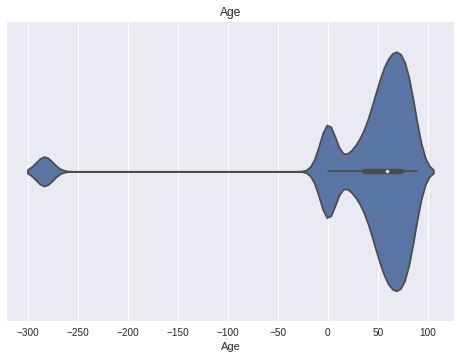

In [0]:
plotter.plot_violin(subset = ["Age"],inner = 'box')

One thing we missed is to check for any incorrect values in the variables we calculated. The above plot shows a couple of people with negative ages. This could be due to incorrect recording of date of birth. We can filter out such records. 

In [0]:
plotter.data = plotter.data[plotter.data.Age>=0]

Let's plot the graph again and see now

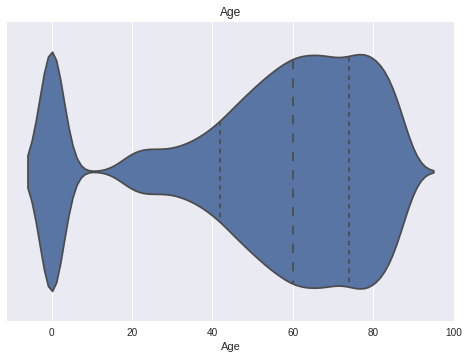

In [0]:
plotter.plot_violin(subset = ["Age"],inner='quartile')

To understand the frequency distribution, we can also use the histogram.

In [0]:
def plot_hist(self,subset = None,**args):
  """
  Function to plot a histogram for all numeric columns identified in the plotter class
  args :-
    subset : a subset of columns
    kwargs : arguments to pass for the sns.distplot function
  """
  if subset == None:
    columns_considered = self.numeric_columns
  else:
    columns_considered = subset
  for x in columns_considered:
    sns.distplot(self.data[x], **args)
    plt.title(" ".join(x.split("_")))
    plt.show()

Plotter.plot_hist = plot_hist

And let's not ignore the box plot.

In [0]:
def plot_box(self,subset = None,**args):
  """
  Function to plot a box plot for all numeric columns identified in the plotter class
  args :-
    subset : a subset of columns
    kwargs : arguments to pass for the sns.boxplot function
  """
  if subset == None:
    columns_considered = self.numeric_columns
  else:
    columns_considered = subset
  for x in columns_considered:
    sns.boxplot(self.data[x], **args)
    plt.title(" ".join(x.split("_")))
    plt.show()

Plotter.plot_box = plot_box

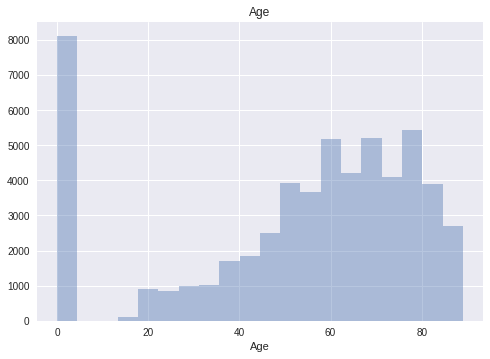

In [0]:
plotter.plot_hist(subset = ["Age"],kde = False,bins = 20)

Just as suggested by the violin plot, one main take away is that most of the patients are aged 50+(as suggested by the quartile ranges) and many are newborns.

Consider readmit.

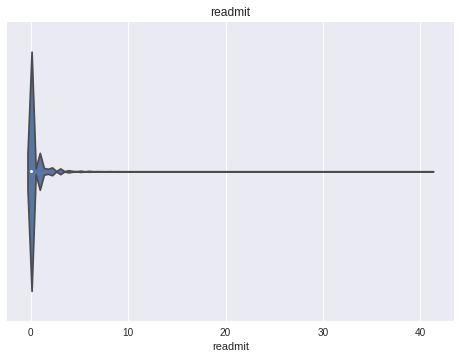

In [0]:
plotter.plot_violin(["readmit"])

There is an outlier that is making the violin plot look like this. Let's take a look at hte histogram for a better understanding.

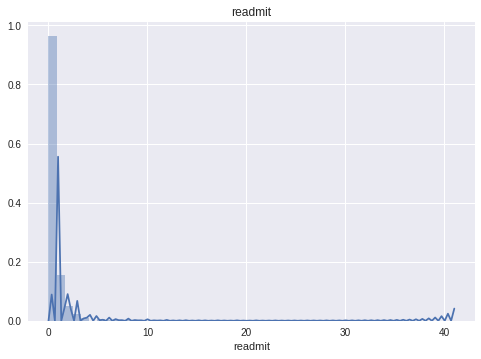

In [0]:
plotter.plot_hist(["readmit"],kde=True)

Since there is an outlier in our data, it can really throw off the results of the less robust statistical tests and models. We can either deal with this outlier or end up using only the robust statistical tests and hope regularisation takes care on the model front.
<br>
Instead, we can use a technique called winsorization. Winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers. Let's go ahead and try winsorizing the data.

Text(0.5,1,'Readmits')

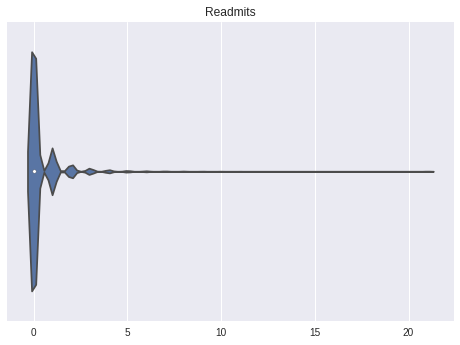

In [0]:
sns.violinplot(pd.Series(scipy.stats.mstats.winsorize(plotter.data.readmit,limits=(None,0.001))))
plt.title("Readmits")

The readmits columns basically contains the number of previous readmits and most of the patients have not been readmitted, hence the skew in the data. The plot above shows the result of winsorizing the data by trimming the right most 0.001% of the data in the plot.

Moving on to the length of stay.

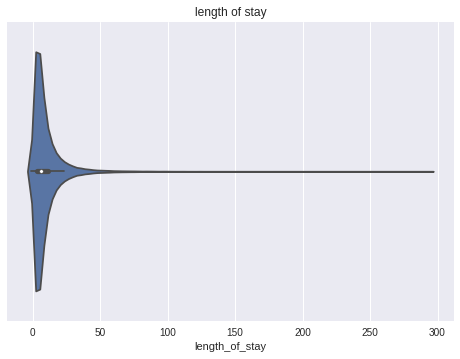

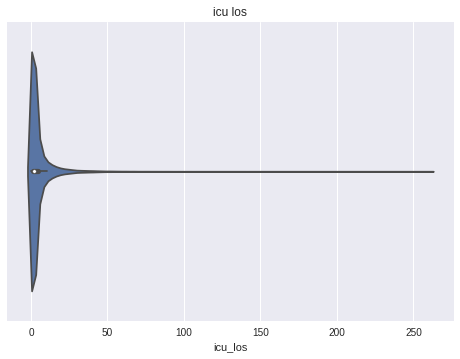

In [0]:
plotter.plot_violin(subset = ["length_of_stay","icu_los"])

As expected, the length of stay of most admits is less than 10-20 days. However, some have a length of stay of -1. Let's take a closer look at the data. 

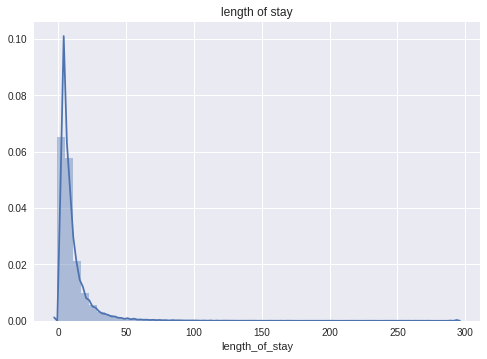

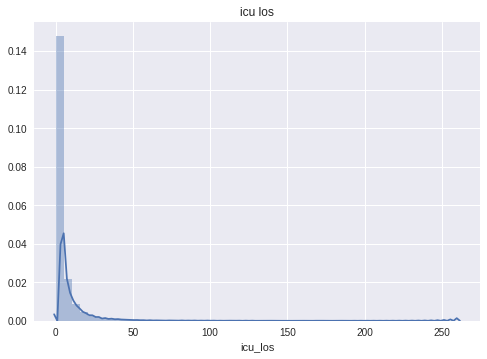

In [0]:
plotter.plot_hist(subset = ["length_of_stay","icu_los"])

In [0]:
df[df.length_of_stay<0]

,index,admission_location,admission_type,admittime,diagnosis,discharge_location,dischtime,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender,Age,CCI,Chronic,icu_los,n_drugs,hadm_id_proc,organ,diagnoses_found
236,456,EMERGENCY ROOM ADMIT,EMERGENCY,2153-10-12 09:49:00,DISSECTING ANEURYSIM,DEAD/EXPIRED,2153-10-12 06:29:00,WHITE,102631,Private,Unobtainable,MARRIED,CHRISTIAN,181,0,NaN,0,0,0.0,-1,2088-07-24,male,65,4,False,0.8590,0.0,178169,endocrine_system,DISEASES OF THE CIRCULATORY SYSTEM
533,425,PHYS REFERRAL/NORMAL DELI,URGENT,2177-03-23 16:17:00,ORGAN DONOR ACCOUNT,DEAD/EXPIRED,2177-03-23 07:20:00,WHITE,102633,Private,Unobtainable,MARRIED,NOT SPECIFIED,417,0,NaN,0,0,1.0,-1,2126-12-27,female,50,1,False,0.0000,0.0,118322,therapeutic,not found
643,693,EMERGENCY ROOM ADMIT,EMERGENCY,2197-07-31 20:18:00,RESPIRATORY DISTRESS,DEAD/EXPIRED,2197-07-31 01:10:00,UNKNOWN/NOT SPECIFIED,187482,Medicare,Unobtainable,WIDOWED,JEWISH,516,0,NaN,0,0,0.0,-1,2126-08-07,female,71,9,False,0.2020,0.0,169443,therapeutic,NEOPLASMS
1637,1911,CLINIC REFERRAL/PREMATURE,NEWBORN,2137-09-02 14:43:00,NEWBORN,DEAD/EXPIRED,2137-09-02 12:00:00,WHITE,138015,Private,Unobtainable,UNKNOWN,CHRISTIAN,1334,0,NaN,0,0,0.0,-1,2137-09-02,male,0,0,False,0.5503,24.0,146775,cardiovascular_system,FACTORS INFLUENCING HEALTH STATUS & CONTACT WI...
1696,1970,EMERGENCY ROOM ADMIT,EMERGENCY,2189-01-02 14:25:00,STROKE;TELEMETRY,DEAD/EXPIRED,2189-01-02 12:00:00,WHITE,181430,Medicare,Unobtainable,MARRIED,NOT SPECIFIED,1381,0,NaN,0,0,0.0,-1,2107-07-15,female,81,6,False,0.4647,0.0,168026,digestive_system,DISEASES OF THE CIRCULATORY SYSTEM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57351,57210,CLINIC REFERRAL/PREMATURE,EMERGENCY,2172-11-27 17:30:00,INTRACRANIAL HEMORRHAGE,DEAD/EXPIRED,2172-11-27 00:00:00,WHITE,192239,Medicare,ENGL,WIDOWED,CHRISTIAN,95022,0,NaN,0,0,0.0,-1,1872-11-27,male,-284,4,False,0.4518,0.0,135364,cardiovascular_system,DISEASES OF THE CIRCULATORY SYSTEM
57452,58884,EMERGENCY ROOM ADMIT,EMERGENCY,2135-04-03 14:16:00,CHEST PAIN,DEAD/EXPIRED,2135-04-03 12:00:00,WHITE,139266,Medicare,ENGL,MARRIED,CHRISTIAN,95367,0,NaN,0,0,0.0,-1,2048-10-19,male,86,4,False,0.3941,0.0,196948,therapeutic,DISEASES OF THE RESPIRATORY SYSTEM
57955,57234,EMERGENCY ROOM ADMIT,EMERGENCY,2103-09-25 20:38:00,CARDIAC ARREST,DEAD/EXPIRED,2103-09-25 12:00:00,WHITE,165589,Medicaid,RUSS,WIDOWED,NOT SPECIFIED,96810,0,NaN,0,0,1.0,-1,1803-07-11,female,-284,1,False,0.1949,0.0,147677,cardiovascular_system,DISEASES OF THE CIRCULATORY SYSTEM
58609,57559,EMERGENCY ROOM ADMIT,EMERGENCY,2164-11-14 20:03:00,INTRACRANIAL HEMORRHAGE,DEAD/EXPIRED,2164-11-14 12:00:00,WHITE,193747,Medicare,ENGL,MARRIED,NOT SPECIFIED,98943,0,NaN,0,0,0.0,-1,2083-12-04,male,81,4,False,0.1894,0.0,138471,cardiovascular_system,INTEGUMENTARY SYSTEM


In [0]:
df[df.length_of_stay<0].discharge_location.value_counts()

DEAD/EXPIRED           80
HOME                   10
SHORT TERM HOSPITAL     4
OTHER                   3
HOME HEALTH CARE        1
Name: discharge_location, dtype: int64

Since there are very few values with inconsistancies, we can ge rid of those rows. We shall discuss this later.

Consider Charlson Comorbidity index

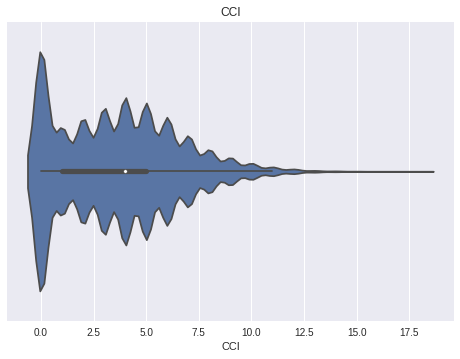

In [0]:
plotter.plot_violin(subset = ["CCI"])

Many of the patients have a comorbidity index of 0. However, since people over 40 years of age by default have a comorbidity value greater than 0, we can notice many values between 0 to 10.

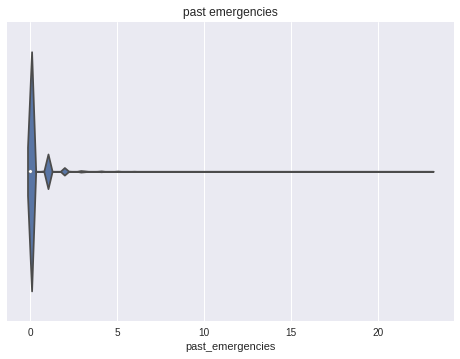

In [0]:
plotter.plot_violin(subset = ['past_emergencies'])

Very few people have had a past emergency readmit, however in some cases there are outliers.

Text(0.5,1,'Past Emergencies')

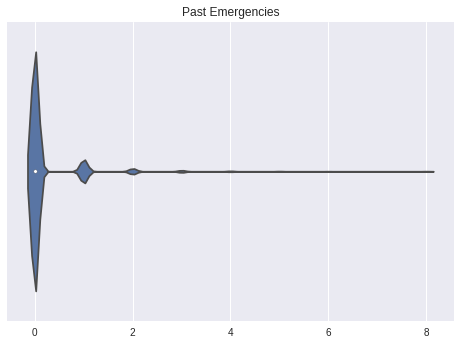

In [0]:
sns.violinplot(pd.Series(scipy.stats.mstats.winsorize(plotter.data.past_emergencies,limits=(None,0.001))))
plt.title("Past Emergencies")

Taking a look at number of drugs

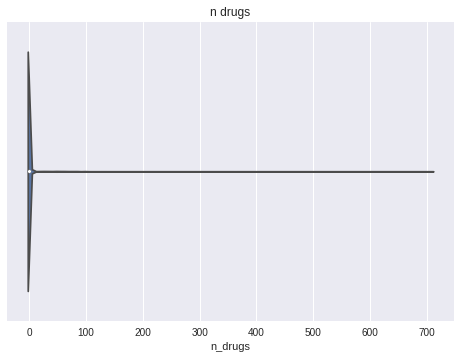

In [0]:
plotter.plot_violin(subset= ['n_drugs'])

Text(0.5,1,'Number of drugs')

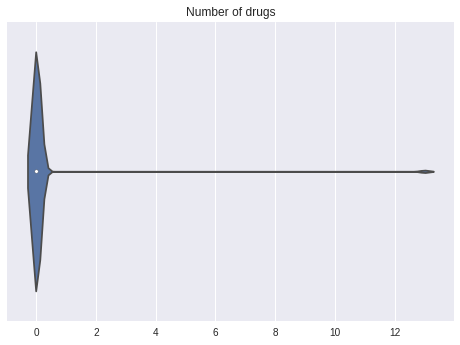

In [0]:
sns.violinplot(pd.Series(scipy.stats.mstats.winsorize(plotter.data.n_drugs,limits=(None,0.01))))
plt.title("Number of drugs")

Now let's consider the categorical data and their distribution. One of the most commonly used plot for categorical data is the bar plot. Let's add a function to plot bar plots into our plotter class

In [0]:
def plot_bar(self, subset = None,holdout = None,dropna=False):
  """
  Function to plot a bar plot for all categorical columns identified in the plotter class
  args :-
    subset : a subset of columns
    holdout : a set of columns to ignore
    dropna : to drop the na values while plotting
  """
  if subset == None:
    columns_considered = self.categorical_columns
  else:
    columns_considered = subset
  if holdout:
    columns_considered = [x for x in columns_considered if x not in holdout]
  for x in columns_considered:
    self.data[x].value_counts(dropna=dropna).plot.bar()
    plt.title(" ".join(x.split("_")))
    plt.show()

Plotter.plot_bar = plot_bar

Let's go ahead and plot the bar graphs for the frequency distribution of all the categorical variables

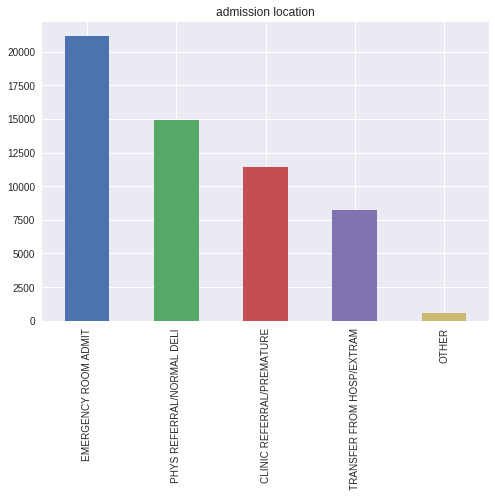

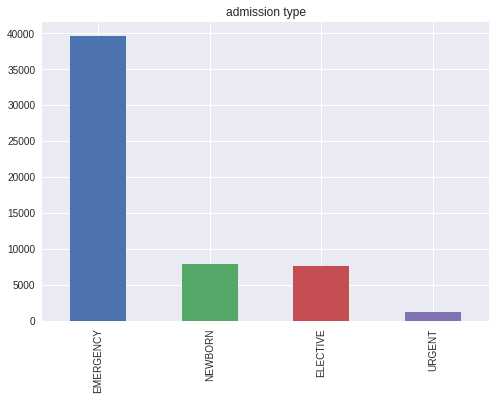

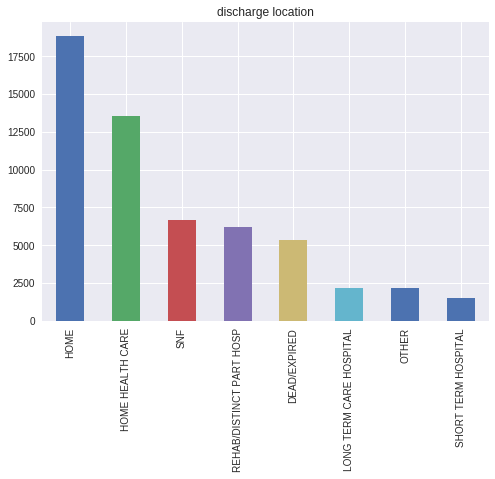

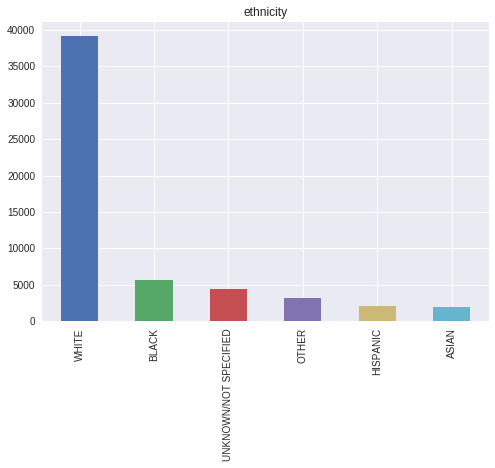

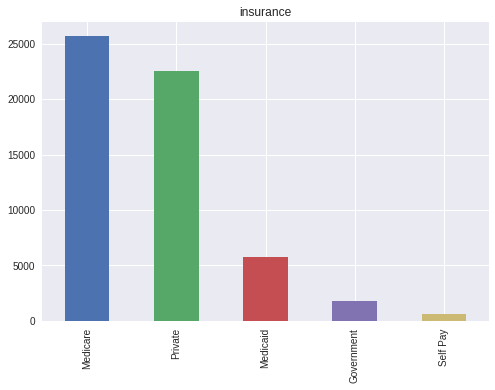

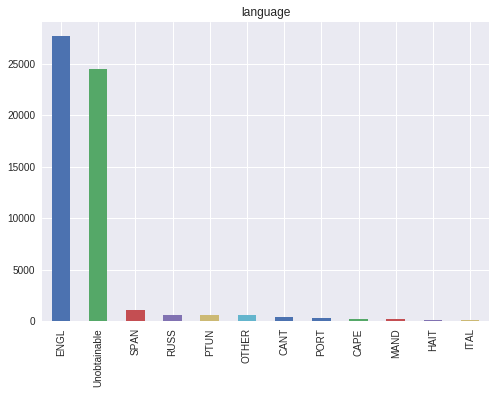

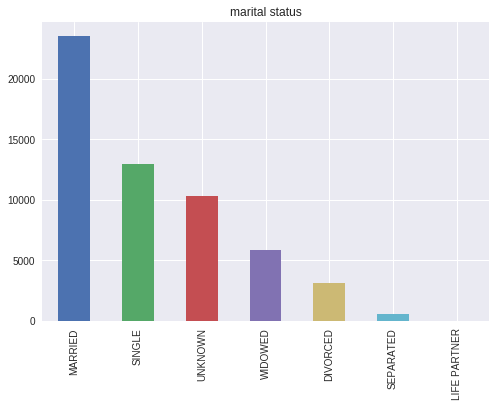

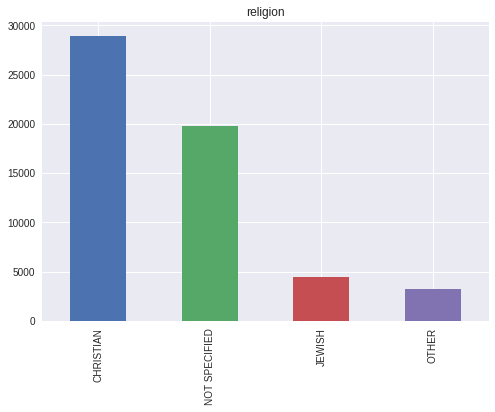

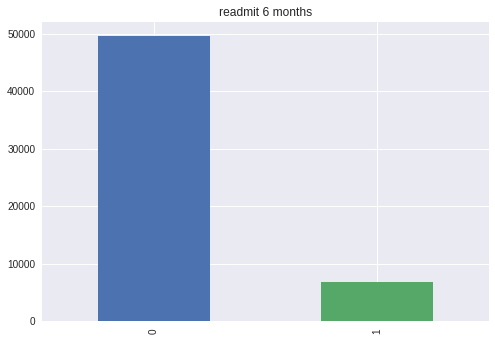

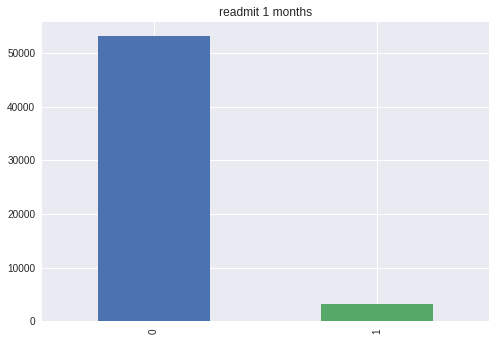

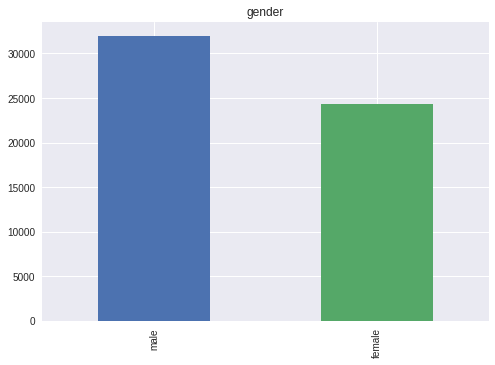

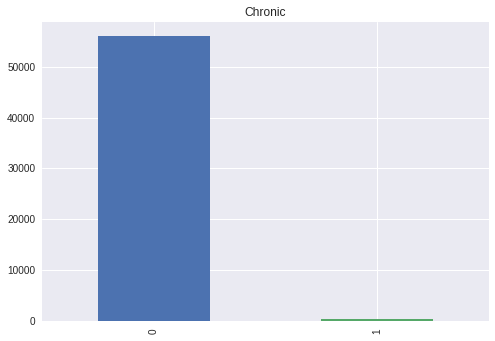

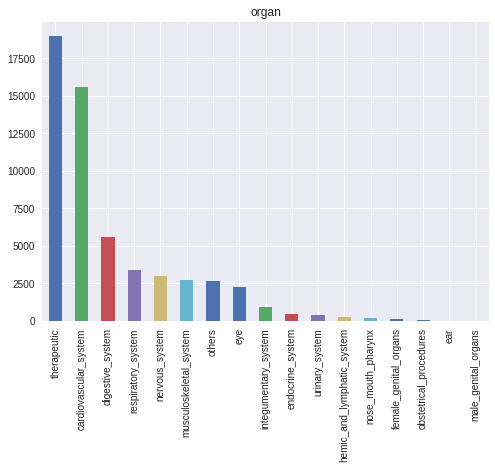

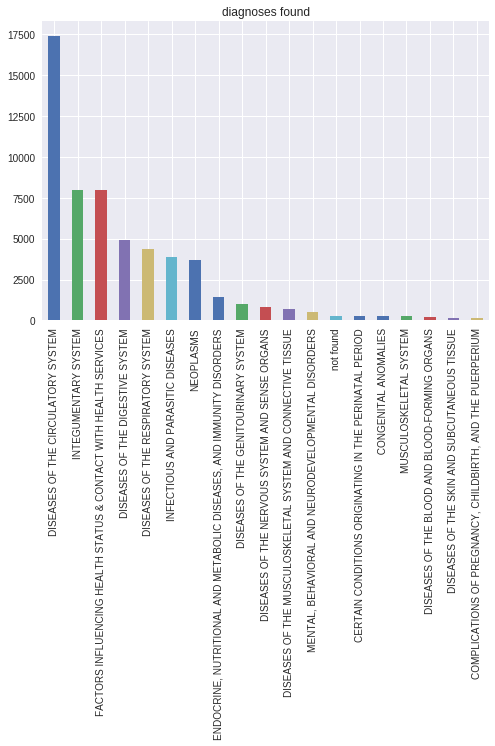

In [0]:
plotter.plot_bar()

<a id='Bivariate'></a>
## Bivariate

In the bivariate analysis, we compare the individual variables with the target variable to find interesting patterns.

Since the target variable we are interested in a categorical variable(readmit or not), we shall plot the percentage of people in each category being readmitted or not.

Some helper functions:-

In [0]:
def plot_bar_bivariate(self, subset = None,target = "readmit_6_months",holdout = [],dropna=False,default_targets = ["readmit_6_months","readmit_1_months","readmitted"]):
  """
  Function to plot a bivariate bar plot for all categorical columns identified in the plotter class.
  This function plots the percentages of readmited for each of the categories.
  args :-
    subset : a subset of columns
    holdout : a set of columns to ignore
    dropna : to drop the na values while plotting
    target : the target we are trying to plot for. Default is readmitted as that is our target variable
  """
  if subset == None:
    columns_considered = self.categorical_columns
  else:
    columns_considered = subset
  holdout = default_targets + holdout
  if holdout:
    columns_considered = [x for x in columns_considered if x not in holdout]
  for x in columns_considered:
    temp = plotter.data.groupby([x,target])
    groups = list(set([x[0] for x in temp.groups.keys()]))
    percentage_readmitted = {}
    #print(x)
    for y in groups:
      readmitted = temp.get_group((y,1)).count()[0]
      not_readmitted = temp.get_group((y,0)).count()[0]
      percentage_readmitted[y] = readmitted/(readmitted + not_readmitted)
    sns.barplot(x = list(percentage_readmitted.keys()), y = list(percentage_readmitted.values()))
    plt.xticks(rotation=45)
    plt.ylim(0,1)
    plt.title("Percentage of readmits for "+" ".join(x.split("_")))
    plt.xlabel(" ".join(x.split("_")))
    plt.ylabel("Percentage Readmitted")
    plt.show()

Plotter.plot_bar_bivariate = plot_bar_bivariate

Let's take a look at discharge location and its readmission percentages:-

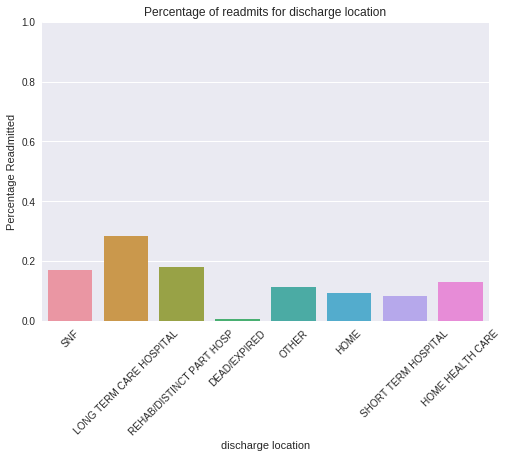

In [0]:
plotter.plot_bar_bivariate(subset = ["discharge_location"])

You might have noticed, a couple of patients who are expired have been readmitted!!

This call for attention into the integrity of the data and our calculation of the target variable. Let's take a look at the data for one of the subjects who are dead.

In [0]:
df[df.subject_id==417]

,index,admission_location,admission_type,admittime,diagnosis,discharge_location,dischtime,ethnicity,hadm_id,insurance,language,marital_status,religion,subject_id,readmit,t_read,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,dob,gender,Age,CCI,Chronic,icu_los,n_drugs,hadm_id_proc,organ,diagnoses_found
532,424,EMERGENCY ROOM ADMIT,EMERGENCY,2177-03-22 22:24:00,SUBARACHNOID HEMORRHAGE,DEAD/EXPIRED,2177-03-23 07:20:00,WHITE,178013,Private,Unobtainable,MARRIED,NOT SPECIFIED,417,1,0.0,1,1,0.0,0,2126-12-27,female,50,2,False,1.3413,0.0,186494,digestive_system,DISEASES OF THE CIRCULATORY SYSTEM
533,425,PHYS REFERRAL/NORMAL DELI,URGENT,2177-03-23 16:17:00,ORGAN DONOR ACCOUNT,DEAD/EXPIRED,2177-03-23 07:20:00,WHITE,102633,Private,Unobtainable,MARRIED,NOT SPECIFIED,417,0,NaN,0,0,1.0,-1,2126-12-27,female,50,1,False,0.0000,0.0,118322,therapeutic,not found


As we can see in the above example, the patient was considered readmitted even though he is dead on account of organ donation after death. Since we are interested only in the readmittions of living patients, we can safely drop rows of dead patients. Also, let's get rid of the negative length of stays.

In [0]:
plotter.data = plotter.data[plotter.data.discharge_location != "DEAD/EXPIRED"]
plotter.data = plotter.data[plotter.data.length_of_stay >= 0]

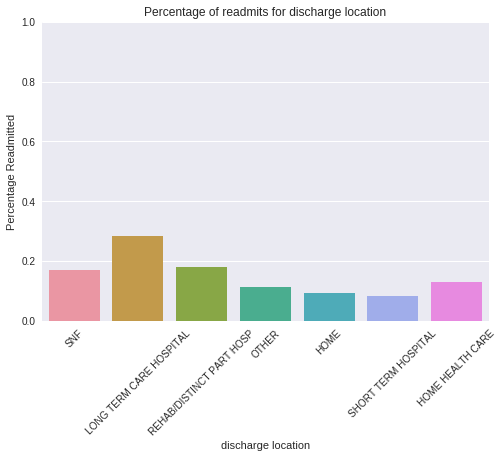

In [0]:
plotter.plot_bar_bivariate(subset = ["discharge_location"])

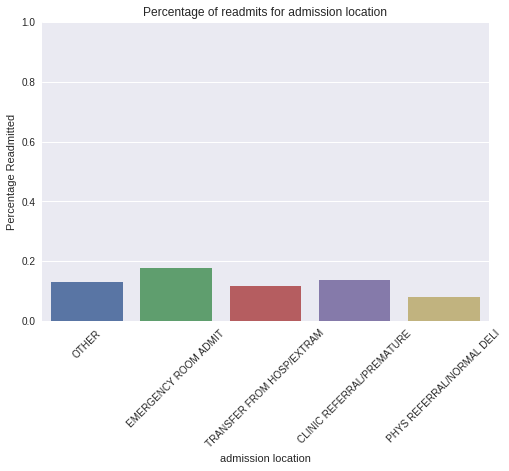

In [0]:
plotter.plot_bar_bivariate(subset = ["admission_location"])

According to our data, a greater proportion of emergency room admits have been readmitted. 

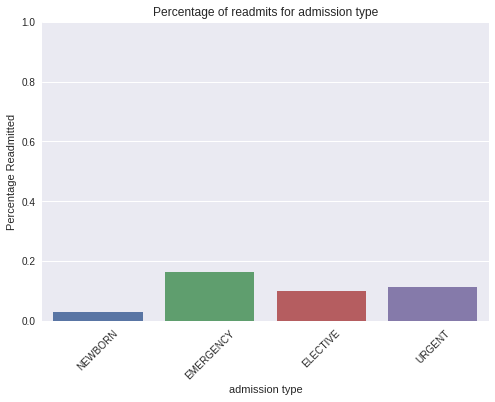

In [0]:
plotter.plot_bar_bivariate(subset = ["admission_type"])

Newborns seem to have a lower proportion of readmissions. Apart from that, the other admission types have similar proportion of readmissions.

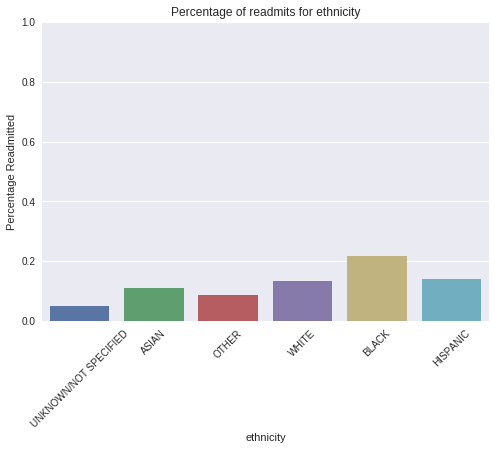

In [0]:
plotter.plot_bar_bivariate(subset = ["ethnicity"])

According to the data, people with black ethnicity have witnessed a higher readmission percentage.

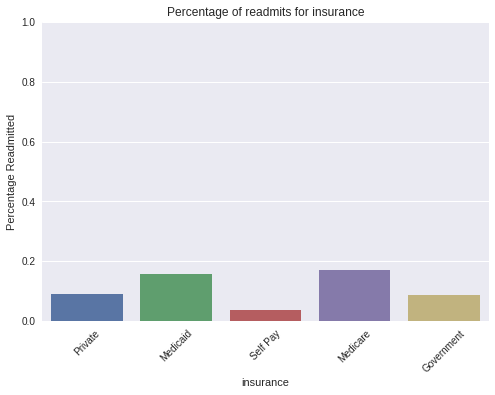

In [0]:
plotter.plot_bar_bivariate(subset = ["insurance"])

When it comes to insurance, people with medicaid or medicare insurance have a greater readmission percentage.

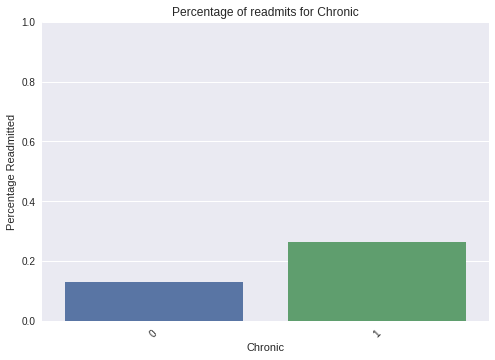

In [0]:
plotter.plot_bar_bivariate(subset=['Chronic'])

People with a Chronic condition have a higher readmission percentage.

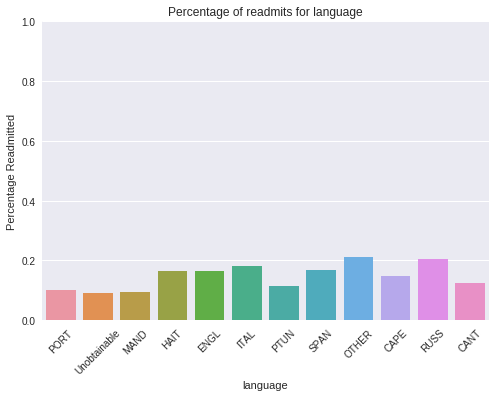

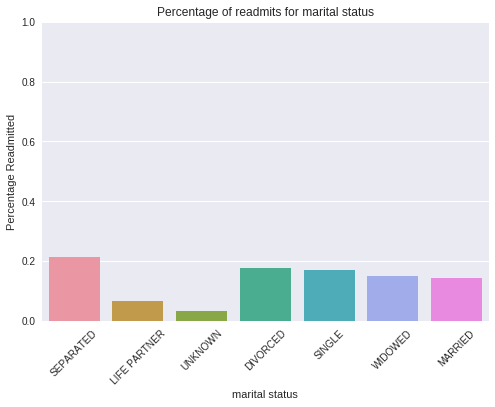

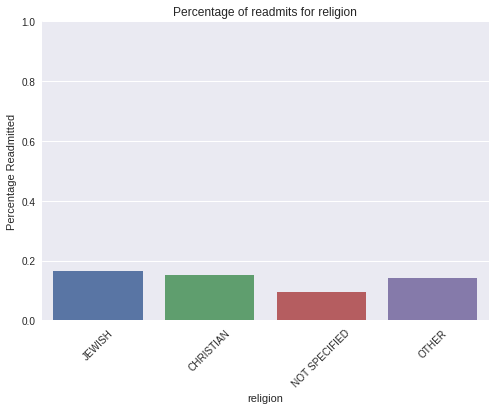

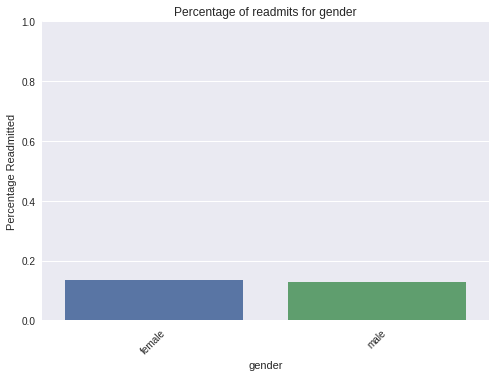

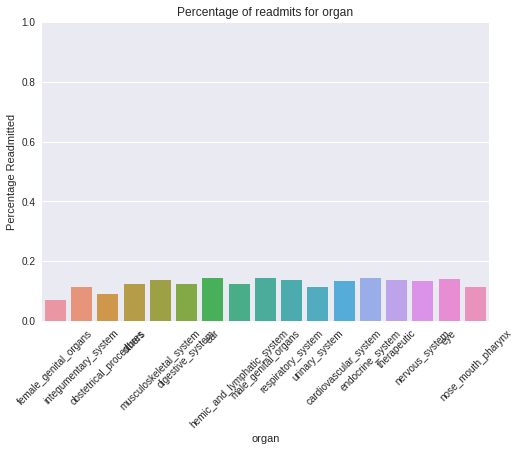

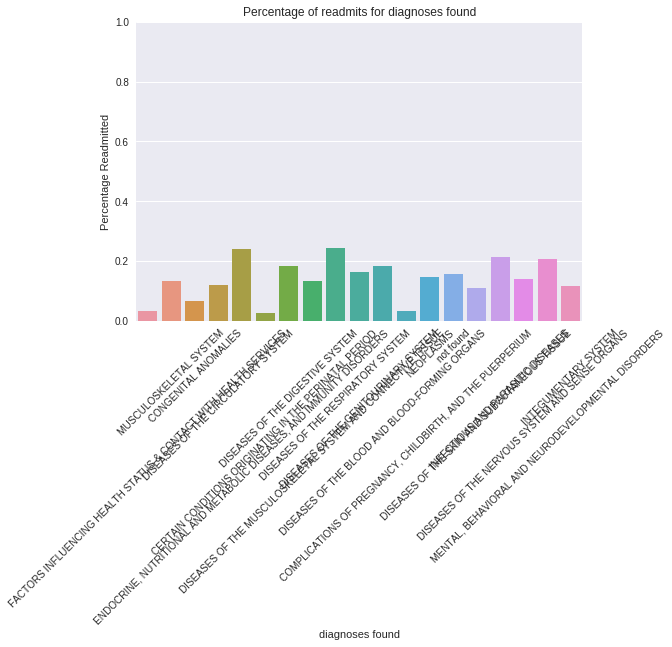

In [0]:
plotter.plot_bar_bivariate(holdout = ['Chronic','insurance','admission_type','admission_location','discharge_location','ethnicity'])

The remaining categories do not show much difference.

Considering the numeric columns, we can bin them up and have a comparision with the target variable

In [0]:
def plot_bar_numeric_bivariate(self, subset = None,bins_range = (0,100,1),target = "readmit_6_months",holdout = [],dropna=False):
  """
  Function to plot a bivariate bar plot for all categorical columns identified in the plotter class.
  This function plots the percentages of readmited for each of the categories.
  args :-
    subset : a subset of columns
    holdout : a set of columns to ignore
    dropna : to drop the na values while plotting
    target : the target we are trying to plot for. Default is readmitted as that is our target variable
  """
  if subset == None:
    columns_considered = self.numeric_columns
  else:
    columns_considered = subset
  columns_considered = [x for x in columns_considered if x not in holdout]
  for x in columns_considered:
    if bins_range:
      bins = [x for x in range(*bins_range)]
    else :
      bins = None
    #print(bins)
    temp = pd.DataFrame()
    temp[x] = plotter.data[x]
    temp[target] = plotter.data[target]
    temp[x] = pd.cut(temp[x],bins = bins,right=False)
    #print(temp)
    temp = temp.groupby([x,target])
    groups = list(set([x[0] for x in temp.groups.keys()]))
    #print(groups)
    groups.sort()
    percentage_readmitted = {}
    #print(x)
    for y in groups:
      try:
        readmitted = temp.get_group((y,1)).count()[0]
        not_readmitted = temp.get_group((y,0)).count()[0]
        percentage_readmitted[y] = readmitted/(readmitted + not_readmitted)
      except:
        pass
    percentage_readmitted
    sns.barplot(x = list(percentage_readmitted.keys()), y = list(percentage_readmitted.values()))
    plt.xticks(rotation=45)
    plt.ylim(0,1)
    plt.title("Percentage of readmits for "+" ".join(x.split("_")))
    plt.xlabel(" ".join(x.split("_")))
    plt.ylabel("Percentage Readmitted")
    plt.show()
    del(temp)
Plotter.plot_bar_numeric_bivariate = plot_bar_numeric_bivariate

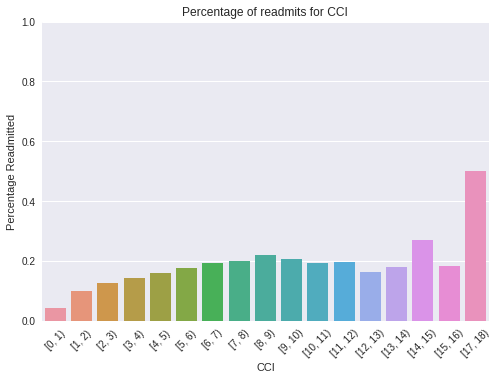

In [0]:
plotter.plot_bar_numeric_bivariate(subset = ["CCI"],bins_range=(0,20,1))

Taking a look at Charlson's comorbidity index, readmit percentage rise as the index value rises. However, very high comorbidities have low readmit percentages. This could be due to less data with people with high comorbidities. We shall consider this more during the statistical analysis phase.

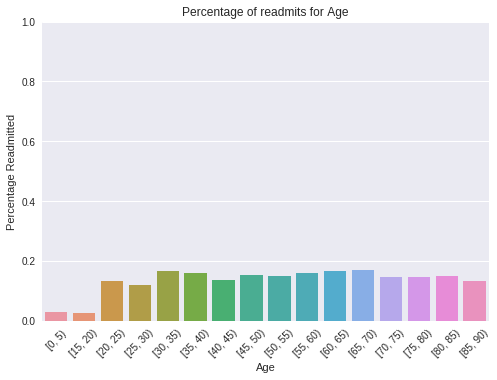

In [0]:
plotter.plot_bar_numeric_bivariate(subset = ["Age"],bins_range = (0,100,5))

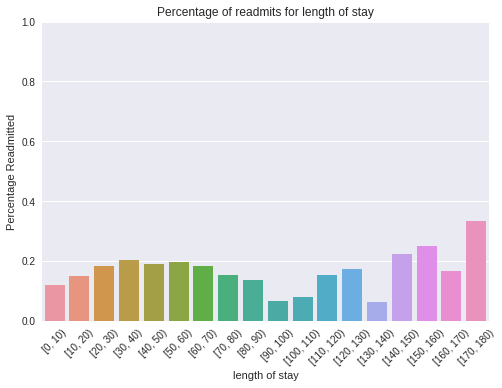

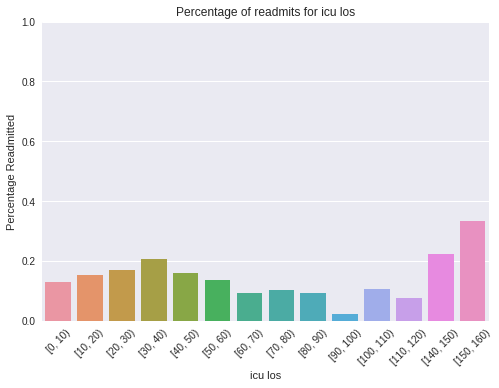

In [0]:
plotter.plot_bar_numeric_bivariate(subset=["length_of_stay","icu_los"],bins_range=(0,1000,10))

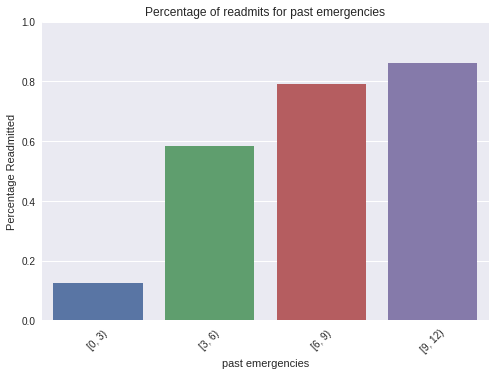

In [0]:
plotter.plot_bar_numeric_bivariate(subset=["past_emergencies"],bins_range=(0,1000,3))

When it comes to past emergencies, people with more number of past emergencies tend to get readmitted

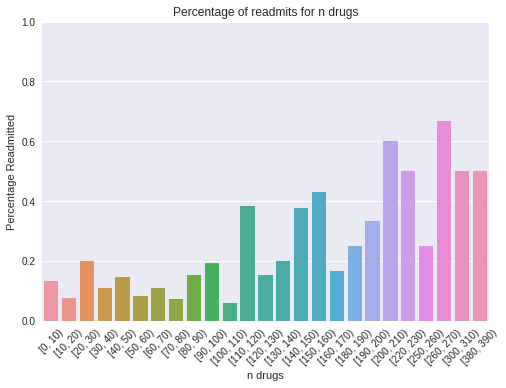

In [0]:
plotter.plot_bar_numeric_bivariate(subset=["n_drugs"],bins_range=(0,1000,10))

As expected, people who have consumed more drugs have a higher readmission percentage.

<a id='Multivariate'></a>
## Multivariate

In multivariate analysis, we consider more than two variables while plotting. Since there are many different combinations, we will try to choose the ones that make sense.

In [0]:
def plot_3d_bar(self,X,Y,target="readmit_6_months",colors_list = None,**kwargs):
  '''
  plots 3d barplots for categorical data.
  args : 
    X : x axis lable
    Y : y axis lable
    target : z axis lable
    colors_list : list of colors for each row in y axis
    **kwargs : arguments to pass to the 3d plot function
  '''
  #get unique names for the lables of x and y axis
  x_unique = sorted(list(self.data[X].unique()))
  y_unique = self.data[Y].unique()
  
  '''
  make combination of these names. For instance, if x_unique = [1,2,3] and y_unique = [4,5] , then x_y will have
  x_y = [(1,4),(1,5),(2,4),(2,5),(3,4),(3,5)]
  '''
  x_y = [(x,y) for y in y_unique for x in x_unique]
  
  temp = self.data.groupby([X,Y,target])
  groups = list(set([x[:2] for x in temp.groups.keys()]))
  percentage_readmitted = {x:0 for x in x_y}
  
  for y in groups:
    try :
      readmitted = temp.get_group(tuple(y+tuple([1]))).count()[0]
      not_readmitted = temp.get_group(tuple(y+tuple([0]))).count()[0]
      percentage_readmitted[y] = readmitted/(readmitted + not_readmitted)
    except :
      percentage_readmitted[y] = 0.00
  #creating a plot object
  fig = plt.figure(figsize = (12,12))
  ax = Axes3D(fig)

  
  
  #Since we need to provide intger number for plotting the graph:-
  xlabs = list(range(1,len(x_unique)+1))
  ylabs = list(range(1,len(y_unique)+1))

  #Store the number of categories
  n_x_cats = len(xlabs)
  n_y_cats = len(ylabs)

  #Calculating the values to feed into the function
  x_vals = xlabs*n_y_cats
  y_vals = [[x]*n_x_cats for x in ylabs]
  y_vals = reduce(lambda x,y : x+y,y_vals)
  
  if colors_list:
    colors=[]
    try:
      for y in range(n_y_cats):
        colors += [colors_list[y]]*n_x_cats
      colors_list = colors
      
    except IndexError:
      print("Need %d colors...Resetting to None" % (n_y_cats))
      colors_list = None

  #Calculating the span of the bar slabs
  dx_val = 0.5
  dy_val = 0.5
  dz_vals = [percentage_readmitted[x] for x in x_y]

  #Call the function using these values
  ax.bar3d(x_vals,y_vals,np.zeros(len(x_vals)),dx_val,dy_val,dz_vals,color = colors_list,**kwargs)

  #Replacing numbers with the categorical names:-

  ##Distance at which they need to be placed
  ticksx = np.arange(1.25, n_x_cats+1, 1)
  ticksy = np.arange(1.25, n_y_cats+1, 1)

  ##adding the tick names
  plt.xticks(ticksx, x_unique)
  plt.yticks(ticksy, y_unique)
  ax.set_zlim(0,1)
  
  plt.xlabel(X)
  plt.ylabel(Y)
  ax.set_zlabel("Readmission percentage")
  for x, y, z in zip(x_vals, y_vals, dz_vals):
      label = "%0.2f" % (z)
      ax.text(x, y+0.25, z, label,('y'),color = 'yellow')
Plotter.plot_3d_bar = plot_3d_bar


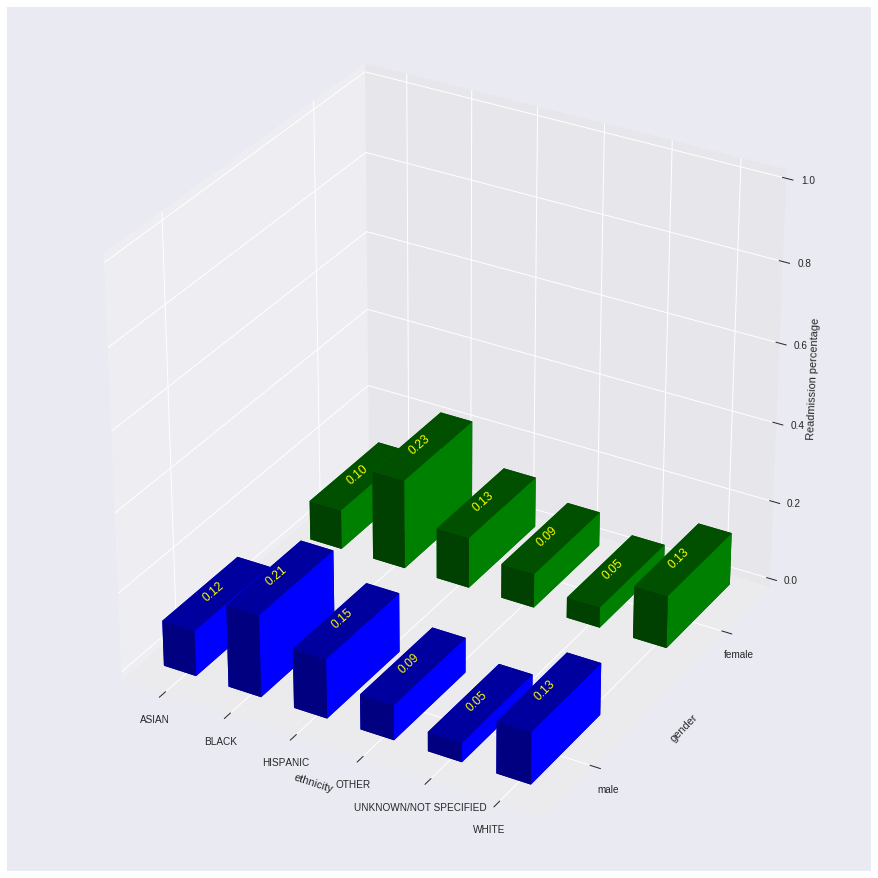

In [0]:
plotter.plot_3d_bar("ethnicity","gender",shade = True,colors_list = ['blue','green'])

When it comes to the interaction of ethnicity and gender, there is not much difference between the different genders and their effect on readmission percentages. We will discard gender as a feature after statistical analysis.

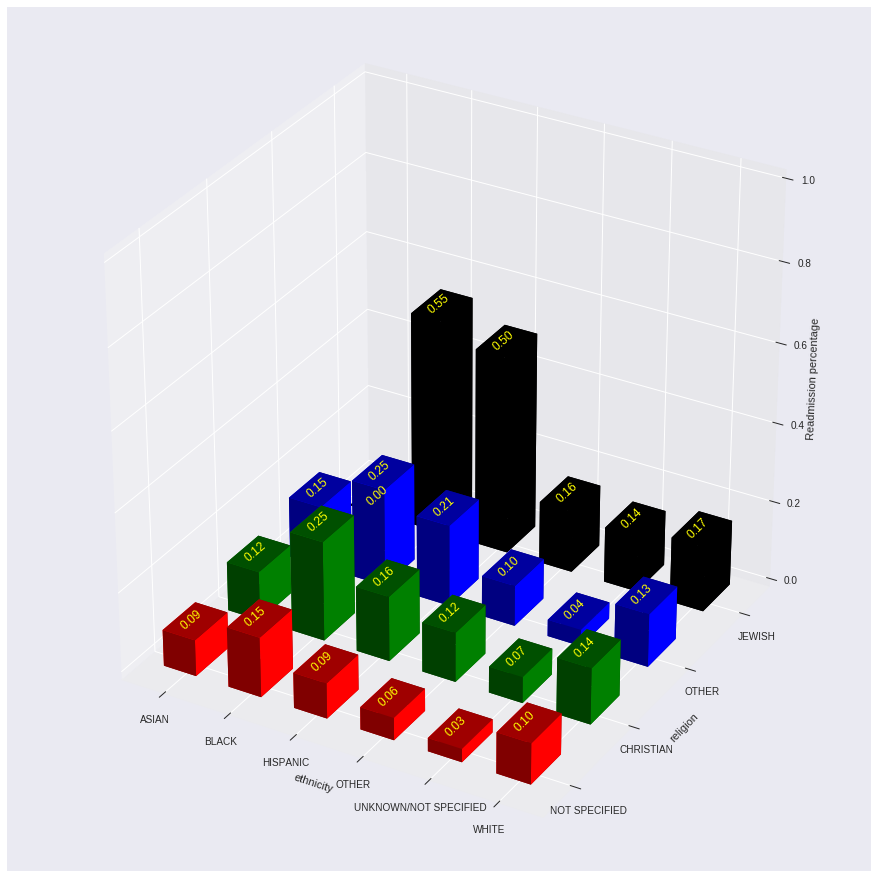

In [0]:
plotter.plot_3d_bar("ethnicity","religion",shade = True,colors_list = ['red','green','blue','black'])

According to the data, black jews have a very high readmission within 6 months percentage.

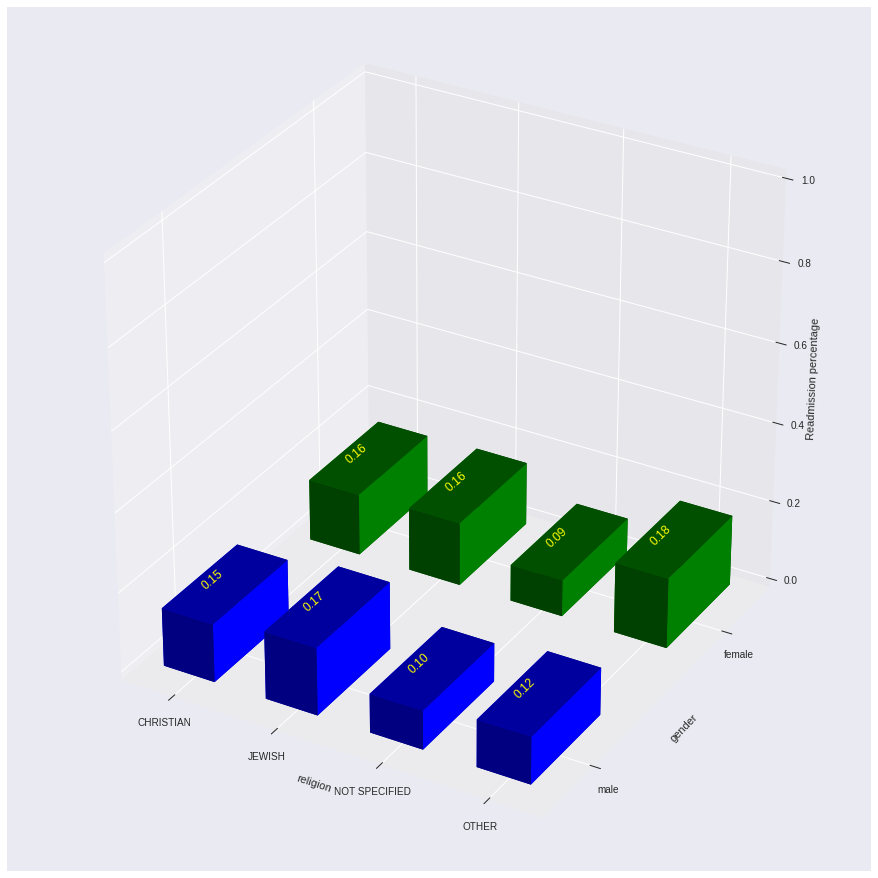

In [0]:
plotter.plot_3d_bar("religion","gender",shade = True,colors_list = ['blue','green','blue','black'])

Gender seems to make very little difference in the readmission percentage.

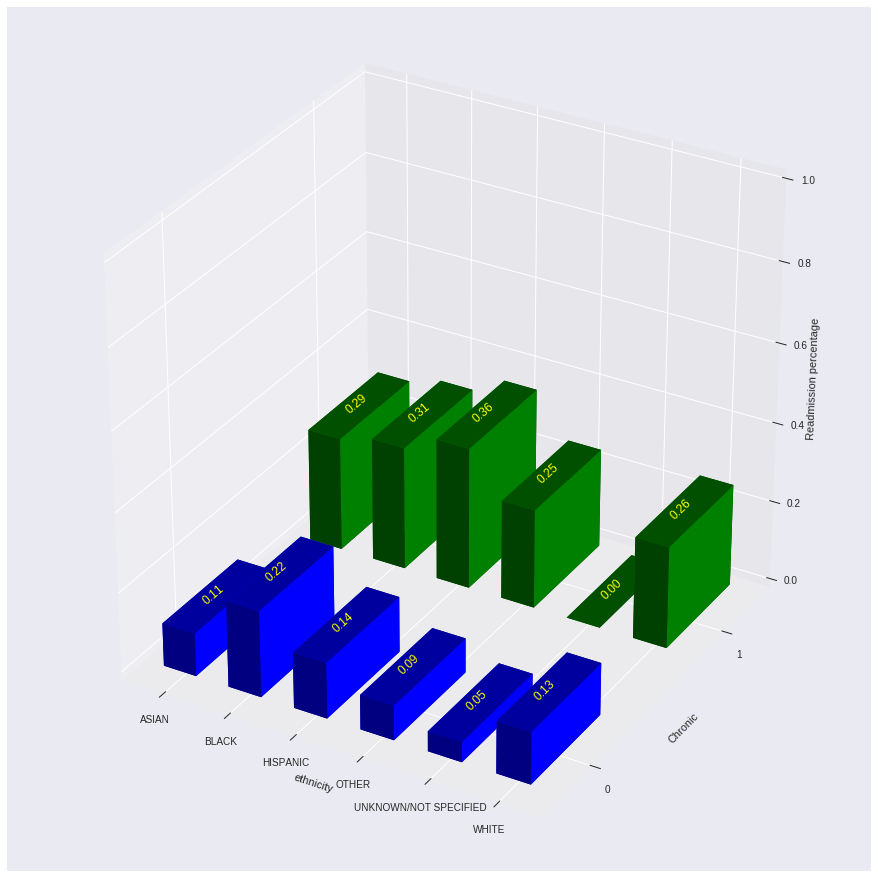

In [0]:
plotter.plot_3d_bar("ethnicity","Chronic",shade = True,colors_list = ['blue','green','blue','black'])

People with a chronic condition have a higher readmission percentages. One case of interaction between unknown ethnicity and chronic shows 0 % as there are no records of individuals with that combination of characters.

Let's bin up the numeric columns and plot the values

In [0]:
plotter.data["Age_bins"] = pd.cut(plotter.data.Age,bins = list(range(0,100,10)),right=False)

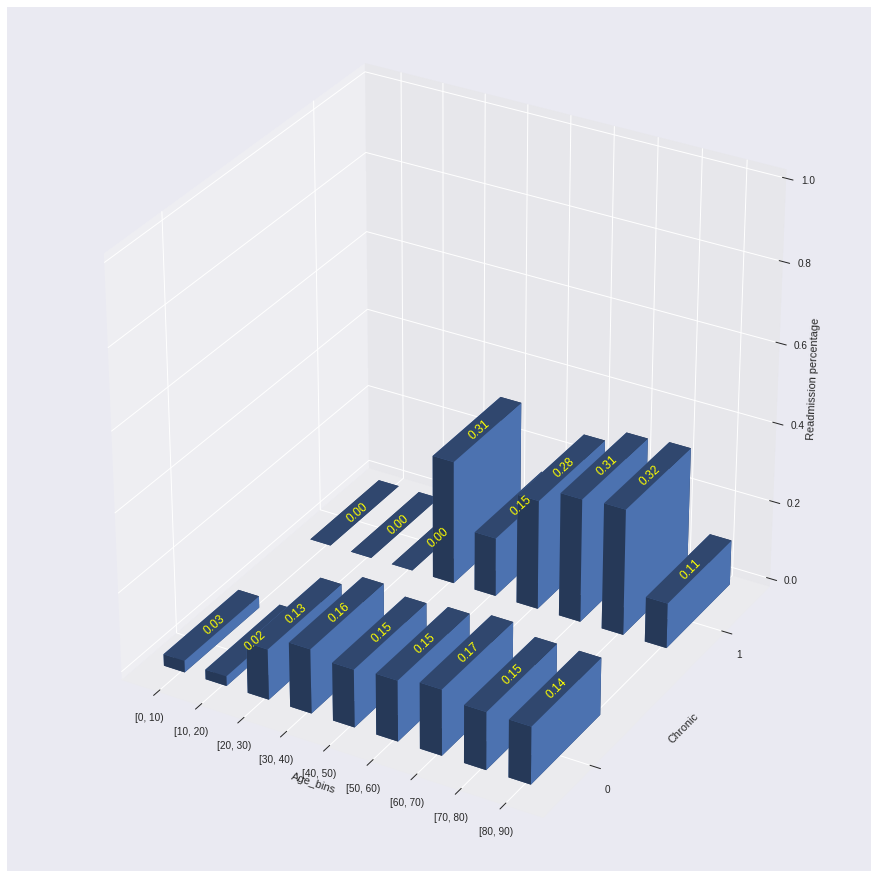

In [0]:
plotter.plot_3d_bar("Age_bins","Chronic")

# Session

##### Dumping session to pickup from where we left off
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import dill

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

folder_id = '1SdfphKDmQlT04yw5Sebb2sYq6IpLaJOR'
uploaded = drive.CreateFile({'title': 'session5.db','parents':[{u'id': folder_id}]})
dill.dump_session('session5.db')
uploaded.SetContentFile('session5.db')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import dill
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download_path = os.path.expanduser('~/data')
try:
    os.makedirs(download_path)
except :
    pass
file_id = "1IXFcBU9hl6oUnCfQJ_CzPnETMnDYJpd6" #"1gXIYSEl6YoGYTQAPmZ9C8JbBn2yc3kEb"#"1lS4Or4PAPifKnmP9OVbNal5Ud6mgcWtc"
output_file = os.path.join(download_path, "session.db")
temp_file = drive.CreateFile({'id': file_id })
temp_file.GetContentFile(output_file)
dill.load_session(output_file)

<a id='Data_modeling'></a>
# Data Modeling

This is the phase where we build machine learning model using the features we identified. We shall split this into two stages:-
<ol>
    <li><a href='#Statistical_analysis'> Statistical analysis </a></li>
    <li><a href='#Model_training'> Model training </a></li>
</ol>

First let's import the additional modules required for this section.

In [0]:
import scipy
import itertools

<a id='Statistical_analysis'></a>
## Statistical analysis

In statistical analysis, we perform statistical tests on the predictors to test their significance on predicting the target variable.

For comparing the categorical variables with the target variable, we shall use the chi square test of independence. According to the chi square test of independence, we compare the observed probability values with the expected probability values and calculate the statistic. The hypothesis being tested are :-
* Null hypothesis : There is no significant relationship between the two variables.
* Alternate hypothesis : There is a significant relationship between the two variables.

Using the p value, which is basically the probability of observing the values that we got if the null hypothesis were true, we can determine if the predictors are significant and if it would make sense to use them in the model. Using this, we can also compare two individual categories of a categorical variable to see which categories differ(in case there were more than two categories). Repeating this over all combinations of categories, we get an idea of which categories are differing.

One thing to note is that when the number of categories are greater than two, than there will be a greater type 1 error in calculation of the p value. Hence, for categorical variables that have more than two categories, we shall use the bonferroni adjustment. The concept behind bonferroni adjustment is that, the threshold for the p value will depend on the number of comparisions, i.e, if the threshold was 0.05 for 1 comparision, we shall have a threshold of 0.05/15 = 0.003 for 15 comparisions (in case there were 6 categories, so 15 comparisions).

Let's build a helper function for the purpose of performing a chi square test of independence:-

In [0]:
def chi_square_wrapper(df,target='readmit_6_months',columns=None,verbose=False,alpha=0.05):
  '''Function performs the Chi square test of independence of all the columns with the target variable.
  This test is generally used for comparing two categorical variables.

  Parameters
  ----------
  df -> The pandas dataframe
  target -> The target variable you want to test for
  columns -> the specific list of columns you want to test. All categorical columns if not specified.
  alpha -> the significance level. Default is 0.05
  '''
  if columns == None:
    numeric_columns = list(df._get_numeric_data().columns)
    columns = [x for x in df.columns if x not in numeric_columns]
  useful_columns = []
  for column in columns:
    if column == target:
      continue
    print("For "+column+" :-\n")
    cros = pd.crosstab(df.loc[:,target],df.loc[:,column])
    chi2, p, dof, ex = scipy.stats.chi2_contingency(cros,correction = True)
    if verbose:
      print("Chisquared statistic :",chi2)
      print("P value :",p)
      print("Degrees of freedom :",dof)
      print("Expected counts :-\n ",ex)
      print("Actual counts :-\n",cros)
    if p < alpha :
      print("Reject null hypothesis\n--------------------")
      useful_columns.append(column)
    else:
      print("Accept null hypothesis\n--------------------")
  print("According to the test, the useful columns are :-\n"+", ".join(useful_columns))
  
final_df = plotter.data.drop(columns = ["Age_bins"])

First let's test the features that have just two levels.

In [0]:
chi_square_wrapper(final_df,columns = ["gender","Chronic"],alpha = 0.05,verbose = True)

For gender :-

Chisquared statistic : 6.733614635074202
P value : 0.009461268201607613
Degrees of freedom : 1
Expected counts :-
  [[19097.80547279 25176.19452721]
 [ 2908.19452721  3833.80547279]]
Actual counts :-
 gender            female   male
readmit_6_months               
0                  18999  25275
1                   3007   3735
Reject null hypothesis
--------------------
For Chronic :-

Chisquared statistic : 51.39556168194715
P value : 7.55090578987951e-13
Degrees of freedom : 1
Expected counts :-
  [[43965.91488945   308.08511055]
 [ 6695.08511055    46.91488945]]
Actual counts :-
 Chronic               0    1
readmit_6_months            
0                 44012  262
1                  6649   93
Reject null hypothesis
--------------------
According to the test, the useful columns are :-
gender, Chronic


You might have noticed that the p value for gender is lower than 0.05. However, the value is just slightly smaller than 0.05 (0.011). This just means that the probability of observing the values that we observed is just around 0.011 if the null hypothesis was true( if there was no corelation between gender and readmission).

Similarly, the chronic condition also has a very low p value. This is more apparant if you take a look at the number of chronic people being readmitted. The difference between the observed and expected value is huge(almost twice).

Now let's look at the variables which have multiple categories.

In [0]:
chi_square_wrapper(final_df,columns = ['admission_location','discharge_location'],verbose = True)

For admission_location :-

Chisquared statistic : 672.356457764203
P value : 3.3690680688174077e-144
Degrees of freedom : 4
Expected counts :-
  [[ 9038.60965187 15993.52254195   463.4294339  12605.45417124
   6172.98420103]
 [ 1376.39034813  2435.47745805    70.5705661   1919.54582876
    940.01579897]]
Actual counts :-
 admission_location  CLINIC REFERRAL/PREMATURE  EMERGENCY ROOM ADMIT  OTHER  \
readmit_6_months                                                             
0                                        8993                 15174    464   
1                                        1422                  3255     70   

admission_location  PHYS REFERRAL/NORMAL DELI  TRANSFER FROM HOSP/EXTRAM  
readmit_6_months                                                          
0                                       13354                       6289  
1                                        1171                        824  
Reject null hypothesis
--------------------
For discharge_locat

If you consider the admission location and discharge location, we know the variable is significant. However, according to the test, atleast on of the categories should be different. How do we know which categories are different?.
One simple way to do this is to compare the categories among themselves with pairs of two with the bonferroni adjustment to account for the number of categories.
Let's write a simple function to do this.


In [0]:
def chi2_posthoc(df,column,target,verbose = False,alpha = 0.05):
  '''
  This function performs the post hoc test for the column specified. Basically we make combinations of the 
  categories in the column and compare them individually.
  
  Parameters
  ----------
  df -> The pandas dataframe
  target -> The target variable you want to test for.
  columns -> the specific column you want to test.
  alpha -> significance value.
  verbose -> to print all.
  
  Returns a dataframe of the results.
  '''
  col = pd.Categorical(df[column])
  n_categories = col.categories
  combinations = list(itertools.combinations(col.categories,2))
  adjusted_p = 0.05/len(combinations)
  result = pd.DataFrame(columns = ["group1","group2","chi2",'p',"reject"])
  for x in combinations:
    cat1,cat2 = x
    df_with_two_cats = df[(df[column] == cat1) | (df[column] == cat2)]
    cross = pd.crosstab(df_with_two_cats[target],df_with_two_cats[column])
    chi2, p, dof, ex = scipy.stats.chi2_contingency(cross,correction = True)
    reject = False
    if verbose:
      print("For ",cat1,cat2)
      print("Chisquared statistic :",chi2)
      print("P value :",p)
      print("Degrees of freedom :",dof)
      print("Expected counts :-\n ",ex)
      print("Actual counts :-\n",cross)
    if p<adjusted_p:
      reject = True
    result.loc[len(result)] = [cat1,cat2,chi2,p,reject]
  return result

First, let's compute the regular chisquare test on all variables to find out the significant ones. Then, we can perform the post hoc test.

In [0]:
chi_square_wrapper(final_df,columns = ['admission_location', 'admission_type', 'discharge_location',
       'ethnicity', 'insurance', 'language', 'marital_status', 'religion','organ','diagnoses_found'],
       alpha = 0.05,verbose = False)

For admission_location :-

Reject null hypothesis
--------------------
For admission_type :-

Reject null hypothesis
--------------------
For discharge_location :-

Reject null hypothesis
--------------------
For ethnicity :-

Reject null hypothesis
--------------------
For insurance :-

Reject null hypothesis
--------------------
For language :-

Reject null hypothesis
--------------------
For marital_status :-

Reject null hypothesis
--------------------
For religion :-

Reject null hypothesis
--------------------
For organ :-

Accept null hypothesis
--------------------
For diagnoses_found :-

Reject null hypothesis
--------------------
According to the test, the useful columns are :-
admission_location, admission_type, discharge_location, ethnicity, insurance, language, marital_status, religion, diagnoses_found


All columns except for the **organ** column have been considered as important. Let's take a closer look at the organ column test results.

In [0]:
chi_square_wrapper(final_df,columns = ['organ'],
       alpha = 0.05,verbose = True)

For organ :-

Chisquared statistic : 15.275527851927182
P value : 0.5045585404597587
Degrees of freedom : 16
Expected counts :-
  [[1.22617874e+04 4.39390117e+03 6.07491767e+00 3.65362906e+02
  1.74176568e+03 7.55025482e+01 1.69229849e+02 7.02086914e+02
  6.07491767e+00 2.12361765e+03 2.32582562e+03 1.69229849e+02
  9.54629920e+00 2.08369676e+03 2.63043935e+03 1.48991695e+04
  3.10688647e+02]
 [1.86721260e+03 6.69098832e+02 9.25082327e-01 5.56370942e+01
  2.65234319e+02 1.14974518e+01 2.57701505e+01 1.06913086e+02
  9.25082327e-01 3.23382351e+02 3.54174377e+02 2.57701505e+01
  1.45370080e+00 3.17303238e+02 4.00560648e+02 2.26883048e+03
  4.73113533e+01]]
Actual counts :-
 organ             cardiovascular_system  digestive_system  ear  \
readmit_6_months                                                 
0                                 12266              4432    6   
1                                  1863               631    1   

organ             endocrine_system   eye  female_genit

A p value of 0.50! Because of the test, we shall drop this column.

In [0]:
final_df.drop(columns = ['organ'],inplace = True)
final_df

,admission_location,admission_type,discharge_location,ethnicity,insurance,language,marital_status,religion,readmit,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,gender,Age,CCI,Chronic,icu_los,n_drugs,diagnoses_found
0,PHYS REFERRAL/NORMAL DELI,NEWBORN,HOME,ASIAN,Private,Unobtainable,UNKNOWN,NOT SPECIFIED,0,0,0,0.0,3,male,0,0,0,0.0918,0.0,FACTORS INFLUENCING HEALTH STATUS & CONTACT WI...
1,EMERGENCY ROOM ADMIT,EMERGENCY,SNF,WHITE,Medicare,Unobtainable,MARRIED,CHRISTIAN,0,0,0,0.0,10,male,76,5,0,6.0646,0.0,INFECTIOUS AND PARASITIC DISEASES
2,EMERGENCY ROOM ADMIT,EMERGENCY,OTHER,WHITE,Private,Unobtainable,SINGLE,CHRISTIAN,0,0,0,0.0,7,female,47,7,0,1.6785,0.0,INFECTIOUS AND PARASITIC DISEASES
3,PHYS REFERRAL/NORMAL DELI,NEWBORN,HOME,ASIAN,Private,Unobtainable,UNKNOWN,OTHER,0,0,0,0.0,2,male,0,0,0,0.0844,0.0,FACTORS INFLUENCING HEALTH STATUS & CONTACT WI...
4,PHYS REFERRAL/NORMAL DELI,ELECTIVE,HOME HEALTH CARE,WHITE,Medicare,ENGL,MARRIED,NOT SPECIFIED,0,0,0,0.0,16,female,65,4,1,3.6729,0.0,DISEASES OF THE CIRCULATORY SYSTEM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58946,EMERGENCY ROOM ADMIT,EMERGENCY,HOME HEALTH CARE,WHITE,Private,ENGL,MARRIED,JEWISH,0,0,0,0.0,16,male,53,1,0,11.2998,0.0,INFECTIOUS AND PARASITIC DISEASES
58947,PHYS REFERRAL/NORMAL DELI,ELECTIVE,HOME,WHITE,Private,ENGL,MARRIED,NOT SPECIFIED,0,0,0,0.0,12,male,47,2,0,3.1426,0.0,DISEASES OF THE DIGESTIVE SYSTEM
58948,CLINIC REFERRAL/PREMATURE,EMERGENCY,SNF,WHITE,Medicare,ENGL,WIDOWED,CHRISTIAN,0,0,0,0.0,2,female,65,2,0,1.9745,0.0,INTEGUMENTARY SYSTEM
58949,PHYS REFERRAL/NORMAL DELI,ELECTIVE,HOME,WHITE,Medicare,ENGL,MARRIED,NOT SPECIFIED,0,0,0,0.0,3,female,88,7,0,2.1615,0.0,DISEASES OF THE CIRCULATORY SYSTEM


Now for the post hoc test

In [0]:
chi2_posthoc(final_df,"admission_location","readmit_6_months")

,group1,group2,chi2,p,reject
0,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,78.427442,8.299123e-19,True
1,CLINIC REFERRAL/PREMATURE,OTHER,0.085976,7.693564e-01,False
2,CLINIC REFERRAL/PREMATURE,PHYS REFERRAL/NORMAL DELI,202.961315,4.716607e-46,True
3,CLINIC REFERRAL/PREMATURE,TRANSFER FROM HOSP/EXTRAM,16.009531,6.302440e-05,True
4,EMERGENCY ROOM ADMIT,OTHER,7.130899,7.576675e-03,False
5,EMERGENCY ROOM ADMIT,PHYS REFERRAL/NORMAL DELI,643.082206,7.138505e-142,True
6,EMERGENCY ROOM ADMIT,TRANSFER FROM HOSP/EXTRAM,140.827414,1.755016e-32,True
7,OTHER,PHYS REFERRAL/NORMAL DELI,16.686786,4.408702e-05,True
8,OTHER,TRANSFER FROM HOSP/EXTRAM,0.974953,3.234481e-01,False
9,PHYS REFERRAL/NORMAL DELI,TRANSFER FROM HOSP/EXTRAM,70.362563,4.934758e-17,True


As per the bonferroni adjustment, the above dataframe gives the results. Note that a value True under reject column indicates that the two groups differ and contribute to the target. You may notice a p value less than 0.05 also got accepted for the null hypothesis. This is because of the bonferroni adjustment where we divide p by the number of combinations.

We can take a look at the other columns as well.

In [0]:
chi2_posthoc(final_df,"admission_type","readmit_6_months")

,group1,group2,chi2,p,reject
0,ELECTIVE,EMERGENCY,180.394253,3.975021e-41,True
1,ELECTIVE,NEWBORN,316.323169,9.158173e-71,True
2,ELECTIVE,URGENT,1.340900,2.468753e-01,False
3,EMERGENCY,NEWBORN,941.270943,1.047694e-206,True
4,EMERGENCY,URGENT,20.160203,7.121933e-06,True
5,NEWBORN,URGENT,173.347290,1.374440e-39,True


In [0]:
chi2_posthoc(final_df,"discharge_location","readmit_6_months")

,group1,group2,chi2,p,reject
0,HOME,HOME HEALTH CARE,115.588241,5.849738e-27,True
1,HOME,LONG TERM CARE HOSPITAL,692.394571,1.347620e-152,True
2,HOME,OTHER,7.603237,5.826362e-03,False
3,HOME,REHAB/DISTINCT PART HOSP,340.813016,4.244345e-76,True
4,HOME,SHORT TERM HOSPITAL,1.686908,1.940090e-01,False
...,...,...,...,...,...
16,OTHER,SHORT TERM HOSPITAL,8.049846,4.550752e-03,False
17,OTHER,SNF,43.157620,5.050282e-11,True
18,REHAB/DISTINCT PART HOSP,SHORT TERM HOSPITAL,83.731660,5.667035e-20,True
19,REHAB/DISTINCT PART HOSP,SNF,1.285057,2.569610e-01,False


In [0]:
chi2_posthoc(final_df,"ethnicity","readmit_6_months")

,group1,group2,chi2,p,reject
0,ASIAN,BLACK,104.046376,1.976355e-24,True
1,ASIAN,HISPANIC,8.974367,2.737933e-03,True
2,ASIAN,OTHER,5.252070,2.192068e-02,False
3,ASIAN,UNKNOWN/NOT SPECIFIED,63.993316,1.248421e-15,True
4,ASIAN,WHITE,7.847329,5.089586e-03,False
...,...,...,...,...,...
10,HISPANIC,UNKNOWN/NOT SPECIFIED,142.752536,6.657913e-33,True
11,HISPANIC,WHITE,1.479004,2.239304e-01,False
12,OTHER,UNKNOWN/NOT SPECIFIED,36.443970,1.571184e-09,True
13,OTHER,WHITE,44.388512,2.692626e-11,True


In [0]:
chi2_posthoc(final_df,"insurance","readmit_6_months")

,group1,group2,chi2,p,reject
0,Government,Medicaid,52.145271,5.154283e-13,True
1,Government,Medicare,82.755377,9.286287e-20,True
2,Government,Private,0.472855,4.916766e-01,False
3,Government,Self Pay,13.731966,2.108354e-04,True
4,Medicaid,Medicare,7.327023,6.792548e-03,False
5,Medicaid,Private,191.780528,1.299240e-43,True
6,Medicaid,Self Pay,53.260725,2.920883e-13,True
7,Medicare,Private,607.583826,3.752094e-134,True
8,Medicare,Self Pay,64.669671,8.856769e-16,True
9,Private,Self Pay,18.170051,2.020310e-05,True


If we take a close look at the results of the post hoc test, we can actually merge medicaid and medicare together to form just one category, and government and private to form another.

In [0]:
final_df['modified_insurance'] = final_df.insurance
final_df.modified_insurance = final_df.modified_insurance.str.replace("Medicaid|Medicare","Medicaid/Medicare",)
final_df.modified_insurance = final_df.modified_insurance.str.replace("Government|Private","Government/Private")
final_df.modified_insurance.value_counts(dropna=False)

Medicaid/Medicare     27684
Government/Private    22823
Self Pay                509
Name: modified_insurance, dtype: int64

Let's try out a post hoc test on this new column now.

In [0]:
chi2_posthoc(final_df,"modified_insurance","readmit_6_months")

,group1,group2,chi2,p,reject
0,Government/Private,Medicaid/Medicare,651.625951,9.896907e-144,True
1,Government/Private,Self Pay,17.994221,2.215766e-05,True
2,Medicaid/Medicare,Self Pay,62.797543,2.290845e-15,True


This makes more sense. Let's replace the original insurance column with this.

In [0]:
final_df['insurance'] = final_df['modified_insurance']
final_df.drop(columns = ['modified_insurance'],inplace = True)

In [0]:
chi2_posthoc(final_df,"language","readmit_6_months")

,group1,group2,chi2,p,reject
0,CANT,CAPE,0.458546,4.983041e-01,False
1,CANT,ENGL,3.539149,5.993622e-02,False
2,CANT,HAIT,1.114634,2.910769e-01,False
3,CANT,ITAL,1.759524,1.846839e-01,False
4,CANT,MAND,0.508514,4.757829e-01,False
...,...,...,...,...,...
61,PTUN,SPAN,6.487487,1.086364e-02,False
62,PTUN,Unobtainable,2.652008,1.034192e-01,False
63,RUSS,SPAN,3.012859,8.260647e-02,False
64,RUSS,Unobtainable,76.482485,2.221748e-18,True


In [0]:
chi2_posthoc(final_df,"marital_status","readmit_6_months")

,group1,group2,chi2,p,reject
0,DIVORCED,LIFE PARTNER,0.621055,4.306556e-01,False
1,DIVORCED,MARRIED,24.217702,8.603784e-07,True
2,DIVORCED,SEPARATED,3.583391,5.835991e-02,False
3,DIVORCED,SINGLE,0.858915,3.540426e-01,False
4,DIVORCED,UNKNOWN,752.554447,1.116796e-165,True
...,...,...,...,...,...
16,SEPARATED,UNKNOWN,394.809544,7.427626e-88,True
17,SEPARATED,WIDOWED,13.783291,2.051527e-04,True
18,SINGLE,UNKNOWN,1039.603333,4.426843e-228,True
19,SINGLE,WIDOWED,9.972160,1.589249e-03,True


In [0]:
chi2_posthoc(final_df,"religion","readmit_6_months")

,group1,group2,chi2,p,reject
0,CHRISTIAN,JEWISH,5.919782,1.497181e-02,False
1,CHRISTIAN,NOT SPECIFIED,291.353898,2.520905e-65,True
2,CHRISTIAN,OTHER,1.594065,2.067463e-01,False
3,JEWISH,NOT SPECIFIED,165.462685,7.248336e-38,True
4,JEWISH,OTHER,7.255224,7.069504e-03,True
5,NOT SPECIFIED,OTHER,59.695413,1.107343e-14,True


In [0]:
chi2_posthoc(final_df,'diagnoses_found','readmit_6_months')

,group1,group2,chi2,p,reject
0,CONGENITAL ANOMALIES,CERTAIN CONDITIONS ORIGINATING IN THE PERINATA...,4.169808,4.115045e-02,False
1,CONGENITAL ANOMALIES,"COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND TH...",1.374642,2.410159e-01,False
2,CONGENITAL ANOMALIES,DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS,14.802103,1.194023e-04,True
3,CONGENITAL ANOMALIES,DISEASES OF THE CIRCULATORY SYSTEM,7.997636,4.683845e-03,False
4,CONGENITAL ANOMALIES,DISEASES OF THE DIGESTIVE SYSTEM,25.127398,5.366496e-07,True
...,...,...,...,...,...
166,"MENTAL, BEHAVIORAL AND NEURODEVELOPMENTAL DISO...",NEOPLASMS,11.198374,8.186902e-04,False
167,"MENTAL, BEHAVIORAL AND NEURODEVELOPMENTAL DISO...",not found,2.286363,1.305154e-01,False
168,MUSCULOSKELETAL SYSTEM,NEOPLASMS,0.201708,6.533460e-01,False
169,MUSCULOSKELETAL SYSTEM,not found,0.405011,5.245129e-01,False


## Correlation analysis

Since our target variable is a numeric variable, and correlation analysis generally applies to quantifiable data, we cannot really perform correlation analysis to find out correlations with the target variable. However, we can still go ahead and see what patterns are visible among the numeric data.

In [0]:
corr = final_df.corr()
corr

,readmit,past_emergencies,length_of_stay,Age,CCI,icu_los,n_drugs
readmit,1.000000,0.678565,-0.007526,0.063745,0.118538,-0.023399,0.001841
past_emergencies,0.678565,1.000000,-0.014212,0.059553,0.110304,-0.027504,0.001706
length_of_stay,-0.007526,-0.014212,1.000000,-0.035763,0.027006,0.823711,0.059634
Age,0.063745,0.059553,-0.035763,1.000000,0.735152,-0.168054,0.026453
CCI,0.118538,0.110304,0.027006,0.735152,1.000000,-0.091020,0.021693
icu_los,-0.023399,-0.027504,0.823711,-0.168054,-0.091020,1.000000,0.048681
n_drugs,0.001841,0.001706,0.059634,0.026453,0.021693,0.048681,1.000000


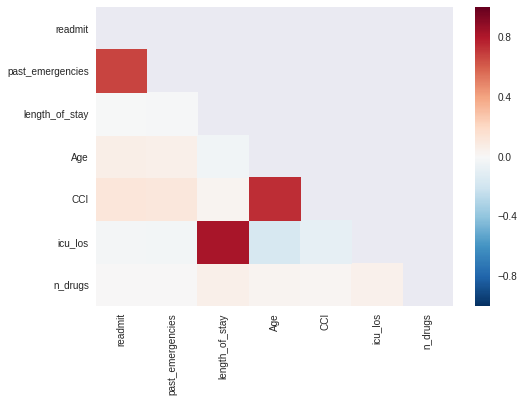

In [0]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,mask=mask)

We can also perform the pair plot

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1534: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1535: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1176: Runtim

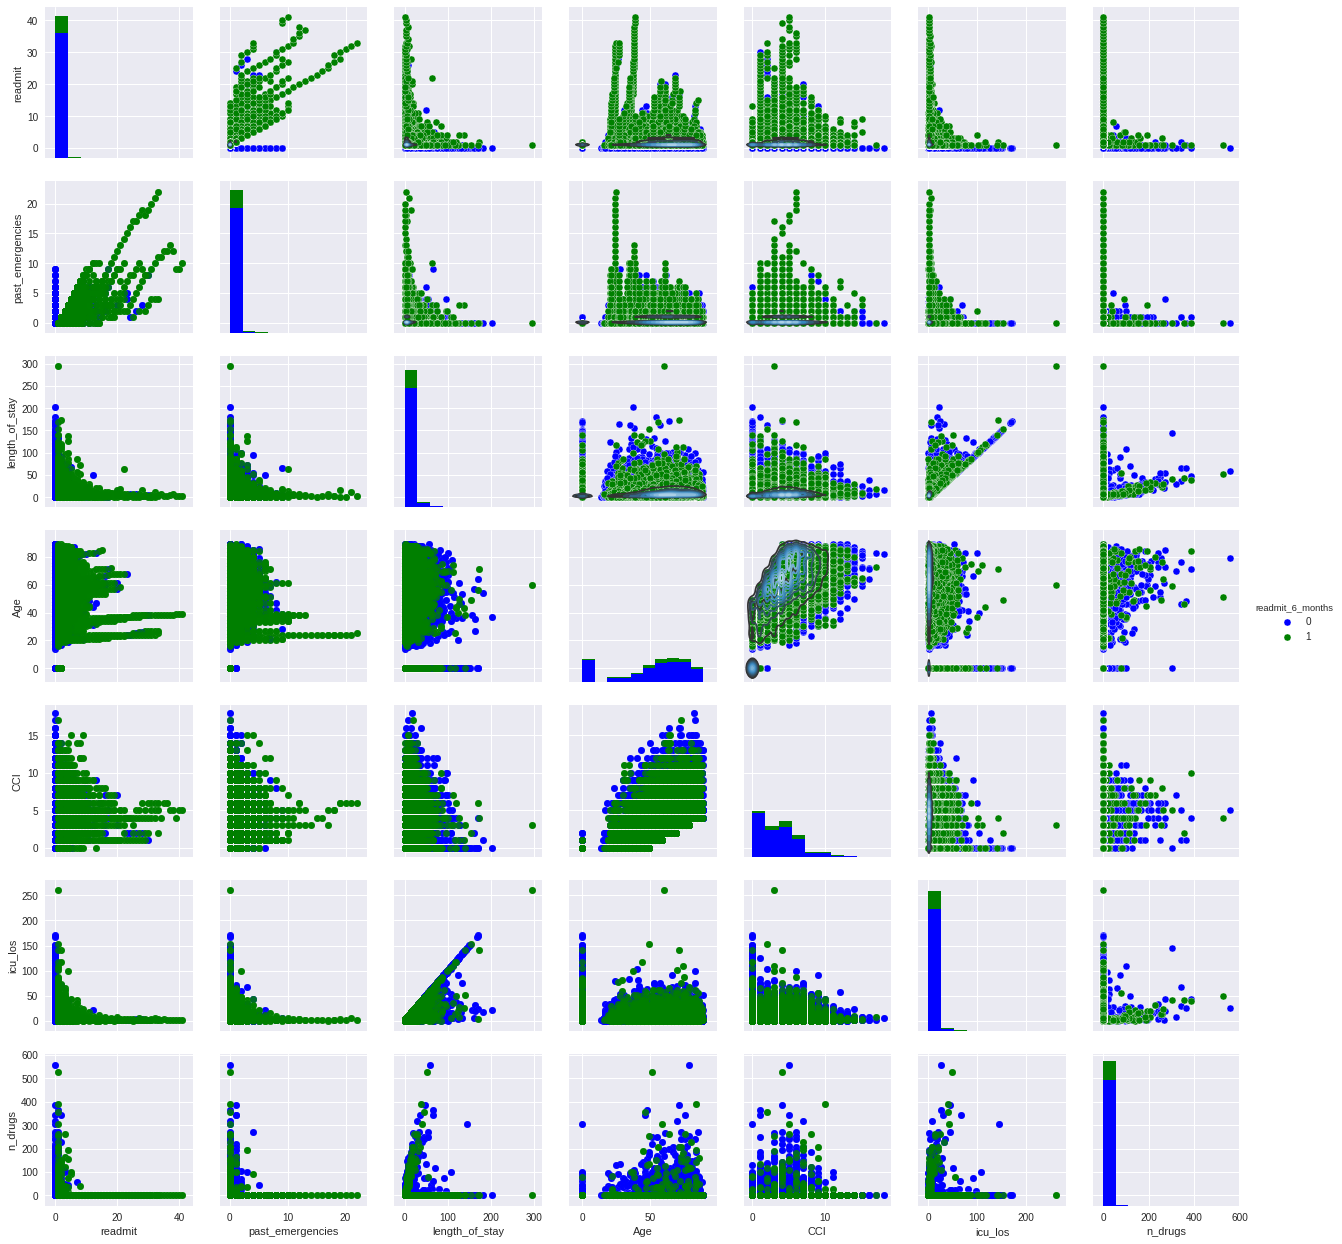

In [0]:
g = sns.pairplot(final_df,vars = final_df._get_numeric_data().columns,hue='readmit_6_months',palette={True: "green", False: "blue"})
g.map_lower(sns.regplot,fit_reg=False)
g.map_upper(sns.kdeplot, cmap="Blues_d")
plt.show()

There are a couple of interesting patterns. Length of stay and icu length of stay both basically indicate how long the patient stayed in the hospital. Hence, we see a strong positive correlation. Age and CCI have a strong correlation as Age is one of the factors we considered while calculating the CCI. past emergencies has a very strong correlation with the target variable. Most of the other variables have very little correlation with each other.

We can discard the non correlated variables, however, there are limitations with respect to our correlation analysis. First, the target variable is a categorical variable, derived from the readmit column(with certain conditions), so what applies here need not apply to the categorical version always. Take a look at the bivariate analysis part for instance. Most of these columns showed a difference between the readmitted and non readmitted percentages. Second, the correlation analysis accounts for the linear relationships. There could be some non linear relationships as well

##Session

##### Dumping session to pickup from where we left off
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import dill

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

folder_id = '1SdfphKDmQlT04yw5Sebb2sYq6IpLaJOR'
uploaded = drive.CreateFile({'title': 'Model_session.db','parents':[{u'id': folder_id}]})
dill.dump_session('Model_session.db')
uploaded.SetContentFile('Model_session.db')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import dill
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download_path = os.path.expanduser('~/data')
try:
    os.makedirs(download_path)
except :
    pass
file_id = "1CM1O_6Zge0vmJfCUqWpUQvbd03iTy9CI"
output_file = os.path.join(download_path, "session.db")
temp_file = drive.CreateFile({'id': file_id })
temp_file.GetContentFile(output_file)
dill.load_session(output_file)

<a id='Model_training'></a>
## Model training

In this phase, we shall use the identified features and build machine learning and deeplearning models to predict the target variable. First let's one hot encode all the variables so our model can work on them. Then, we will define a pipeline of feature selection, non linear transformation, dimentionality reduction, etc and fit our models

Importing required modules

In [0]:
!pip install imblearn
!pip install lightgbm
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier,RandomForestClassifier,BaggingClassifier
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, Normalizer
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

    100% |████████████████████████████████| 174kB 9.7MB/s 
    100% |████████████████████████████████| 5.4MB 5.3MB/s 
  Found existing installation: scikit-learn 0.19.2
    Uninstalling scikit-learn-0.19.2:
      Successfully uninstalled scikit-learn-0.19.2
    100% |████████████████████████████████| 1.2MB 14.7MB/s 


The columns we are considering are:-

In [0]:
final_df.columns

Index(['admission_location', 'admission_type', 'discharge_location',
       'ethnicity', 'insurance', 'language', 'marital_status', 'religion',
       'readmit', 'readmit_6_months', 'readmit_1_months', 'past_emergencies',
       'length_of_stay', 'gender', 'Age', 'CCI', 'Chronic', 'icu_los',
       'n_drugs', 'diagnoses_found'],
      dtype='object')

First, converting to one hot encoded variables

In [0]:
temp = pd.get_dummies(final_df,columns = ['admission_location', 'admission_type', 'discharge_location',
       'ethnicity', 'insurance', 'language', 'marital_status', 'religion','gender','Chronic',
                                   'diagnoses_found'],drop_first = True)
temp

,readmit,readmit_6_months,readmit_1_months,past_emergencies,length_of_stay,Age,CCI,icu_los,n_drugs,admission_location_EMERGENCY ROOM ADMIT,admission_location_OTHER,admission_location_PHYS REFERRAL/NORMAL DELI,admission_location_TRANSFER FROM HOSP/EXTRAM,admission_type_EMERGENCY,admission_type_NEWBORN,admission_type_URGENT,discharge_location_HOME HEALTH CARE,discharge_location_LONG TERM CARE HOSPITAL,discharge_location_OTHER,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,ethnicity_BLACK,ethnicity_HISPANIC,ethnicity_OTHER,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,insurance_Medicaid/Medicare,insurance_Self Pay,language_CAPE,language_ENGL,language_HAIT,language_ITAL,language_MAND,language_OTHER,language_PORT,language_PTUN,language_RUSS,language_SPAN,language_Unobtainable,marital_status_LIFE PARTNER,marital_status_MARRIED,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN,marital_status_WIDOWED,religion_JEWISH,religion_NOT SPECIFIED,religion_OTHER,gender_male,Chronic_1,diagnoses_found_CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD,"diagnoses_found_COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM",diagnoses_found_DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS,diagnoses_found_DISEASES OF THE CIRCULATORY SYSTEM,diagnoses_found_DISEASES OF THE DIGESTIVE SYSTEM,diagnoses_found_DISEASES OF THE GENITOURINARY SYSTEM,diagnoses_found_DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE,diagnoses_found_DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS,diagnoses_found_DISEASES OF THE RESPIRATORY SYSTEM,diagnoses_found_DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE,"diagnoses_found_ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS",diagnoses_found_FACTORS INFLUENCING HEALTH STATUS & CONTACT WITH HEALTH SERVICES,diagnoses_found_INFECTIOUS AND PARASITIC DISEASES,diagnoses_found_INTEGUMENTARY SYSTEM,"diagnoses_found_MENTAL, BEHAVIORAL AND NEURODEVELOPMENTAL DISORDERS",diagnoses_found_MUSCULOSKELETAL SYSTEM,diagnoses_found_NEOPLASMS,diagnoses_found_not found
0,0,0,0,0.0,3,0,0,0.0918,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0.0,10,76,5,6.0646,0.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0.0,7,47,7,1.6785,0.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0.0,2,0,0,0.0844,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0.0,16,65,4,3.6729,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58946,0,0,0,0.0,16,53,1,11.2998,0.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
58947,0,0,0,0.0,12,47,2,3.1426,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
58948,0,0,0,0.0,2,65,2,1.9745,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
58949,0,0,0,0.0,3,88,7,2.1615,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now let's convert them into a set a features and lables

In [0]:
features = np.array(temp.drop(columns = ['readmit_6_months','readmit_1_months','readmit']))
labels_6_months = np.reshape(np.array(temp[['readmit_6_months']]),(-1,))
labels_1_months = np.reshape(np.array(temp[['readmit_1_months']]),(-1,))

Now, let's convert them into training and testing sets. First, we will work on predicting the readmits within 6 months.

In [0]:
X_train,X_test,y_train,y_test = train_test_split(features,labels_6_months,test_size = 0.2,random_state=42,stratify = labels_6_months)
print("Dataset sizes:-")
print("Training : ",X_train.shape,y_train.shape)
print("Testing : ",X_test.shape,y_test.shape)

Dataset sizes:-
Training :  (40812, 66) (40812,)
Testing :  (10204, 66) (10204,)


Now let's actually look at the distribution of the labels

In [0]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 5393
Before OverSampling, counts of label '0': 35419 



If you look at the difference in population, even with a model that just predicts 0 irrespective of the features, we will get an accuracy greater than 80%. This is not good. Instead, we can give a **higher weightage** for the class 1. However, not all classifiers have this option and it does not work that well. Instead , we can **oversample** the data with counts of label 1. This will force the classifier to label the both the classes properly. The problem with over sampling the **minority class** is that we will end up with **duplicate values** which causes overfitting. If we undersample however, we will risk losing some important information and end up underfitting.

One solution to all these is to use SMOTE library of python. With SMOTE, we can increase the sample size of the minority class by generating synthetic data using the data of class label 1.

In [0]:
sm = SMOTE(random_state=2,k_neighbors=10)
X_train, X_test, y_train, y_test = train_test_split(features,labels_6_months, test_size=0.3, random_state=0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
X_test_res, y_test_res = sm.fit_sample(X_test,y_test.ravel())
print('After OverSampling, the shape of train features and targets:',X_train_res.shape,y_train_res.shape)
#print('After OverSampling, the shape of test features and targets:',X_test_res.shape,y_test_res.shape)
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train features and targets: (61938, 66) (61938,)
After OverSampling, counts of label '1': 30969
After OverSampling, counts of label '0': 30969


There are certain preprocessing steps that help some model perform better. Lets create a wrapper for the pipeline creation for this.

In [0]:
def create_pipe_model(model,scale=preprocessing.Normalizer()):
    '''
    Returns a pipeline with the 4 steps:-
    1)Scaling the data
    2)Feature selection or dimentionality reducion
    3)Regression
    '''
    return Pipeline([
                  ('scale',scale),
                  ('feature_selection', None),
                  ('Classification', model)
                    ])

Now, adjusting the hyper parameters of the machine learning models is important. Instead of manually doing it, we can search over the entire parameter space and get the best possible hyper parameters.
Let's define all the choices we have for hyper parameters

In [0]:
scalers_to_test = [StandardScaler(), RobustScaler(), QuantileTransformer(),Normalizer(),None]
feature_selection = [PCA(50),PCA(60),PCA(66),None]


param_choices = {
    'SVC' : {
        'scale' : scalers_to_test,
        'feature_selection' : feature_selection,
        'Classification__C' : [x for x in range(1,10,2)],
        'Classification__probability' : [True],
        'Classification__kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
     },
    
    'RandomForestClassifier': {
        'scale' : scalers_to_test,
        'feature_selection' : feature_selection,
        'Classification__n_estimators' : [10,100,500],
        'Classification__criterion' : ['gini','entropy'],
        'Classification__max_depth' : [x for x in range(8,15,4)]+[None],
        'Classification__max_features' : ['auto','sqrt','log2',None],
        'Classification__bootstrap' : [True,False]
    },
    
    'DecisionTreeClassifier': {
        'scale' : scalers_to_test,
        'feature_selection' : feature_selection,
        'Classification__criterion' : ['gini','entropy'],
        'Classification__splitter' : ["best",'random'],
        'Classification__max_depth' : [x for x in range(8,15,4)]+[None],
        'Classification__max_features' : ['auto','sqrt','log2',None],
        'Classification__min_samples_split' : [x for x in range(2,10,2)]
    },
    
    'GaussianNB':{
        'scale' : scalers_to_test,
        'feature_selection' : feature_selection
    },
    
    'LogisticRegression':{
        'scale' : scalers_to_test,
        'feature_selection' : feature_selection,
        'Classification__penalty' : ['l1','l2'],
        'Classification__C' : [x for x in range(1,5)],
        'Classification__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
    
    'KNeighborsClassifier':{
        'scale' : scalers_to_test,
        'feature_selection' : feature_selection,
        'Classification__n_neighbors' : [x for x in range(1,10,2)],
        'Classification__algorithm' : ['auto', 'ball_tree', 'brute','kd_tree']
    },
    
    'ExtraTreesClassifier':{
        'scale' : scalers_to_test,
        'feature_selection' : feature_selection,
        'Classification__n_estimators' : [10,100,500],
        'Classification__criterion' : ['gini','entropy'],
        'Classification__max_depth' : [x for x in range(8,15,4)]+[None],
        'Classification__max_features' : ['auto','sqrt','log2',None],
        'Classification__bootstrap' : [True,False]
    },
    
    'AdaBoostClassifier':{
        'scale' : scalers_to_test,
        'feature_selection' : feature_selection,
        'Classification__n_estimators' : [10,100,500],
        'Classification__base_estimator' : [GaussianNB(),LogisticRegression(),
                                            KNeighborsClassifier(),DecisionTreeClassifier(),
                                            SVC()]
    },
    
    'GradientBoostingClassifier':{
        'scale' : scalers_to_test,
        'feature_selection' : feature_selection,
        'Classification__n_estimators' : [10,100,500],
        'Classification__loss' : ['deviance', 'exponential'],
        'Classification__max_depth' : [x for x in range(8,15,4)]+[None]
    },
    
    'BaggingClassifier':{
        'scale' : scalers_to_test,
        'feature_selection' : feature_selection,
        'Classification__n_estimators' : [10,100,500],
        'Classification__base_estimator' : [GaussianNB(),LogisticRegression(),KNeighborsClassifier(),
                                            DecisionTreeClassifier(),SVC()]
    },
    
    'XGBClassifier':{
        'scale' : scalers_to_test,
        'feature_selection' : feature_selection,
        'Classification__n_estimators' : [10,100,500],
        'Classification__max_depth' : [x for x in range(8,15,4)]+[None],
        'Classification__booster' : ['gbtree', 'gblinear','dart']
    },
    'LGBMClassifier' : {
        'scale' : scalers_to_test,
        'feature_selection' : feature_selection,
        'Classification__n_estimators' : [10,100,500],
        'Classification__max_depth' : [x for x in range(8,15,4)]+[None],
        'Classification__boosting_type' : ['gbdt', 'dart', 'goss', 'rf']
    }
}
models = {
    'SVC': SVC(),
    'RandomForestClassifier' : RandomForestClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(),
    'GaussianNB':GaussianNB(),
    'LogisticRegression':LogisticRegression(),
    'KNeighborsClassifier':KNeighborsClassifier(),
    'ExtraTreesClassifier':ExtraTreesClassifier(),
    'AdaBoostClassifier':AdaBoostClassifier(),
    'GradientBoostingClassifier':GradientBoostingClassifier(),
    'BaggingClassifier':BaggingClassifier(),
    'XGBClassifier':XGBClassifier(),
    'LGBMClassifier' : LGBMClassifier()
     }

Now, sklearn's implementation of gridsearch does not allow us to use multiple different classifiers with multiple different parameters. Hence, we shall build a helper class to do it for us.

In [0]:
class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=2, n_jobs=1, verbose=1, scoring=None, refit=True):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit,error_score=0.0)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
            print("Done with",key)
    def score_summary(self, sort_by='mean_score'):
        df = {}
        for key in self.keys:
            #print(self.grid_searches[key].cv_results_)
            df[key] = pd.DataFrame(self.grid_searches[key].cv_results_)
            
        return df

Since we are particularly worried about the imbalanced dataset, we shall use the f1 score metric instead of accuracy.

##Session

##### Dumping session to pickup from where we left off
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import dill

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

folder_id = '1SdfphKDmQlT04yw5Sebb2sYq6IpLaJOR'
uploaded = drive.CreateFile({'title': 'before_train.db','parents':[{u'id': folder_id}]})
dill.dump_session('before_train.db')
uploaded.SetContentFile('before_train.db')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import dill
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download_path = os.path.expanduser('~/data')
try:
    os.makedirs(download_path)
except :
    pass
file_id = "15YRz_hhKLbo-SVhPD17H9xF_ititGPSG"
output_file = os.path.join(download_path, "session.db")
temp_file = drive.CreateFile({'id': file_id })
temp_file.GetContentFile(output_file)
dill.load_session(output_file)

In [0]:
pipeline_models = {x:create_pipe_model(y) for x,y in models.items()} #creating a pipeline for all those models
helper = EstimatorSelectionHelper(pipeline_models, param_choices)
helper.fit(X_train_res,y_train_res,n_jobs=-1,scoring='f1',verbose=20,cv=3)
results = helper.score_summary()

Running GridSearchCV for SVC.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 22.6min


You might have noticed a test metric in the results dataframe. This is because gridsearch will automatically hold out a portion of the dataset while training. It would have made sense to feed entire dataset in that case, however, we can consider that as the validation set and have a separate testing set of our own.

In [0]:
##### Dumping session to pickup from where we left off
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import dill

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

folder_id = '1SdfphKDmQlT04yw5Sebb2sYq6IpLaJOR'
uploaded = drive.CreateFile({'title': 'after_train.db','parents':[{u'id': folder_id}]})
dill.dump_session('after_train.db')
uploaded.SetContentFile('after_train.db')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import dill
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download_path = os.path.expanduser('~/data')
try:
    os.makedirs(download_path)
except :
    pass
file_id = ""
output_file = os.path.join(download_path, "session.db")
temp_file = drive.CreateFile({'id': file_id })
temp_file.GetContentFile(output_file)
dill.load_session(output_file)

Now, lets visualise and interpret the results. For this, we shall use the ROC and confusion matrix

In [0]:
def show_roc_cm(clf,X_test,y_test,verbose=True,clf_name=None):
    if clf_name:
        print("Stats of",clf_name)
    skplt.metrics.plot_roc(list(y_test),list(clf.predict_proba(X_test)))
    cm = pandas_ml.ConfusionMatrix(list(y_test),list(clf.predict(X_test)))
    cm.plot()
    if verbose:
        cm.print_stats()
    plt.show()

In [0]:
for x,y in helper.grid_searches.items():
    show_roc_cm(y,X_test=X_test_res,y_test=y_test_res,clf_name=x)

<a id='Presentation'></a>
# Presentation

In [0]:
from sklearn.externals.joblib import Memory
import time
memory = Memory(cachedir='/tmp', verbose=1)
@memory.cache
def computation(p1, p2):
  time.sleep(15)
  return p1+p2

@memory.cache
def computation1(p1,p2):
  time.sleep(5)
  return p1-p2